<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI 37 Project 4

<a id='part_iii'></a>
[Part I](Part_1-Cleaning.ipynb#part_i) <br>
[Part II](Part_2-EDA_and_Feature_Engineering.ipynb#part_ii)

# Part III: Modelling

<a id='part_iii'></a>

## Contents

[1. Imports (Libraries)](#imports)<br>
[2. Imports (Data)](#data_imports)<br>
[3. Train-Test-Split](#train_test_split)<br>
[4. Modelling](#modelling)<br>
[5. Kaggle Submission](#kaggle)<br>
[6. Insights](#insights)<br>
[7. Recommendations](#biz_rec)<br>
[8. Conclusion](#conclusion)<br>



<a id='imports'></a>

## 1. Imports (Libraries)

In [64]:
# Import basic libraries
import pandas as pd
import numpy as np

In [65]:
# Import visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import json

In [66]:
# Import analysis tools
from dython.nominal import identify_nominal_columns, associations

In [67]:
# Import imblearn libraries
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

In [68]:
# Import sklearn libraries
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.neighbors import BallTree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from rgf.sklearn import RGFClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [69]:
# Import other modelling libraries
from catboost import CatBoostClassifier
import xgboost as xgb

In [70]:
# some display adjustments to account for the fact that we have many columns
# and some columns contain many characters

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 800)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='data_imports'></a>

## 2. Imports (Data)

Since we exported the datasets as csv files in Part II, we can import that files and start the modeling process.

In [71]:
# Reading the raw csv files
grp_df = pd.read_csv('../data/input/train_eda_fe.csv')
grp_test_df = pd.read_csv('../data/input/test_eda_fe.csv')

#### Drop columns

As feature selection and modeling constitute an iterative process, we have categorized the variables into three tiers of drop lists based on their performance in terms of feature importance within our models. After experimenting with various feature combinations, we have arrived at the following selection.

In [72]:
# first drop
first_drop_lst = ['Latitude','Longitude','Latitude_rad','Longitude_rad',
             'Address','Block','Street','AddressNumberAndStreet','AddressAccuracy',
             'Depth','Water1','Year-Month','Week']
grp_df.drop(first_drop_lst, axis=1, inplace=True)
grp_test_df.drop(first_drop_lst, axis=1, inplace=True)

In [73]:
# second drop
second_drop_lst = ['SeaLevel','StnPressure','nearest_weather_station']
grp_df.drop(second_drop_lst, axis=1, inplace=True)
grp_test_df.drop(second_drop_lst, axis=1, inplace=True)

In [74]:
# third drop
third_drop_lst = ['timetomidnight', 'roll_mean_21_Tmin','roll_mean_14_Tmin','roll_mean_28_Tmax','roll_mean_21_Tmax',
                'roll_mean_7_Tmax', 'lag_7_PrecipTotal','roll_sum_28_num_trap','roll_mean_14_Tavg', 
                'roll_mean_21_Tavg','Tmax','Tmin','Tavg','DewPoint','WetBulb','Cool','SnowFall','PrecipTotal',
                'ResultDir','ResultSpeed','roll_sum_7_PrecipTotal', 'roll_mean_7_Tavg','AvgSpeed','roll_mean_14_Tmax',
                'roll_sum_14_PrecipTotal','Heat','roll_sum_21_num_trap', 'roll_sum_7_num_trap','Day',
                'lag_28_PrecipTotal','lag_21_PrecipTotal', 'lag_14_PrecipTotal', 'timefrommidnight']
grp_df.drop(third_drop_lst, axis=1, inplace=True)
grp_test_df.drop(third_drop_lst, axis=1, inplace=True)

#### Correlation Table

In [75]:
grp_df.corr()

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_18933/3381187856.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  grp_df.corr()


,Species,Trap,NumMosquitos,WnvPresent,Depart,Sunrise,Sunset,CodeSum,Month,Year,roll_sum_21_PrecipTotal,roll_sum_28_PrecipTotal,roll_mean_7_Tmin,roll_mean_28_Tmin,roll_mean_28_Tavg,num_trap,roll_sum_14_num_trap,speciesXroll_sum_28_num_trap,KMeans,timediff
Species,1.000000,0.021299,0.208908,0.121953,0.174684,0.284350,-0.246591,0.126062,0.300712,-0.216615,0.052405,0.018309,0.039352,0.153018,0.151208,0.200877,0.258299,0.549377,0.158019,0.240770
Trap,0.021299,1.000000,0.257668,0.153316,-0.011493,-0.013426,0.017988,0.043810,-0.024249,0.088339,-0.013513,-0.009602,0.027156,0.015888,0.013980,0.238171,-0.046863,-0.020756,0.391308,-0.014329
NumMosquitos,0.208908,0.257668,1.000000,0.196820,0.104274,-0.044844,0.088884,0.155358,-0.026040,-0.029611,0.072335,0.080115,0.206775,0.164863,0.162601,0.568652,0.232190,0.311442,0.522940,-0.073149
WnvPresent,0.121953,0.153316,0.196820,1.000000,0.055436,0.105227,-0.068451,0.165780,0.100143,0.050865,0.044567,0.008345,0.073146,0.131208,0.125925,0.060735,0.080869,0.149999,0.059824,0.078958
Depart,0.174684,-0.011493,0.104274,0.055436,1.000000,0.287180,-0.230890,0.118627,0.305312,-0.196224,0.053401,0.069732,0.293087,0.254590,0.303278,0.115515,0.341070,0.259808,0.068349,0.201105
Sunrise,0.284350,-0.013426,-0.044844,0.105227,0.287180,1.000000,-0.959900,0.165928,0.887902,-0.121334,-0.132534,-0.149351,-0.313527,0.046778,0.021308,-0.023336,0.056586,0.257829,0.034287,0.919306
Sunset,-0.246591,0.017988,0.088884,-0.068451,-0.230890,-0.959900,1.000000,-0.122509,-0.852579,0.111486,0.192227,0.205269,0.426958,0.102919,0.123331,0.071016,0.045082,-0.166014,0.000714,-0.973826
CodeSum,0.126062,0.043810,0.155358,0.165780,0.118627,0.165928,-0.122509,1.000000,0.080512,-0.022372,0.181296,0.100601,0.125642,0.190683,0.170962,0.105506,0.146192,0.306243,0.079931,0.177190
Month,0.300712,-0.024249,-0.026040,0.100143,0.305312,0.887902,-0.852579,0.080512,1.000000,-0.164287,-0.234668,-0.275964,-0.156791,0.246537,0.224900,-0.008966,0.181562,0.262489,0.024281,0.797425
Year,-0.216615,0.088339,-0.029611,0.050865,-0.196224,-0.121334,0.111486,-0.022372,-0.164287,1.000000,-0.210849,-0.183904,-0.025695,-0.034881,-0.045833,-0.206900,-0.540797,-0.519045,-0.115706,-0.106323


#### View Dataframes

In [76]:
grp_df.head()

,Date,Species,Trap,NumMosquitos,WnvPresent,Depart,Sunrise,Sunset,CodeSum,Month,Year,roll_sum_21_PrecipTotal,roll_sum_28_PrecipTotal,roll_mean_7_Tmin,roll_mean_28_Tmin,roll_mean_28_Tavg,num_trap,roll_sum_14_num_trap,speciesXroll_sum_28_num_trap,KMeans,timediff
0,2007-05-29,0.055135,0.097297,1,0,10,421,1917,0.136187,5,2007,3.055,3.08,57.461538,51.854545,63.363636,2,2.0,0.110269,16.980695,9.633333
1,2007-05-29,0.017883,0.097297,1,0,10,421,1917,0.136187,5,2007,3.055,3.08,57.461538,51.854545,63.363636,2,4.0,0.071533,16.980695,9.633333
2,2007-05-29,0.017883,0.000000,1,0,10,421,1917,0.136187,5,2007,3.055,3.08,57.461538,51.854545,63.363636,1,5.0,0.089416,16.000000,9.633333
3,2007-05-29,0.055135,0.114286,1,0,10,421,1917,0.136187,5,2007,3.055,3.08,57.461538,51.854545,63.363636,2,7.0,0.385943,11.412429,9.633333
4,2007-05-29,0.017883,0.114286,4,0,10,421,1917,0.136187,5,2007,3.055,3.08,57.461538,51.854545,63.363636,2,9.0,0.160949,11.412429,9.633333


In [77]:
grp_test_df.head()

,Date,Id,Species,Trap,Depart,Sunrise,Sunset,CodeSum,Month,Year,roll_sum_21_PrecipTotal,roll_sum_28_PrecipTotal,roll_mean_7_Tmin,roll_mean_28_Tmin,roll_mean_28_Tavg,num_trap,roll_sum_14_num_trap,speciesXroll_sum_28_num_trap,KMeans,timediff
0,2008-06-11,1,0.055135,0.097297,7,416,1926,0.042585,6,2008,6.74,7.135,65.692308,52.472727,62.436364,8,8.0,0.441077,0.054217,9.7
1,2008-06-11,2,0.017883,0.097297,7,416,1926,0.042585,6,2008,6.74,7.135,65.692308,52.472727,62.436364,8,16.0,0.286131,0.054217,9.7
2,2008-06-11,3,0.088922,0.097297,7,416,1926,0.042585,6,2008,6.74,7.135,65.692308,52.472727,62.436364,8,24.0,2.134124,0.054217,9.7
3,2008-06-11,4,0.000000,0.097297,7,416,1926,0.042585,6,2008,6.74,7.135,65.692308,52.472727,62.436364,8,32.0,0.000000,0.054217,9.7
4,2008-06-11,5,0.000000,0.097297,7,416,1926,0.042585,6,2008,6.74,7.135,65.692308,52.472727,62.436364,8,40.0,0.000000,0.054217,9.7


<a id='train_test_split'></a>

## 3. Train-test-split

We did all our modelling using the same train-test-split through the use of pipelines. Imbalanced classes will be handled by SMOTE.

In [299]:
X = grp_df.drop(['WnvPresent','NumMosquitos','Date'],axis=1)
grp_test_df.drop(['Date'], axis=1, inplace=True)
y = grp_df['WnvPresent']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65,random_state=42)

In [80]:
X_train.columns

Index(['Species', 'Trap', 'Depart', 'Sunrise', 'Sunset', 'CodeSum', 'Month',
       'Year', 'roll_sum_21_PrecipTotal', 'roll_sum_28_PrecipTotal',
       'roll_mean_7_Tmin', 'roll_mean_28_Tmin', 'roll_mean_28_Tavg',
       'num_trap', 'roll_sum_14_num_trap', 'speciesXroll_sum_28_num_trap',
       'KMeans', 'timediff'],
      dtype='object')

<a id='modelling'></a>

## 4. Modelling

In this section we go through 11 different models. To minimise run time, we have taken our best results from GridSearch and included the original hyperparameter options as comments.

The metric we have chosen to use to evaluate our models is the roc-auc score because the Kaggle competition is based on this scoring. The other metric we focused on was the recall score, as we felt it was crucial to prioritize the detection of true positive cases of West Nile virus. In this context, it was more important for us to identify as many actual positive cases as possible, even if it meant accepting a higher rate of false positives.

Here is a sub-chapter contents page for the models we ran:

### Contents - Models
[AdaBoost Classifier](#ada)<br>
[CatBoost Classifier](#cat)<br>
[GradientBoosting Classifier](#gb)<br>
[Logistic Regression](#lr)<br>
[RandomForest Classifier](#rf)<br>
[RegularizedGreedyForest Classifier](#rgf)<br>
[XGBoost](#xgb)<br>
[Summary](#summary)

<a id='ada'></a>

### AdaBoost Classifier

<a id='tfidf_knn'></a>

In [81]:
pipe_ada = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
    ('ada_clf', AdaBoostClassifier())
])

In [82]:
pipe_ada.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('ada_clf', AdaBoostClassifier())])

In [83]:
pipe_ada.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()),
  ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
  ('ada_clf', AdaBoostClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'sampling': SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
 'ada_clf': AdaBoostClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'sampling__smote': None,
 'sampling__tomek__n_jobs': None,
 'sampling__tomek__sampling_strategy': 'majority',
 'sampling__tomek': TomekLinks(sampling_strategy='majority'),
 'ada_clf__algorithm': 'SAMME.R',
 'ada_clf__base_estimator': 'deprecated',
 'ada_clf__estimator': None,
 'ada_clf__learning_rate': 1.0,
 'ada_clf__n_estimators': 50,
 'ada_clf__random_state': None}

In [84]:
pipe_ada_params = {
    'sampling__sampling_strategy': [1.0], # ['all', auto', 'minority', 'not minority', 0.5]     
    'sampling__random_state': [42],
    'ada_clf__learning_rate': [0.5, 1, 2, 5, 10], # [0.0,1.0,5.0,10.0], default=1.0, [0,inf]
    'ada_clf__n_estimators': [5,10,15], # [20,30,50,70], default=50, [1,inf]
    'ada_clf__random_state': [42]
}

In [85]:
pipe_ada_gridsearch = GridSearchCV(pipe_ada, pipe_ada_params, scoring='roc_auc', cv=5,verbose=3)

In [86]:
pipe_ada_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ada_clf__learning_rate=0.5, ada_clf__n_estimators=5, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.811 total time=   0.1s
[CV 2/5] END ada_clf__learning_rate=0.5, ada_clf__n_estimators=5, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.834 total time=   0.1s
[CV 3/5] END ada_clf__learning_rate=0.5, ada_clf__n_estimators=5, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.804 total time=   0.1s
[CV 4/5] END ada_clf__learning_rate=0.5, ada_clf__n_estimators=5, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.793 total time=   0.1s
[CV 5/5] END ada_clf__learning_rate=0.5, ada_clf__n_estimators=5, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.790 total time=   0.1s
[CV 1/5] END ada_cl

[CV 2/5] END ada_clf__learning_rate=5, ada_clf__n_estimators=5, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.756 total time=   0.1s
[CV 3/5] END ada_clf__learning_rate=5, ada_clf__n_estimators=5, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.725 total time=   0.1s
[CV 4/5] END ada_clf__learning_rate=5, ada_clf__n_estimators=5, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.725 total time=   0.1s
[CV 5/5] END ada_clf__learning_rate=5, ada_clf__n_estimators=5, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.712 total time=   0.1s
[CV 1/5] END ada_clf__learning_rate=5, ada_clf__n_estimators=10, ada_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.732 total time=   0.2s
[CV 2/5] END ada_clf__learning_rate=5, ada_clf__n_estimators=10, ada_clf__random_state=42

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling',
                                        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                                       ('ada_clf', AdaBoostClassifier())]),
             param_grid={'ada_clf__learning_rate': [0.5, 1, 2, 5, 10],
                         'ada_clf__n_estimators': [5, 10, 15],
                         'ada_clf__random_state': [42],
                         'sampling__random_state': [42],
                         'sampling__sampling_strategy': [1.0]},
             scoring='roc_auc', verbose=3)

In [87]:
# Print out best estimator.
pipe_ada_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(random_state=42, sampling_strategy=1.0,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('ada_clf',
                 AdaBoostClassifier(learning_rate=1, n_estimators=15,
                                    random_state=42))])

In [88]:
# Print out best score.
# Mean cross-validated score of the best_estimator
pipe_ada_gridsearch.best_score_

0.8457667897338791

In [89]:
# Evaluate the best model on the test data (accuracy score)
pipe_ada_gridsearch.score(X_test, y_test)

0.8610106553468264

In [90]:
fitted_model = pipe_ada_gridsearch

# ROC-AUC
pred_prob_train = fitted_model.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train[:,1])
pred_prob_test = fitted_model.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, fitted_model.predict(X_test)))

ROC-AUC on training set: 0.8517198226544621
ROC-AUC on testing set: 0.8610106553468264

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      3495
           1       0.16      0.80      0.26       183

    accuracy                           0.78      3678
   macro avg       0.57      0.79      0.57      3678
weighted avg       0.95      0.78      0.84      3678



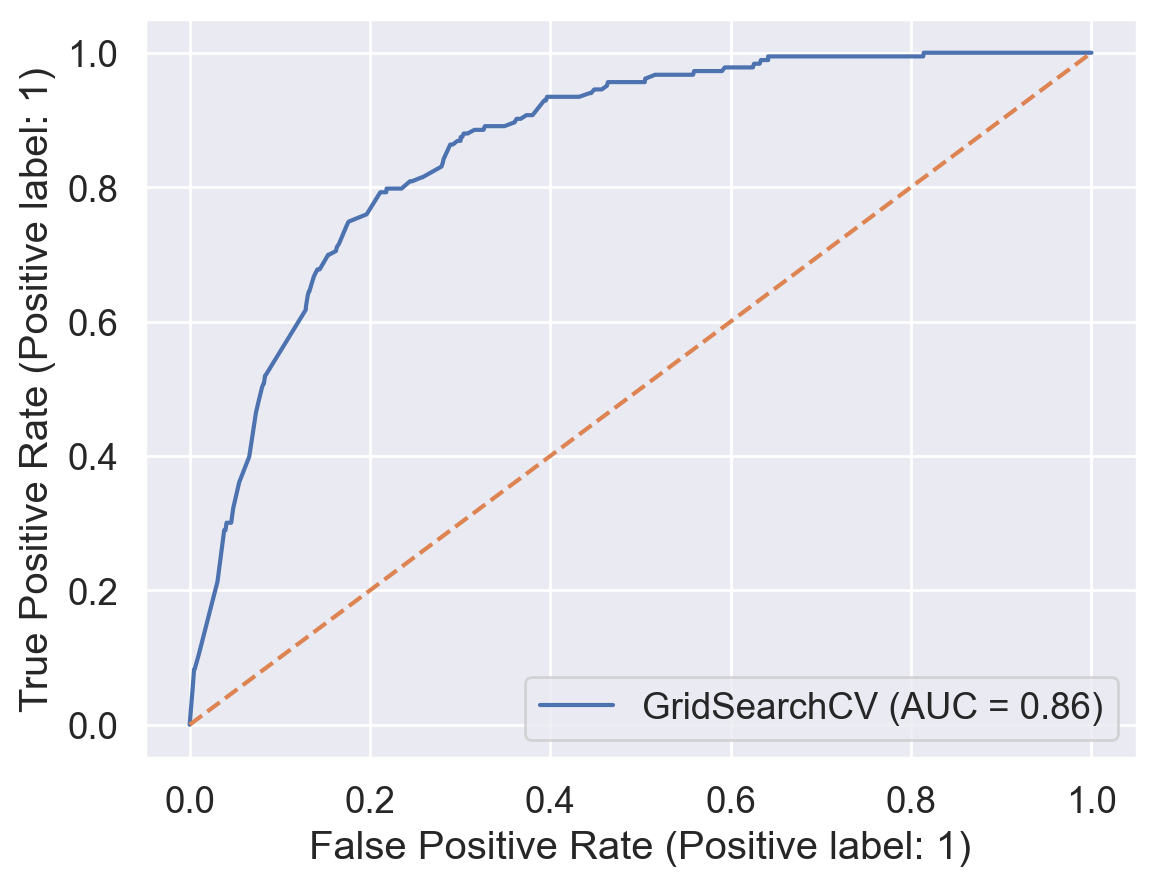

In [91]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(fitted_model, X_test, y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

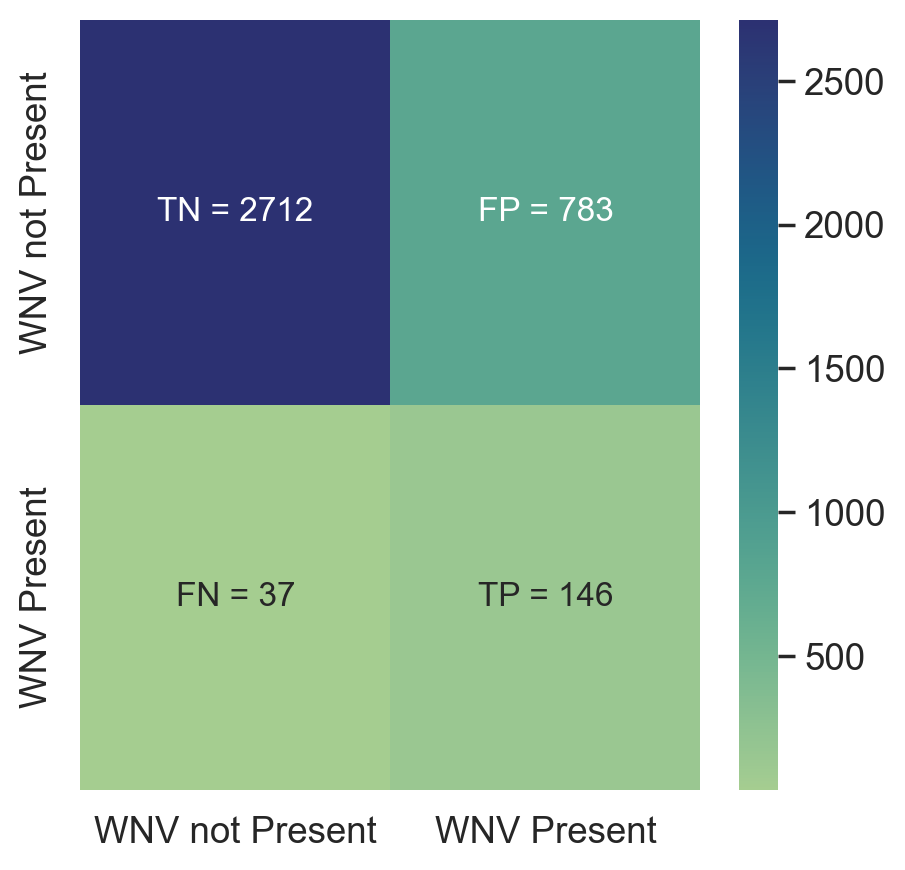

In [92]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test,fitted_model.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(5,5))
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['WNV not Present', 'WNV Present'],
    yticklabels=['WNV not Present', 'WNV Present']
)

In [93]:
coef = fitted_model.best_estimator_['ada_clf'].feature_importances_
feature = fitted_model.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

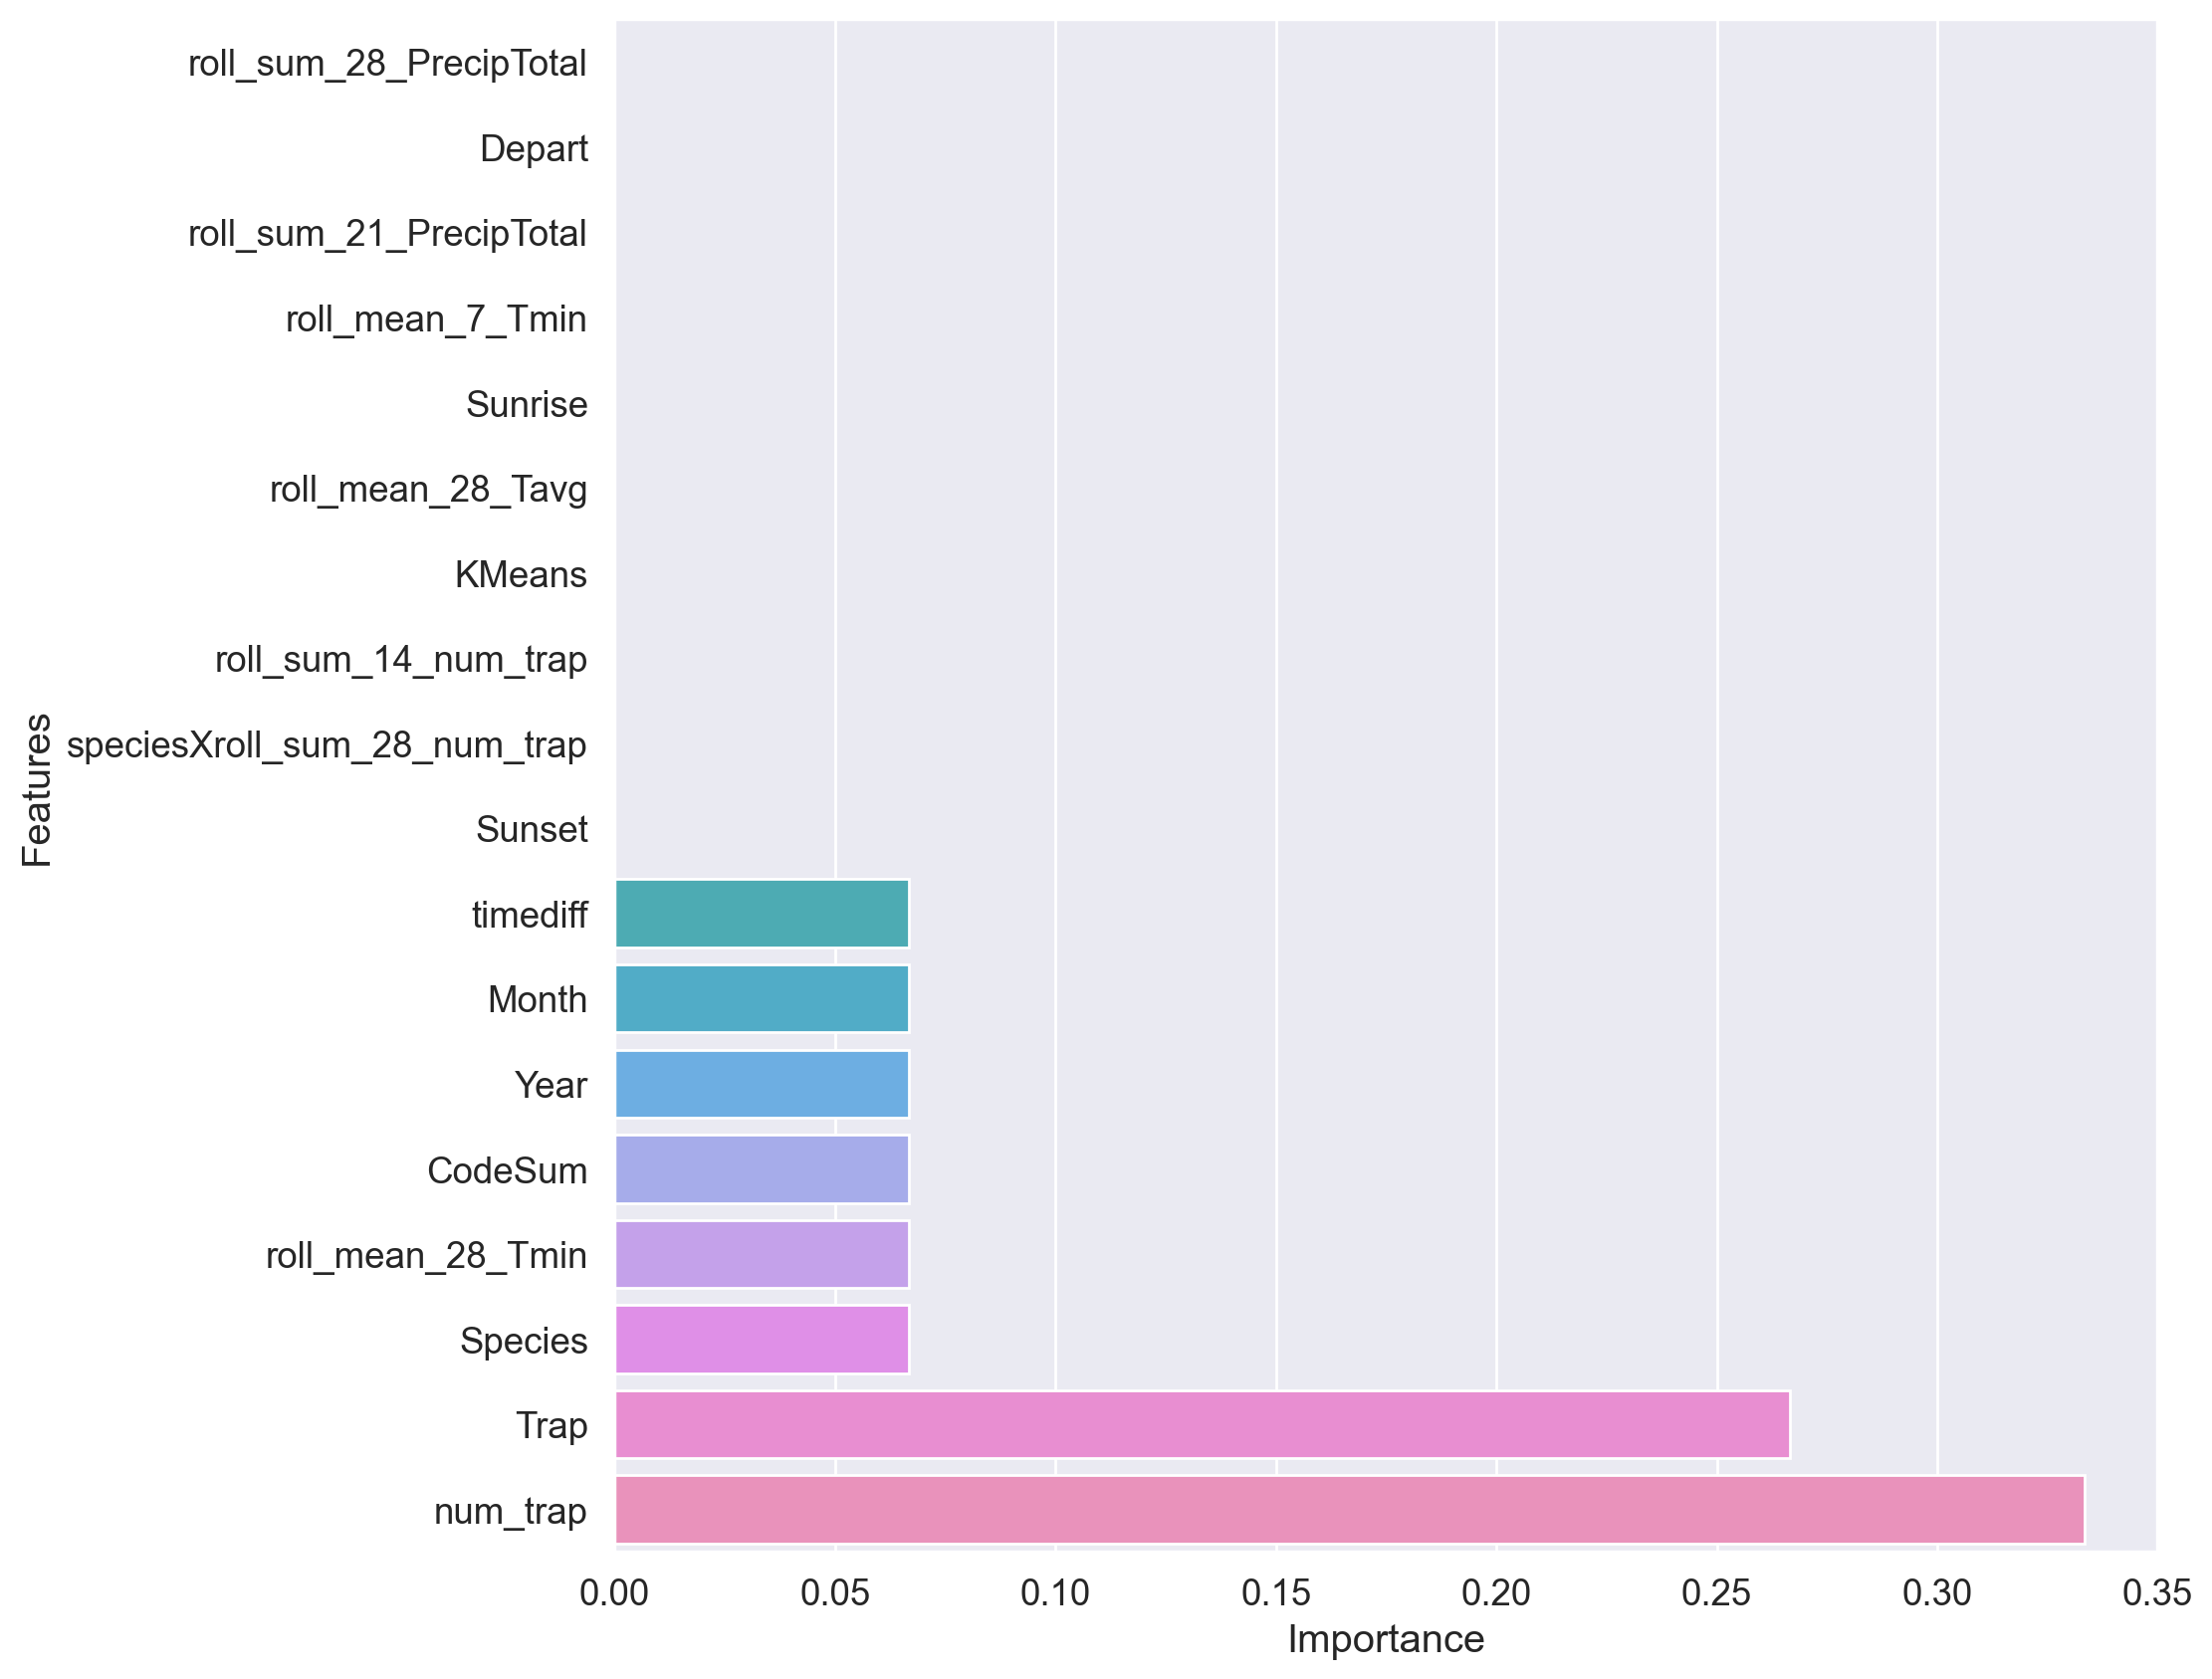

In [94]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(50, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

<a id='cat'></a>

### CatBoost Classifier

In [95]:
pipe_cb = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
    ('cb_clf', CatBoostClassifier())
])

In [96]:
pipe_cb.fit(X_train,y_train)

Learning rate set to 0.030588
0:	learn: 0.6704851	total: 4.34ms	remaining: 4.33s
1:	learn: 0.6479720	total: 8.86ms	remaining: 4.42s
2:	learn: 0.6286914	total: 13.6ms	remaining: 4.53s
3:	learn: 0.6100298	total: 18.1ms	remaining: 4.52s
4:	learn: 0.5941138	total: 22.4ms	remaining: 4.45s
5:	learn: 0.5790126	total: 26.3ms	remaining: 4.35s
6:	learn: 0.5659292	total: 30.3ms	remaining: 4.3s
7:	learn: 0.5526076	total: 34.2ms	remaining: 4.24s
8:	learn: 0.5409283	total: 38.6ms	remaining: 4.25s
9:	learn: 0.5292708	total: 43ms	remaining: 4.26s
10:	learn: 0.5198606	total: 46.9ms	remaining: 4.22s
11:	learn: 0.5116516	total: 50.7ms	remaining: 4.17s
12:	learn: 0.5029169	total: 54.5ms	remaining: 4.14s
13:	learn: 0.4914401	total: 58ms	remaining: 4.08s
14:	learn: 0.4833058	total: 62.2ms	remaining: 4.08s
15:	learn: 0.4746341	total: 66.8ms	remaining: 4.11s
16:	learn: 0.4673873	total: 70.8ms	remaining: 4.09s
17:	learn: 0.4608886	total: 75.3ms	remaining: 4.11s
18:	learn: 0.4535299	total: 79.8ms	remaining: 4.1

201:	learn: 0.1942065	total: 800ms	remaining: 3.16s
202:	learn: 0.1939490	total: 804ms	remaining: 3.16s
203:	learn: 0.1934300	total: 808ms	remaining: 3.15s
204:	learn: 0.1931976	total: 812ms	remaining: 3.15s
205:	learn: 0.1926516	total: 816ms	remaining: 3.15s
206:	learn: 0.1923828	total: 820ms	remaining: 3.14s
207:	learn: 0.1921058	total: 824ms	remaining: 3.14s
208:	learn: 0.1917738	total: 828ms	remaining: 3.13s
209:	learn: 0.1911509	total: 832ms	remaining: 3.13s
210:	learn: 0.1908832	total: 836ms	remaining: 3.13s
211:	learn: 0.1906854	total: 840ms	remaining: 3.12s
212:	learn: 0.1904659	total: 844ms	remaining: 3.12s
213:	learn: 0.1901563	total: 848ms	remaining: 3.11s
214:	learn: 0.1898334	total: 852ms	remaining: 3.11s
215:	learn: 0.1896096	total: 855ms	remaining: 3.1s
216:	learn: 0.1894096	total: 859ms	remaining: 3.1s
217:	learn: 0.1892000	total: 863ms	remaining: 3.1s
218:	learn: 0.1887725	total: 867ms	remaining: 3.09s
219:	learn: 0.1880206	total: 871ms	remaining: 3.09s
220:	learn: 0.1

407:	learn: 0.1369179	total: 1.6s	remaining: 2.32s
408:	learn: 0.1366492	total: 1.6s	remaining: 2.32s
409:	learn: 0.1364774	total: 1.61s	remaining: 2.31s
410:	learn: 0.1362578	total: 1.61s	remaining: 2.31s
411:	learn: 0.1359432	total: 1.61s	remaining: 2.3s
412:	learn: 0.1358304	total: 1.62s	remaining: 2.3s
413:	learn: 0.1357084	total: 1.62s	remaining: 2.3s
414:	learn: 0.1355129	total: 1.63s	remaining: 2.29s
415:	learn: 0.1354074	total: 1.63s	remaining: 2.29s
416:	learn: 0.1352903	total: 1.63s	remaining: 2.28s
417:	learn: 0.1350481	total: 1.64s	remaining: 2.28s
418:	learn: 0.1349059	total: 1.64s	remaining: 2.28s
419:	learn: 0.1346063	total: 1.65s	remaining: 2.27s
420:	learn: 0.1343822	total: 1.65s	remaining: 2.27s
421:	learn: 0.1341944	total: 1.65s	remaining: 2.26s
422:	learn: 0.1340820	total: 1.66s	remaining: 2.26s
423:	learn: 0.1339335	total: 1.66s	remaining: 2.26s
424:	learn: 0.1338225	total: 1.66s	remaining: 2.25s
425:	learn: 0.1336219	total: 1.67s	remaining: 2.25s
426:	learn: 0.133

613:	learn: 0.1056161	total: 2.4s	remaining: 1.51s
614:	learn: 0.1055105	total: 2.4s	remaining: 1.5s
615:	learn: 0.1054012	total: 2.41s	remaining: 1.5s
616:	learn: 0.1053000	total: 2.41s	remaining: 1.5s
617:	learn: 0.1052189	total: 2.42s	remaining: 1.49s
618:	learn: 0.1051360	total: 2.42s	remaining: 1.49s
619:	learn: 0.1050280	total: 2.42s	remaining: 1.49s
620:	learn: 0.1049244	total: 2.43s	remaining: 1.48s
621:	learn: 0.1048488	total: 2.43s	remaining: 1.48s
622:	learn: 0.1047770	total: 2.44s	remaining: 1.48s
623:	learn: 0.1046171	total: 2.44s	remaining: 1.47s
624:	learn: 0.1044835	total: 2.44s	remaining: 1.47s
625:	learn: 0.1044007	total: 2.45s	remaining: 1.46s
626:	learn: 0.1042815	total: 2.45s	remaining: 1.46s
627:	learn: 0.1041354	total: 2.46s	remaining: 1.46s
628:	learn: 0.1039738	total: 2.46s	remaining: 1.45s
629:	learn: 0.1038051	total: 2.47s	remaining: 1.45s
630:	learn: 0.1036872	total: 2.47s	remaining: 1.45s
631:	learn: 0.1035362	total: 2.48s	remaining: 1.44s
632:	learn: 0.103

816:	learn: 0.0883258	total: 3.2s	remaining: 717ms
817:	learn: 0.0882796	total: 3.2s	remaining: 713ms
818:	learn: 0.0882205	total: 3.21s	remaining: 709ms
819:	learn: 0.0881773	total: 3.21s	remaining: 705ms
820:	learn: 0.0880960	total: 3.21s	remaining: 701ms
821:	learn: 0.0880457	total: 3.22s	remaining: 697ms
822:	learn: 0.0879589	total: 3.22s	remaining: 693ms
823:	learn: 0.0878569	total: 3.23s	remaining: 689ms
824:	learn: 0.0878184	total: 3.23s	remaining: 686ms
825:	learn: 0.0877414	total: 3.23s	remaining: 682ms
826:	learn: 0.0876829	total: 3.24s	remaining: 678ms
827:	learn: 0.0876183	total: 3.24s	remaining: 674ms
828:	learn: 0.0875652	total: 3.25s	remaining: 670ms
829:	learn: 0.0875070	total: 3.25s	remaining: 666ms
830:	learn: 0.0874390	total: 3.25s	remaining: 662ms
831:	learn: 0.0873619	total: 3.26s	remaining: 658ms
832:	learn: 0.0873104	total: 3.26s	remaining: 654ms
833:	learn: 0.0872012	total: 3.27s	remaining: 650ms
834:	learn: 0.0871027	total: 3.27s	remaining: 646ms
835:	learn: 0.

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('cb_clf',
                 <catboost.core.CatBoostClassifier object at 0x16362c1c0>)])

In [97]:
pipe_cb.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()),
  ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
  ('cb_clf', <catboost.core.CatBoostClassifier at 0x16362c1c0>)],
 'verbose': False,
 'ss': StandardScaler(),
 'sampling': SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
 'cb_clf': <catboost.core.CatBoostClassifier at 0x16362c1c0>,
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'sampling__smote': None,
 'sampling__tomek__n_jobs': None,
 'sampling__tomek__sampling_strategy': 'majority',
 'sampling__tomek': TomekLinks(sampling_strategy='majority')}

In [98]:
pipe_cb_params = {
    'sampling__sampling_strategy': [1.0], # ['all', auto', 'minority', 'not minority', 0.5]     
    'sampling__random_state': [42],
    'sampling__n_jobs': [1,2,None],
}

In [99]:
pipe_cb_gridsearch = GridSearchCV(pipe_cb, pipe_cb_params, scoring='recall',cv=5,verbose=3)

In [100]:
pipe_cb_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Learning rate set to 0.027823
0:	learn: 0.6723135	total: 4.68ms	remaining: 4.67s
1:	learn: 0.6508377	total: 8.97ms	remaining: 4.48s
2:	learn: 0.6309742	total: 13.1ms	remaining: 4.35s
3:	learn: 0.6124651	total: 17.4ms	remaining: 4.32s
4:	learn: 0.5966688	total: 21.5ms	remaining: 4.28s
5:	learn: 0.5823943	total: 25.5ms	remaining: 4.23s
6:	learn: 0.5674423	total: 29.7ms	remaining: 4.21s
7:	learn: 0.5542618	total: 33.3ms	remaining: 4.13s
8:	learn: 0.5436181	total: 36.7ms	remaining: 4.04s
9:	learn: 0.5320417	total: 40.9ms	remaining: 4.04s
10:	learn: 0.5215362	total: 44.5ms	remaining: 4s
11:	learn: 0.5109096	total: 48.4ms	remaining: 3.98s
12:	learn: 0.4989353	total: 52ms	remaining: 3.95s
13:	learn: 0.4883895	total: 55.9ms	remaining: 3.94s
14:	learn: 0.4791904	total: 59.9ms	remaining: 3.94s
15:	learn: 0.4714283	total: 63.5ms	remaining: 3.9s
16:	learn: 0.4634569	total: 67.3ms	remaining: 3.89s
17:	learn: 0.4544120	total: 71.4ms	remaini

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


23:	learn: 0.4225368	total: 95.6ms	remaining: 3.89s
24:	learn: 0.4177279	total: 100ms	remaining: 3.9s
25:	learn: 0.4127859	total: 104ms	remaining: 3.91s
26:	learn: 0.4065964	total: 108ms	remaining: 3.89s
27:	learn: 0.4004220	total: 112ms	remaining: 3.89s
28:	learn: 0.3967510	total: 116ms	remaining: 3.88s
29:	learn: 0.3909696	total: 120ms	remaining: 3.89s
30:	learn: 0.3862255	total: 124ms	remaining: 3.88s
31:	learn: 0.3814690	total: 128ms	remaining: 3.86s
32:	learn: 0.3780656	total: 132ms	remaining: 3.87s
33:	learn: 0.3712070	total: 135ms	remaining: 3.84s
34:	learn: 0.3683138	total: 139ms	remaining: 3.82s
35:	learn: 0.3643079	total: 142ms	remaining: 3.81s
36:	learn: 0.3622339	total: 145ms	remaining: 3.78s
37:	learn: 0.3591710	total: 149ms	remaining: 3.77s
38:	learn: 0.3556913	total: 152ms	remaining: 3.75s
39:	learn: 0.3503160	total: 156ms	remaining: 3.75s
40:	learn: 0.3464663	total: 160ms	remaining: 3.74s
41:	learn: 0.3442337	total: 164ms	remaining: 3.73s
42:	learn: 0.3383609	total: 167

184:	learn: 0.1996086	total: 692ms	remaining: 3.05s
185:	learn: 0.1990707	total: 696ms	remaining: 3.05s
186:	learn: 0.1987495	total: 700ms	remaining: 3.04s
187:	learn: 0.1984394	total: 704ms	remaining: 3.04s
188:	learn: 0.1981367	total: 708ms	remaining: 3.04s
189:	learn: 0.1977973	total: 712ms	remaining: 3.03s
190:	learn: 0.1973363	total: 715ms	remaining: 3.03s
191:	learn: 0.1969691	total: 719ms	remaining: 3.02s
192:	learn: 0.1966538	total: 723ms	remaining: 3.02s
193:	learn: 0.1963312	total: 726ms	remaining: 3.02s
194:	learn: 0.1961118	total: 730ms	remaining: 3.01s
195:	learn: 0.1957274	total: 734ms	remaining: 3.01s
196:	learn: 0.1954163	total: 738ms	remaining: 3.01s
197:	learn: 0.1947620	total: 741ms	remaining: 3s
198:	learn: 0.1945060	total: 745ms	remaining: 3s
199:	learn: 0.1938459	total: 748ms	remaining: 2.99s
200:	learn: 0.1935386	total: 752ms	remaining: 2.99s
201:	learn: 0.1931736	total: 756ms	remaining: 2.99s
202:	learn: 0.1929578	total: 759ms	remaining: 2.98s
203:	learn: 0.1927

346:	learn: 0.1548317	total: 1.29s	remaining: 2.43s
347:	learn: 0.1546584	total: 1.29s	remaining: 2.42s
348:	learn: 0.1545526	total: 1.3s	remaining: 2.42s
349:	learn: 0.1542125	total: 1.3s	remaining: 2.42s
350:	learn: 0.1540568	total: 1.3s	remaining: 2.41s
351:	learn: 0.1539038	total: 1.31s	remaining: 2.41s
352:	learn: 0.1536166	total: 1.31s	remaining: 2.4s
353:	learn: 0.1534499	total: 1.32s	remaining: 2.4s
354:	learn: 0.1528283	total: 1.32s	remaining: 2.4s
355:	learn: 0.1525490	total: 1.32s	remaining: 2.39s
356:	learn: 0.1522318	total: 1.33s	remaining: 2.39s
357:	learn: 0.1520897	total: 1.33s	remaining: 2.39s
358:	learn: 0.1519460	total: 1.33s	remaining: 2.38s
359:	learn: 0.1514647	total: 1.34s	remaining: 2.38s
360:	learn: 0.1510719	total: 1.34s	remaining: 2.38s
361:	learn: 0.1508783	total: 1.34s	remaining: 2.37s
362:	learn: 0.1507496	total: 1.35s	remaining: 2.37s
363:	learn: 0.1506189	total: 1.35s	remaining: 2.36s
364:	learn: 0.1504978	total: 1.36s	remaining: 2.36s
365:	learn: 0.1501

508:	learn: 0.1202610	total: 1.89s	remaining: 1.83s
509:	learn: 0.1201558	total: 1.9s	remaining: 1.82s
510:	learn: 0.1199345	total: 1.9s	remaining: 1.82s
511:	learn: 0.1198353	total: 1.91s	remaining: 1.82s
512:	learn: 0.1197032	total: 1.91s	remaining: 1.81s
513:	learn: 0.1194460	total: 1.91s	remaining: 1.81s
514:	learn: 0.1192880	total: 1.92s	remaining: 1.8s
515:	learn: 0.1190982	total: 1.92s	remaining: 1.8s
516:	learn: 0.1189260	total: 1.92s	remaining: 1.8s
517:	learn: 0.1188138	total: 1.93s	remaining: 1.79s
518:	learn: 0.1186789	total: 1.93s	remaining: 1.79s
519:	learn: 0.1185461	total: 1.94s	remaining: 1.79s
520:	learn: 0.1184165	total: 1.94s	remaining: 1.78s
521:	learn: 0.1183337	total: 1.94s	remaining: 1.78s
522:	learn: 0.1181485	total: 1.95s	remaining: 1.77s
523:	learn: 0.1180041	total: 1.95s	remaining: 1.77s
524:	learn: 0.1179149	total: 1.95s	remaining: 1.77s
525:	learn: 0.1176943	total: 1.96s	remaining: 1.76s
526:	learn: 0.1175802	total: 1.96s	remaining: 1.76s
527:	learn: 0.117

669:	learn: 0.1002106	total: 2.49s	remaining: 1.23s
670:	learn: 0.1000993	total: 2.5s	remaining: 1.22s
671:	learn: 0.0999603	total: 2.5s	remaining: 1.22s
672:	learn: 0.0998682	total: 2.5s	remaining: 1.22s
673:	learn: 0.0998105	total: 2.51s	remaining: 1.21s
674:	learn: 0.0997198	total: 2.51s	remaining: 1.21s
675:	learn: 0.0996221	total: 2.51s	remaining: 1.21s
676:	learn: 0.0995336	total: 2.52s	remaining: 1.2s
677:	learn: 0.0994615	total: 2.52s	remaining: 1.2s
678:	learn: 0.0993792	total: 2.52s	remaining: 1.19s
679:	learn: 0.0993244	total: 2.53s	remaining: 1.19s
680:	learn: 0.0992219	total: 2.53s	remaining: 1.19s
681:	learn: 0.0991468	total: 2.54s	remaining: 1.18s
682:	learn: 0.0990642	total: 2.54s	remaining: 1.18s
683:	learn: 0.0989807	total: 2.54s	remaining: 1.18s
684:	learn: 0.0989088	total: 2.55s	remaining: 1.17s
685:	learn: 0.0988149	total: 2.55s	remaining: 1.17s
686:	learn: 0.0987313	total: 2.56s	remaining: 1.16s
687:	learn: 0.0986637	total: 2.56s	remaining: 1.16s
688:	learn: 0.098

835:	learn: 0.0858725	total: 3.09s	remaining: 607ms
836:	learn: 0.0857920	total: 3.1s	remaining: 603ms
837:	learn: 0.0857533	total: 3.1s	remaining: 599ms
838:	learn: 0.0856940	total: 3.1s	remaining: 596ms
839:	learn: 0.0856499	total: 3.11s	remaining: 592ms
840:	learn: 0.0855390	total: 3.11s	remaining: 588ms
841:	learn: 0.0854966	total: 3.12s	remaining: 585ms
842:	learn: 0.0854624	total: 3.12s	remaining: 581ms
843:	learn: 0.0854422	total: 3.12s	remaining: 577ms
844:	learn: 0.0853924	total: 3.13s	remaining: 573ms
845:	learn: 0.0853660	total: 3.13s	remaining: 570ms
846:	learn: 0.0853015	total: 3.13s	remaining: 566ms
847:	learn: 0.0852242	total: 3.14s	remaining: 562ms
848:	learn: 0.0851655	total: 3.14s	remaining: 559ms
849:	learn: 0.0851560	total: 3.15s	remaining: 555ms
850:	learn: 0.0850149	total: 3.15s	remaining: 551ms
851:	learn: 0.0849115	total: 3.15s	remaining: 548ms
852:	learn: 0.0848299	total: 3.16s	remaining: 544ms
853:	learn: 0.0847883	total: 3.16s	remaining: 540ms
854:	learn: 0.0

[CV 1/5] END sampling__n_jobs=1, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.297 total time=   3.9s
Learning rate set to 0.02782
0:	learn: 0.6749696	total: 4.75ms	remaining: 4.75s
1:	learn: 0.6569138	total: 9.07ms	remaining: 4.53s
2:	learn: 0.6392207	total: 14ms	remaining: 4.65s
3:	learn: 0.6216650	total: 18.2ms	remaining: 4.52s
4:	learn: 0.6063026	total: 21.9ms	remaining: 4.36s
5:	learn: 0.5950781	total: 25.8ms	remaining: 4.28s
6:	learn: 0.5823726	total: 29.8ms	remaining: 4.22s
7:	learn: 0.5701962	total: 33.5ms	remaining: 4.15s
8:	learn: 0.5556312	total: 37.4ms	remaining: 4.12s
9:	learn: 0.5435656	total: 41.1ms	remaining: 4.07s
10:	learn: 0.5334437	total: 45.4ms	remaining: 4.08s
11:	learn: 0.5234938	total: 48.9ms	remaining: 4.03s
12:	learn: 0.5145995	total: 52.5ms	remaining: 3.99s
13:	learn: 0.5040542	total: 56.7ms	remaining: 3.99s
14:	learn: 0.4976238	total: 60.6ms	remaining: 3.98s
15:	learn: 0.4899830	total: 64.8ms	remaining: 3.99s
16:	learn: 0.4821385	total

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


23:	learn: 0.4378176	total: 95.5ms	remaining: 3.88s
24:	learn: 0.4321313	total: 99.7ms	remaining: 3.89s
25:	learn: 0.4284654	total: 104ms	remaining: 3.88s
26:	learn: 0.4211673	total: 107ms	remaining: 3.87s
27:	learn: 0.4124403	total: 111ms	remaining: 3.86s
28:	learn: 0.4079670	total: 115ms	remaining: 3.85s
29:	learn: 0.4027255	total: 119ms	remaining: 3.85s
30:	learn: 0.3984153	total: 123ms	remaining: 3.83s
31:	learn: 0.3954523	total: 126ms	remaining: 3.82s
32:	learn: 0.3920847	total: 130ms	remaining: 3.82s
33:	learn: 0.3867194	total: 135ms	remaining: 3.83s
34:	learn: 0.3804466	total: 139ms	remaining: 3.84s
35:	learn: 0.3752334	total: 143ms	remaining: 3.83s
36:	learn: 0.3686592	total: 146ms	remaining: 3.81s
37:	learn: 0.3640901	total: 150ms	remaining: 3.79s
38:	learn: 0.3595953	total: 154ms	remaining: 3.78s
39:	learn: 0.3568690	total: 157ms	remaining: 3.78s
40:	learn: 0.3545224	total: 161ms	remaining: 3.77s
41:	learn: 0.3509299	total: 165ms	remaining: 3.76s
42:	learn: 0.3477719	total: 1

183:	learn: 0.2065426	total: 698ms	remaining: 3.09s
184:	learn: 0.2060957	total: 702ms	remaining: 3.09s
185:	learn: 0.2057282	total: 705ms	remaining: 3.09s
186:	learn: 0.2053568	total: 709ms	remaining: 3.08s
187:	learn: 0.2047181	total: 712ms	remaining: 3.08s
188:	learn: 0.2043233	total: 716ms	remaining: 3.07s
189:	learn: 0.2040874	total: 719ms	remaining: 3.07s
190:	learn: 0.2038050	total: 723ms	remaining: 3.06s
191:	learn: 0.2030077	total: 726ms	remaining: 3.06s
192:	learn: 0.2025625	total: 730ms	remaining: 3.05s
193:	learn: 0.2023306	total: 734ms	remaining: 3.05s
194:	learn: 0.2020256	total: 738ms	remaining: 3.04s
195:	learn: 0.2013688	total: 741ms	remaining: 3.04s
196:	learn: 0.2006876	total: 745ms	remaining: 3.04s
197:	learn: 0.1994807	total: 748ms	remaining: 3.03s
198:	learn: 0.1989907	total: 752ms	remaining: 3.03s
199:	learn: 0.1983822	total: 756ms	remaining: 3.02s
200:	learn: 0.1980623	total: 760ms	remaining: 3.02s
201:	learn: 0.1977690	total: 763ms	remaining: 3.02s
202:	learn: 

347:	learn: 0.1532073	total: 1.3s	remaining: 2.43s
348:	learn: 0.1525416	total: 1.3s	remaining: 2.43s
349:	learn: 0.1522150	total: 1.3s	remaining: 2.42s
350:	learn: 0.1520032	total: 1.31s	remaining: 2.42s
351:	learn: 0.1518663	total: 1.31s	remaining: 2.42s
352:	learn: 0.1516110	total: 1.31s	remaining: 2.41s
353:	learn: 0.1513131	total: 1.32s	remaining: 2.41s
354:	learn: 0.1509946	total: 1.32s	remaining: 2.4s
355:	learn: 0.1506153	total: 1.33s	remaining: 2.4s
356:	learn: 0.1502762	total: 1.33s	remaining: 2.4s
357:	learn: 0.1500143	total: 1.33s	remaining: 2.39s
358:	learn: 0.1498613	total: 1.34s	remaining: 2.39s
359:	learn: 0.1495575	total: 1.34s	remaining: 2.38s
360:	learn: 0.1493999	total: 1.34s	remaining: 2.38s
361:	learn: 0.1491672	total: 1.35s	remaining: 2.38s
362:	learn: 0.1490428	total: 1.35s	remaining: 2.37s
363:	learn: 0.1488877	total: 1.35s	remaining: 2.37s
364:	learn: 0.1487897	total: 1.36s	remaining: 2.36s
365:	learn: 0.1485041	total: 1.36s	remaining: 2.36s
366:	learn: 0.1483

513:	learn: 0.1188586	total: 1.9s	remaining: 1.79s
514:	learn: 0.1187050	total: 1.9s	remaining: 1.79s
515:	learn: 0.1185884	total: 1.91s	remaining: 1.79s
516:	learn: 0.1184341	total: 1.91s	remaining: 1.78s
517:	learn: 0.1182913	total: 1.92s	remaining: 1.78s
518:	learn: 0.1179794	total: 1.92s	remaining: 1.78s
519:	learn: 0.1178717	total: 1.92s	remaining: 1.77s
520:	learn: 0.1175836	total: 1.93s	remaining: 1.77s
521:	learn: 0.1174785	total: 1.93s	remaining: 1.77s
522:	learn: 0.1173334	total: 1.94s	remaining: 1.76s
523:	learn: 0.1171761	total: 1.94s	remaining: 1.76s
524:	learn: 0.1170393	total: 1.94s	remaining: 1.76s
525:	learn: 0.1168952	total: 1.95s	remaining: 1.75s
526:	learn: 0.1167207	total: 1.95s	remaining: 1.75s
527:	learn: 0.1164414	total: 1.95s	remaining: 1.75s
528:	learn: 0.1162236	total: 1.96s	remaining: 1.74s
529:	learn: 0.1161069	total: 1.96s	remaining: 1.74s
530:	learn: 0.1159472	total: 1.97s	remaining: 1.74s
531:	learn: 0.1158561	total: 1.97s	remaining: 1.73s
532:	learn: 0.

673:	learn: 0.0987515	total: 2.5s	remaining: 1.21s
674:	learn: 0.0986664	total: 2.5s	remaining: 1.2s
675:	learn: 0.0984363	total: 2.5s	remaining: 1.2s
676:	learn: 0.0983325	total: 2.51s	remaining: 1.2s
677:	learn: 0.0982898	total: 2.51s	remaining: 1.19s
678:	learn: 0.0982084	total: 2.51s	remaining: 1.19s
679:	learn: 0.0980761	total: 2.52s	remaining: 1.19s
680:	learn: 0.0979640	total: 2.52s	remaining: 1.18s
681:	learn: 0.0978023	total: 2.52s	remaining: 1.18s
682:	learn: 0.0977478	total: 2.53s	remaining: 1.17s
683:	learn: 0.0976848	total: 2.53s	remaining: 1.17s
684:	learn: 0.0975245	total: 2.54s	remaining: 1.17s
685:	learn: 0.0974680	total: 2.54s	remaining: 1.16s
686:	learn: 0.0974038	total: 2.54s	remaining: 1.16s
687:	learn: 0.0973166	total: 2.55s	remaining: 1.16s
688:	learn: 0.0972049	total: 2.55s	remaining: 1.15s
689:	learn: 0.0970651	total: 2.55s	remaining: 1.15s
690:	learn: 0.0969098	total: 2.56s	remaining: 1.14s
691:	learn: 0.0968708	total: 2.56s	remaining: 1.14s
692:	learn: 0.0968

835:	learn: 0.0853990	total: 3.1s	remaining: 608ms
836:	learn: 0.0853197	total: 3.1s	remaining: 604ms
837:	learn: 0.0852556	total: 3.1s	remaining: 600ms
838:	learn: 0.0851444	total: 3.11s	remaining: 596ms
839:	learn: 0.0850754	total: 3.11s	remaining: 593ms
840:	learn: 0.0849648	total: 3.12s	remaining: 589ms
841:	learn: 0.0849190	total: 3.12s	remaining: 585ms
842:	learn: 0.0848554	total: 3.12s	remaining: 582ms
843:	learn: 0.0847991	total: 3.13s	remaining: 578ms
844:	learn: 0.0847401	total: 3.13s	remaining: 574ms
845:	learn: 0.0846663	total: 3.13s	remaining: 571ms
846:	learn: 0.0846312	total: 3.14s	remaining: 567ms
847:	learn: 0.0845829	total: 3.14s	remaining: 563ms
848:	learn: 0.0845311	total: 3.14s	remaining: 559ms
849:	learn: 0.0844739	total: 3.15s	remaining: 556ms
850:	learn: 0.0843991	total: 3.15s	remaining: 552ms
851:	learn: 0.0843282	total: 3.15s	remaining: 548ms
852:	learn: 0.0842491	total: 3.16s	remaining: 544ms
853:	learn: 0.0842204	total: 3.16s	remaining: 541ms
854:	learn: 0.0

[CV 2/5] END sampling__n_jobs=1, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.284 total time=   3.9s
Learning rate set to 0.027839
0:	learn: 0.6743257	total: 3.84ms	remaining: 3.84s
1:	learn: 0.6546687	total: 7.84ms	remaining: 3.91s
2:	learn: 0.6386234	total: 11.9ms	remaining: 3.95s
3:	learn: 0.6210597	total: 15.1ms	remaining: 3.75s
4:	learn: 0.6062429	total: 19ms	remaining: 3.79s
5:	learn: 0.5913768	total: 22.8ms	remaining: 3.77s
6:	learn: 0.5785243	total: 27.1ms	remaining: 3.84s
7:	learn: 0.5668227	total: 30.8ms	remaining: 3.82s
8:	learn: 0.5556155	total: 34.5ms	remaining: 3.8s
9:	learn: 0.5447762	total: 38.5ms	remaining: 3.81s
10:	learn: 0.5346331	total: 42.6ms	remaining: 3.83s
11:	learn: 0.5235756	total: 47.2ms	remaining: 3.89s
12:	learn: 0.5110344	total: 51.1ms	remaining: 3.88s
13:	learn: 0.5006033	total: 55.1ms	remaining: 3.88s
14:	learn: 0.4916491	total: 58.8ms	remaining: 3.86s
15:	learn: 0.4841210	total: 62.3ms	remaining: 3.83s
16:	learn: 0.4775428	total

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


23:	learn: 0.4346816	total: 93.3ms	remaining: 3.79s
24:	learn: 0.4303938	total: 98.9ms	remaining: 3.86s
25:	learn: 0.4231119	total: 103ms	remaining: 3.87s
26:	learn: 0.4149797	total: 107ms	remaining: 3.85s
27:	learn: 0.4090179	total: 111ms	remaining: 3.86s
28:	learn: 0.3999865	total: 115ms	remaining: 3.87s
29:	learn: 0.3945065	total: 119ms	remaining: 3.85s
30:	learn: 0.3896225	total: 123ms	remaining: 3.85s
31:	learn: 0.3869373	total: 127ms	remaining: 3.84s
32:	learn: 0.3836095	total: 131ms	remaining: 3.84s
33:	learn: 0.3769107	total: 135ms	remaining: 3.84s
34:	learn: 0.3718793	total: 139ms	remaining: 3.83s
35:	learn: 0.3662842	total: 143ms	remaining: 3.83s
36:	learn: 0.3637274	total: 147ms	remaining: 3.82s
37:	learn: 0.3600991	total: 151ms	remaining: 3.82s
38:	learn: 0.3576368	total: 155ms	remaining: 3.81s
39:	learn: 0.3528675	total: 158ms	remaining: 3.8s
40:	learn: 0.3488025	total: 162ms	remaining: 3.79s
41:	learn: 0.3468685	total: 166ms	remaining: 3.79s
42:	learn: 0.3418299	total: 17

184:	learn: 0.2055893	total: 691ms	remaining: 3.04s
185:	learn: 0.2052791	total: 694ms	remaining: 3.04s
186:	learn: 0.2047853	total: 698ms	remaining: 3.04s
187:	learn: 0.2043743	total: 702ms	remaining: 3.03s
188:	learn: 0.2039182	total: 706ms	remaining: 3.03s
189:	learn: 0.2033945	total: 709ms	remaining: 3.02s
190:	learn: 0.2030803	total: 713ms	remaining: 3.02s
191:	learn: 0.2027969	total: 716ms	remaining: 3.01s
192:	learn: 0.2024523	total: 720ms	remaining: 3.01s
193:	learn: 0.2018890	total: 723ms	remaining: 3s
194:	learn: 0.2015502	total: 727ms	remaining: 3s
195:	learn: 0.2014051	total: 730ms	remaining: 3s
196:	learn: 0.2011031	total: 734ms	remaining: 2.99s
197:	learn: 0.2003756	total: 738ms	remaining: 2.99s
198:	learn: 0.2000711	total: 741ms	remaining: 2.98s
199:	learn: 0.1995290	total: 745ms	remaining: 2.98s
200:	learn: 0.1992970	total: 749ms	remaining: 2.98s
201:	learn: 0.1989919	total: 753ms	remaining: 2.97s
202:	learn: 0.1987969	total: 756ms	remaining: 2.97s
203:	learn: 0.1984265

350:	learn: 0.1545108	total: 1.29s	remaining: 2.39s
351:	learn: 0.1543924	total: 1.29s	remaining: 2.38s
352:	learn: 0.1541398	total: 1.3s	remaining: 2.38s
353:	learn: 0.1539769	total: 1.3s	remaining: 2.38s
354:	learn: 0.1538266	total: 1.3s	remaining: 2.37s
355:	learn: 0.1536342	total: 1.31s	remaining: 2.37s
356:	learn: 0.1532834	total: 1.31s	remaining: 2.36s
357:	learn: 0.1528652	total: 1.32s	remaining: 2.36s
358:	learn: 0.1526574	total: 1.32s	remaining: 2.36s
359:	learn: 0.1524461	total: 1.32s	remaining: 2.35s
360:	learn: 0.1522843	total: 1.33s	remaining: 2.35s
361:	learn: 0.1520845	total: 1.33s	remaining: 2.35s
362:	learn: 0.1519471	total: 1.33s	remaining: 2.34s
363:	learn: 0.1516121	total: 1.34s	remaining: 2.34s
364:	learn: 0.1513335	total: 1.34s	remaining: 2.33s
365:	learn: 0.1512218	total: 1.34s	remaining: 2.33s
366:	learn: 0.1510513	total: 1.35s	remaining: 2.33s
367:	learn: 0.1509456	total: 1.35s	remaining: 2.32s
368:	learn: 0.1507482	total: 1.35s	remaining: 2.32s
369:	learn: 0.1

516:	learn: 0.1196632	total: 1.89s	remaining: 1.77s
517:	learn: 0.1194679	total: 1.9s	remaining: 1.77s
518:	learn: 0.1193012	total: 1.9s	remaining: 1.76s
519:	learn: 0.1190712	total: 1.91s	remaining: 1.76s
520:	learn: 0.1189652	total: 1.91s	remaining: 1.75s
521:	learn: 0.1187582	total: 1.91s	remaining: 1.75s
522:	learn: 0.1186999	total: 1.92s	remaining: 1.75s
523:	learn: 0.1185804	total: 1.92s	remaining: 1.74s
524:	learn: 0.1184761	total: 1.92s	remaining: 1.74s
525:	learn: 0.1183093	total: 1.93s	remaining: 1.74s
526:	learn: 0.1181362	total: 1.93s	remaining: 1.73s
527:	learn: 0.1180254	total: 1.93s	remaining: 1.73s
528:	learn: 0.1178903	total: 1.94s	remaining: 1.73s
529:	learn: 0.1177663	total: 1.94s	remaining: 1.72s
530:	learn: 0.1176496	total: 1.95s	remaining: 1.72s
531:	learn: 0.1174064	total: 1.95s	remaining: 1.71s
532:	learn: 0.1173064	total: 1.95s	remaining: 1.71s
533:	learn: 0.1171449	total: 1.96s	remaining: 1.71s
534:	learn: 0.1170035	total: 1.96s	remaining: 1.7s
535:	learn: 0.1

680:	learn: 0.0997087	total: 2.5s	remaining: 1.17s
681:	learn: 0.0996238	total: 2.5s	remaining: 1.17s
682:	learn: 0.0995706	total: 2.5s	remaining: 1.16s
683:	learn: 0.0994714	total: 2.51s	remaining: 1.16s
684:	learn: 0.0993830	total: 2.51s	remaining: 1.15s
685:	learn: 0.0992394	total: 2.51s	remaining: 1.15s
686:	learn: 0.0991452	total: 2.52s	remaining: 1.15s
687:	learn: 0.0990647	total: 2.52s	remaining: 1.14s
688:	learn: 0.0989519	total: 2.52s	remaining: 1.14s
689:	learn: 0.0988819	total: 2.53s	remaining: 1.14s
690:	learn: 0.0988417	total: 2.53s	remaining: 1.13s
691:	learn: 0.0987808	total: 2.53s	remaining: 1.13s
692:	learn: 0.0987167	total: 2.54s	remaining: 1.12s
693:	learn: 0.0986725	total: 2.54s	remaining: 1.12s
694:	learn: 0.0985539	total: 2.54s	remaining: 1.12s
695:	learn: 0.0984678	total: 2.55s	remaining: 1.11s
696:	learn: 0.0984020	total: 2.55s	remaining: 1.11s
697:	learn: 0.0983061	total: 2.56s	remaining: 1.11s
698:	learn: 0.0982003	total: 2.56s	remaining: 1.1s
699:	learn: 0.09

840:	learn: 0.0858906	total: 3.1s	remaining: 585ms
841:	learn: 0.0858453	total: 3.1s	remaining: 582ms
842:	learn: 0.0857848	total: 3.1s	remaining: 578ms
843:	learn: 0.0856992	total: 3.11s	remaining: 574ms
844:	learn: 0.0856165	total: 3.11s	remaining: 571ms
845:	learn: 0.0855640	total: 3.11s	remaining: 567ms
846:	learn: 0.0854836	total: 3.12s	remaining: 563ms
847:	learn: 0.0853898	total: 3.12s	remaining: 560ms
848:	learn: 0.0853208	total: 3.13s	remaining: 556ms
849:	learn: 0.0852140	total: 3.13s	remaining: 553ms
850:	learn: 0.0851545	total: 3.13s	remaining: 549ms
851:	learn: 0.0851207	total: 3.14s	remaining: 545ms
852:	learn: 0.0850601	total: 3.14s	remaining: 542ms
853:	learn: 0.0849934	total: 3.15s	remaining: 538ms
854:	learn: 0.0848984	total: 3.15s	remaining: 534ms
855:	learn: 0.0848409	total: 3.15s	remaining: 531ms
856:	learn: 0.0848136	total: 3.16s	remaining: 527ms
857:	learn: 0.0847287	total: 3.16s	remaining: 523ms
858:	learn: 0.0846658	total: 3.17s	remaining: 520ms
859:	learn: 0.0

Learning rate set to 0.027831
0:	learn: 0.6718969	total: 6ms	remaining: 5.99s
1:	learn: 0.6515245	total: 10.4ms	remaining: 5.2s
2:	learn: 0.6321489	total: 14.9ms	remaining: 4.95s
3:	learn: 0.6142428	total: 19ms	remaining: 4.74s
4:	learn: 0.5993357	total: 23.4ms	remaining: 4.66s
5:	learn: 0.5841918	total: 27.6ms	remaining: 4.57s
6:	learn: 0.5715862	total: 32ms	remaining: 4.53s
7:	learn: 0.5601950	total: 36.2ms	remaining: 4.49s
8:	learn: 0.5485882	total: 40.1ms	remaining: 4.42s
9:	learn: 0.5372418	total: 43.9ms	remaining: 4.34s
10:	learn: 0.5266378	total: 47.5ms	remaining: 4.27s
11:	learn: 0.5180717	total: 50.9ms	remaining: 4.19s


/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


12:	learn: 0.5093789	total: 55ms	remaining: 4.17s
13:	learn: 0.5005630	total: 59ms	remaining: 4.16s
14:	learn: 0.4928366	total: 63.2ms	remaining: 4.15s
15:	learn: 0.4844401	total: 67.6ms	remaining: 4.16s
16:	learn: 0.4765393	total: 72.5ms	remaining: 4.19s
17:	learn: 0.4673302	total: 76.6ms	remaining: 4.18s
18:	learn: 0.4616454	total: 80.5ms	remaining: 4.16s
19:	learn: 0.4556116	total: 84.7ms	remaining: 4.15s
20:	learn: 0.4506605	total: 88.9ms	remaining: 4.14s
21:	learn: 0.4448206	total: 93.2ms	remaining: 4.14s
22:	learn: 0.4399042	total: 97.3ms	remaining: 4.13s
23:	learn: 0.4348973	total: 101ms	remaining: 4.13s
24:	learn: 0.4293927	total: 106ms	remaining: 4.12s
25:	learn: 0.4251128	total: 110ms	remaining: 4.11s
26:	learn: 0.4180281	total: 114ms	remaining: 4.1s
27:	learn: 0.4104667	total: 117ms	remaining: 4.08s
28:	learn: 0.4027946	total: 121ms	remaining: 4.07s
29:	learn: 0.3966707	total: 125ms	remaining: 4.04s
30:	learn: 0.3914244	total: 129ms	remaining: 4.03s
31:	learn: 0.3869727	tota

209:	learn: 0.1920684	total: 798ms	remaining: 3s
210:	learn: 0.1916895	total: 801ms	remaining: 3s
211:	learn: 0.1912793	total: 805ms	remaining: 2.99s
212:	learn: 0.1906786	total: 809ms	remaining: 2.99s
213:	learn: 0.1902774	total: 813ms	remaining: 2.98s
214:	learn: 0.1900736	total: 816ms	remaining: 2.98s
215:	learn: 0.1898823	total: 820ms	remaining: 2.98s
216:	learn: 0.1897102	total: 823ms	remaining: 2.97s
217:	learn: 0.1895194	total: 827ms	remaining: 2.97s
218:	learn: 0.1892271	total: 831ms	remaining: 2.96s
219:	learn: 0.1885406	total: 834ms	remaining: 2.96s
220:	learn: 0.1880660	total: 838ms	remaining: 2.96s
221:	learn: 0.1873324	total: 842ms	remaining: 2.95s
222:	learn: 0.1869950	total: 846ms	remaining: 2.95s
223:	learn: 0.1865072	total: 850ms	remaining: 2.94s
224:	learn: 0.1861482	total: 853ms	remaining: 2.94s
225:	learn: 0.1857951	total: 857ms	remaining: 2.93s
226:	learn: 0.1853880	total: 861ms	remaining: 2.93s
227:	learn: 0.1850389	total: 865ms	remaining: 2.93s
228:	learn: 0.1846

370:	learn: 0.1444988	total: 1.4s	remaining: 2.37s
371:	learn: 0.1442482	total: 1.4s	remaining: 2.37s
372:	learn: 0.1441302	total: 1.4s	remaining: 2.36s
373:	learn: 0.1439868	total: 1.41s	remaining: 2.36s
374:	learn: 0.1436422	total: 1.41s	remaining: 2.35s
375:	learn: 0.1431183	total: 1.42s	remaining: 2.35s
376:	learn: 0.1429090	total: 1.42s	remaining: 2.35s
377:	learn: 0.1427829	total: 1.42s	remaining: 2.34s
378:	learn: 0.1423143	total: 1.43s	remaining: 2.34s
379:	learn: 0.1420464	total: 1.43s	remaining: 2.33s
380:	learn: 0.1418691	total: 1.43s	remaining: 2.33s
381:	learn: 0.1415945	total: 1.44s	remaining: 2.33s
382:	learn: 0.1414609	total: 1.44s	remaining: 2.32s
383:	learn: 0.1412572	total: 1.44s	remaining: 2.32s
384:	learn: 0.1409781	total: 1.45s	remaining: 2.31s
385:	learn: 0.1407122	total: 1.45s	remaining: 2.31s
386:	learn: 0.1405281	total: 1.46s	remaining: 2.31s
387:	learn: 0.1402687	total: 1.46s	remaining: 2.3s
388:	learn: 0.1401207	total: 1.46s	remaining: 2.3s
389:	learn: 0.139

533:	learn: 0.1130702	total: 2s	remaining: 1.74s
534:	learn: 0.1128996	total: 2s	remaining: 1.74s
535:	learn: 0.1127561	total: 2s	remaining: 1.73s
536:	learn: 0.1126466	total: 2.01s	remaining: 1.73s
537:	learn: 0.1125220	total: 2.01s	remaining: 1.73s
538:	learn: 0.1123968	total: 2.02s	remaining: 1.72s
539:	learn: 0.1122613	total: 2.02s	remaining: 1.72s
540:	learn: 0.1121364	total: 2.02s	remaining: 1.72s
541:	learn: 0.1119837	total: 2.03s	remaining: 1.71s
542:	learn: 0.1118122	total: 2.03s	remaining: 1.71s
543:	learn: 0.1117246	total: 2.03s	remaining: 1.7s
544:	learn: 0.1115548	total: 2.04s	remaining: 1.7s
545:	learn: 0.1113334	total: 2.04s	remaining: 1.7s
546:	learn: 0.1112055	total: 2.04s	remaining: 1.69s
547:	learn: 0.1110406	total: 2.05s	remaining: 1.69s
548:	learn: 0.1107820	total: 2.05s	remaining: 1.69s
549:	learn: 0.1106542	total: 2.06s	remaining: 1.68s
550:	learn: 0.1106126	total: 2.06s	remaining: 1.68s
551:	learn: 0.1103866	total: 2.06s	remaining: 1.67s
552:	learn: 0.1101754	to

709:	learn: 0.0943595	total: 2.66s	remaining: 1.09s
710:	learn: 0.0942914	total: 2.67s	remaining: 1.08s
711:	learn: 0.0941548	total: 2.67s	remaining: 1.08s
712:	learn: 0.0941202	total: 2.67s	remaining: 1.07s
713:	learn: 0.0940415	total: 2.68s	remaining: 1.07s
714:	learn: 0.0939807	total: 2.68s	remaining: 1.07s
715:	learn: 0.0938788	total: 2.68s	remaining: 1.06s
716:	learn: 0.0938133	total: 2.69s	remaining: 1.06s
717:	learn: 0.0937836	total: 2.69s	remaining: 1.06s
718:	learn: 0.0937037	total: 2.69s	remaining: 1.05s
719:	learn: 0.0935979	total: 2.7s	remaining: 1.05s
720:	learn: 0.0935290	total: 2.7s	remaining: 1.05s
721:	learn: 0.0934593	total: 2.71s	remaining: 1.04s
722:	learn: 0.0933839	total: 2.71s	remaining: 1.04s
723:	learn: 0.0932911	total: 2.71s	remaining: 1.03s
724:	learn: 0.0932121	total: 2.72s	remaining: 1.03s
725:	learn: 0.0931075	total: 2.72s	remaining: 1.03s
726:	learn: 0.0930397	total: 2.73s	remaining: 1.02s
727:	learn: 0.0929663	total: 2.73s	remaining: 1.02s
728:	learn: 0.

872:	learn: 0.0814704	total: 3.26s	remaining: 475ms
873:	learn: 0.0814135	total: 3.27s	remaining: 471ms
874:	learn: 0.0813600	total: 3.27s	remaining: 467ms
875:	learn: 0.0812886	total: 3.27s	remaining: 463ms
876:	learn: 0.0812592	total: 3.28s	remaining: 460ms
877:	learn: 0.0812059	total: 3.28s	remaining: 456ms
878:	learn: 0.0811358	total: 3.28s	remaining: 452ms
879:	learn: 0.0810729	total: 3.29s	remaining: 448ms
880:	learn: 0.0809876	total: 3.29s	remaining: 445ms
881:	learn: 0.0809199	total: 3.29s	remaining: 441ms
882:	learn: 0.0808534	total: 3.3s	remaining: 437ms
883:	learn: 0.0808350	total: 3.3s	remaining: 433ms
884:	learn: 0.0808106	total: 3.31s	remaining: 430ms
885:	learn: 0.0807629	total: 3.31s	remaining: 426ms
886:	learn: 0.0806693	total: 3.31s	remaining: 422ms
887:	learn: 0.0806020	total: 3.32s	remaining: 418ms
888:	learn: 0.0805458	total: 3.32s	remaining: 415ms
889:	learn: 0.0804896	total: 3.32s	remaining: 411ms
890:	learn: 0.0804253	total: 3.33s	remaining: 407ms
891:	learn: 0.

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


5:	learn: 0.5876031	total: 24.6ms	remaining: 4.07s
6:	learn: 0.5734189	total: 28.5ms	remaining: 4.04s
7:	learn: 0.5617136	total: 32.5ms	remaining: 4.03s
8:	learn: 0.5495699	total: 36.3ms	remaining: 4s
9:	learn: 0.5388611	total: 40.2ms	remaining: 3.98s
10:	learn: 0.5291650	total: 44.4ms	remaining: 3.99s
11:	learn: 0.5215494	total: 48.1ms	remaining: 3.96s
12:	learn: 0.5128631	total: 52.3ms	remaining: 3.97s
13:	learn: 0.5015910	total: 56.4ms	remaining: 3.97s
14:	learn: 0.4932996	total: 60.2ms	remaining: 3.95s
15:	learn: 0.4854012	total: 64.7ms	remaining: 3.98s
16:	learn: 0.4778795	total: 69ms	remaining: 3.99s
17:	learn: 0.4716337	total: 72.8ms	remaining: 3.97s
18:	learn: 0.4657866	total: 76.9ms	remaining: 3.97s
19:	learn: 0.4589583	total: 80.9ms	remaining: 3.96s
20:	learn: 0.4533693	total: 84.7ms	remaining: 3.95s
21:	learn: 0.4467524	total: 88.9ms	remaining: 3.95s
22:	learn: 0.4411859	total: 92.5ms	remaining: 3.93s
23:	learn: 0.4357629	total: 97.1ms	remaining: 3.95s
24:	learn: 0.4314120	t

201:	learn: 0.1895327	total: 793ms	remaining: 3.13s
202:	learn: 0.1891657	total: 796ms	remaining: 3.13s
203:	learn: 0.1888434	total: 800ms	remaining: 3.12s
204:	learn: 0.1885061	total: 804ms	remaining: 3.12s
205:	learn: 0.1879325	total: 807ms	remaining: 3.11s
206:	learn: 0.1876727	total: 811ms	remaining: 3.11s
207:	learn: 0.1873425	total: 815ms	remaining: 3.1s
208:	learn: 0.1868286	total: 819ms	remaining: 3.1s
209:	learn: 0.1865581	total: 823ms	remaining: 3.1s
210:	learn: 0.1861495	total: 827ms	remaining: 3.09s
211:	learn: 0.1858407	total: 831ms	remaining: 3.09s
212:	learn: 0.1854451	total: 835ms	remaining: 3.08s
213:	learn: 0.1849396	total: 839ms	remaining: 3.08s
214:	learn: 0.1844975	total: 843ms	remaining: 3.08s
215:	learn: 0.1841961	total: 846ms	remaining: 3.07s
216:	learn: 0.1839660	total: 850ms	remaining: 3.07s
217:	learn: 0.1835858	total: 854ms	remaining: 3.06s
218:	learn: 0.1833127	total: 857ms	remaining: 3.06s
219:	learn: 0.1827365	total: 861ms	remaining: 3.05s
220:	learn: 0.1

368:	learn: 0.1413989	total: 1.39s	remaining: 2.38s
369:	learn: 0.1411609	total: 1.39s	remaining: 2.37s
370:	learn: 0.1410111	total: 1.4s	remaining: 2.37s
371:	learn: 0.1406809	total: 1.4s	remaining: 2.36s
372:	learn: 0.1402872	total: 1.4s	remaining: 2.36s
373:	learn: 0.1400743	total: 1.41s	remaining: 2.35s
374:	learn: 0.1399469	total: 1.41s	remaining: 2.35s
375:	learn: 0.1397598	total: 1.41s	remaining: 2.35s
376:	learn: 0.1395368	total: 1.42s	remaining: 2.34s
377:	learn: 0.1393589	total: 1.42s	remaining: 2.34s
378:	learn: 0.1390176	total: 1.42s	remaining: 2.33s
379:	learn: 0.1388408	total: 1.43s	remaining: 2.33s
380:	learn: 0.1384945	total: 1.43s	remaining: 2.33s
381:	learn: 0.1383606	total: 1.44s	remaining: 2.32s
382:	learn: 0.1381040	total: 1.44s	remaining: 2.32s
383:	learn: 0.1379273	total: 1.44s	remaining: 2.31s
384:	learn: 0.1376879	total: 1.45s	remaining: 2.31s
385:	learn: 0.1375615	total: 1.45s	remaining: 2.31s
386:	learn: 0.1374047	total: 1.45s	remaining: 2.3s
387:	learn: 0.13

539:	learn: 0.1089897	total: 1.99s	remaining: 1.69s
540:	learn: 0.1088395	total: 1.99s	remaining: 1.69s
541:	learn: 0.1087483	total: 2s	remaining: 1.69s
542:	learn: 0.1085716	total: 2s	remaining: 1.68s
543:	learn: 0.1084592	total: 2s	remaining: 1.68s
544:	learn: 0.1081774	total: 2s	remaining: 1.67s
545:	learn: 0.1080143	total: 2.01s	remaining: 1.67s
546:	learn: 0.1078636	total: 2.01s	remaining: 1.67s
547:	learn: 0.1077794	total: 2.02s	remaining: 1.66s
548:	learn: 0.1076349	total: 2.02s	remaining: 1.66s
549:	learn: 0.1073809	total: 2.02s	remaining: 1.66s
550:	learn: 0.1071987	total: 2.03s	remaining: 1.65s
551:	learn: 0.1070381	total: 2.03s	remaining: 1.65s
552:	learn: 0.1069518	total: 2.03s	remaining: 1.64s
553:	learn: 0.1068263	total: 2.04s	remaining: 1.64s
554:	learn: 0.1066295	total: 2.04s	remaining: 1.64s
555:	learn: 0.1065240	total: 2.04s	remaining: 1.63s
556:	learn: 0.1064432	total: 2.05s	remaining: 1.63s
557:	learn: 0.1062843	total: 2.05s	remaining: 1.62s
558:	learn: 0.1061517	to

705:	learn: 0.0905441	total: 2.59s	remaining: 1.08s
706:	learn: 0.0904470	total: 2.59s	remaining: 1.07s
707:	learn: 0.0903547	total: 2.6s	remaining: 1.07s
708:	learn: 0.0902045	total: 2.6s	remaining: 1.07s
709:	learn: 0.0901458	total: 2.6s	remaining: 1.06s
710:	learn: 0.0900622	total: 2.61s	remaining: 1.06s
711:	learn: 0.0899899	total: 2.61s	remaining: 1.05s
712:	learn: 0.0898676	total: 2.61s	remaining: 1.05s
713:	learn: 0.0898069	total: 2.62s	remaining: 1.05s
714:	learn: 0.0897258	total: 2.62s	remaining: 1.04s
715:	learn: 0.0896590	total: 2.62s	remaining: 1.04s
716:	learn: 0.0895395	total: 2.63s	remaining: 1.04s
717:	learn: 0.0894623	total: 2.63s	remaining: 1.03s
718:	learn: 0.0893788	total: 2.63s	remaining: 1.03s
719:	learn: 0.0892943	total: 2.64s	remaining: 1.02s
720:	learn: 0.0891736	total: 2.64s	remaining: 1.02s
721:	learn: 0.0890823	total: 2.65s	remaining: 1.02s
722:	learn: 0.0890318	total: 2.65s	remaining: 1.01s
723:	learn: 0.0889096	total: 2.65s	remaining: 1.01s
724:	learn: 0.0

870:	learn: 0.0778433	total: 3.19s	remaining: 472ms
871:	learn: 0.0778195	total: 3.19s	remaining: 468ms
872:	learn: 0.0777532	total: 3.19s	remaining: 465ms
873:	learn: 0.0776919	total: 3.2s	remaining: 461ms
874:	learn: 0.0776483	total: 3.2s	remaining: 457ms
875:	learn: 0.0775881	total: 3.21s	remaining: 454ms
876:	learn: 0.0775273	total: 3.21s	remaining: 450ms
877:	learn: 0.0774620	total: 3.21s	remaining: 446ms
878:	learn: 0.0774061	total: 3.22s	remaining: 443ms
879:	learn: 0.0773304	total: 3.22s	remaining: 439ms
880:	learn: 0.0772731	total: 3.22s	remaining: 435ms
881:	learn: 0.0771600	total: 3.23s	remaining: 432ms
882:	learn: 0.0770655	total: 3.23s	remaining: 428ms
883:	learn: 0.0769952	total: 3.23s	remaining: 425ms
884:	learn: 0.0769330	total: 3.24s	remaining: 421ms
885:	learn: 0.0768570	total: 3.24s	remaining: 417ms
886:	learn: 0.0768319	total: 3.25s	remaining: 414ms
887:	learn: 0.0767777	total: 3.25s	remaining: 410ms
888:	learn: 0.0767333	total: 3.25s	remaining: 406ms
889:	learn: 0.

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


10:	learn: 0.5215362	total: 43.5ms	remaining: 3.91s
11:	learn: 0.5109096	total: 47ms	remaining: 3.87s
12:	learn: 0.4989353	total: 51ms	remaining: 3.87s
13:	learn: 0.4883895	total: 54.7ms	remaining: 3.85s
14:	learn: 0.4791904	total: 58.3ms	remaining: 3.83s
15:	learn: 0.4714283	total: 62.1ms	remaining: 3.82s
16:	learn: 0.4634569	total: 65.9ms	remaining: 3.81s
17:	learn: 0.4544120	total: 69.8ms	remaining: 3.81s
18:	learn: 0.4492752	total: 74ms	remaining: 3.82s
19:	learn: 0.4431824	total: 78.7ms	remaining: 3.85s
20:	learn: 0.4384500	total: 82.1ms	remaining: 3.83s
21:	learn: 0.4317205	total: 85.8ms	remaining: 3.81s
22:	learn: 0.4274075	total: 89.6ms	remaining: 3.81s
23:	learn: 0.4225368	total: 93.7ms	remaining: 3.81s
24:	learn: 0.4177279	total: 97.5ms	remaining: 3.8s
25:	learn: 0.4127859	total: 102ms	remaining: 3.81s
26:	learn: 0.4065964	total: 106ms	remaining: 3.81s
27:	learn: 0.4004220	total: 110ms	remaining: 3.82s
28:	learn: 0.3967510	total: 114ms	remaining: 3.82s
29:	learn: 0.3909696	to

171:	learn: 0.2052873	total: 643ms	remaining: 3.1s
172:	learn: 0.2048650	total: 647ms	remaining: 3.09s
173:	learn: 0.2044534	total: 651ms	remaining: 3.09s
174:	learn: 0.2039406	total: 655ms	remaining: 3.09s
175:	learn: 0.2035582	total: 659ms	remaining: 3.08s
176:	learn: 0.2029424	total: 662ms	remaining: 3.08s
177:	learn: 0.2024624	total: 666ms	remaining: 3.08s
178:	learn: 0.2020732	total: 670ms	remaining: 3.07s
179:	learn: 0.2014523	total: 674ms	remaining: 3.07s
180:	learn: 0.2009103	total: 677ms	remaining: 3.06s
181:	learn: 0.2004748	total: 681ms	remaining: 3.06s
182:	learn: 0.2001974	total: 685ms	remaining: 3.06s
183:	learn: 0.1998240	total: 689ms	remaining: 3.05s
184:	learn: 0.1996086	total: 693ms	remaining: 3.05s
185:	learn: 0.1990707	total: 697ms	remaining: 3.05s
186:	learn: 0.1987495	total: 700ms	remaining: 3.04s
187:	learn: 0.1984394	total: 704ms	remaining: 3.04s
188:	learn: 0.1981367	total: 708ms	remaining: 3.04s
189:	learn: 0.1977973	total: 711ms	remaining: 3.03s
190:	learn: 0

333:	learn: 0.1580664	total: 1.24s	remaining: 2.48s
334:	learn: 0.1576629	total: 1.25s	remaining: 2.47s
335:	learn: 0.1574145	total: 1.25s	remaining: 2.47s
336:	learn: 0.1569192	total: 1.25s	remaining: 2.46s
337:	learn: 0.1567352	total: 1.26s	remaining: 2.46s
338:	learn: 0.1565196	total: 1.26s	remaining: 2.46s
339:	learn: 0.1563714	total: 1.26s	remaining: 2.45s
340:	learn: 0.1560385	total: 1.27s	remaining: 2.45s
341:	learn: 0.1558690	total: 1.27s	remaining: 2.45s
342:	learn: 0.1557305	total: 1.27s	remaining: 2.44s
343:	learn: 0.1555437	total: 1.28s	remaining: 2.44s
344:	learn: 0.1551657	total: 1.28s	remaining: 2.43s
345:	learn: 0.1550172	total: 1.28s	remaining: 2.43s
346:	learn: 0.1548317	total: 1.29s	remaining: 2.43s
347:	learn: 0.1546584	total: 1.29s	remaining: 2.42s
348:	learn: 0.1545526	total: 1.3s	remaining: 2.42s
349:	learn: 0.1542125	total: 1.3s	remaining: 2.41s
350:	learn: 0.1540568	total: 1.3s	remaining: 2.41s
351:	learn: 0.1539038	total: 1.31s	remaining: 2.41s
352:	learn: 0.1

495:	learn: 0.1224640	total: 1.84s	remaining: 1.87s
496:	learn: 0.1223088	total: 1.85s	remaining: 1.87s
497:	learn: 0.1221627	total: 1.85s	remaining: 1.86s
498:	learn: 0.1220057	total: 1.85s	remaining: 1.86s
499:	learn: 0.1217169	total: 1.86s	remaining: 1.86s
500:	learn: 0.1215083	total: 1.86s	remaining: 1.86s
501:	learn: 0.1213415	total: 1.87s	remaining: 1.85s
502:	learn: 0.1212352	total: 1.87s	remaining: 1.85s
503:	learn: 0.1210915	total: 1.88s	remaining: 1.84s
504:	learn: 0.1209996	total: 1.88s	remaining: 1.84s
505:	learn: 0.1207688	total: 1.88s	remaining: 1.84s
506:	learn: 0.1205136	total: 1.89s	remaining: 1.83s
507:	learn: 0.1204009	total: 1.89s	remaining: 1.83s
508:	learn: 0.1202610	total: 1.89s	remaining: 1.83s
509:	learn: 0.1201558	total: 1.9s	remaining: 1.82s
510:	learn: 0.1199345	total: 1.9s	remaining: 1.82s
511:	learn: 0.1198353	total: 1.9s	remaining: 1.81s
512:	learn: 0.1197032	total: 1.91s	remaining: 1.81s
513:	learn: 0.1194460	total: 1.91s	remaining: 1.81s
514:	learn: 0.1

658:	learn: 0.1014406	total: 2.44s	remaining: 1.26s
659:	learn: 0.1013287	total: 2.45s	remaining: 1.26s
660:	learn: 0.1012590	total: 2.45s	remaining: 1.26s
661:	learn: 0.1011148	total: 2.46s	remaining: 1.25s
662:	learn: 0.1010133	total: 2.46s	remaining: 1.25s
663:	learn: 0.1009275	total: 2.46s	remaining: 1.25s
664:	learn: 0.1008305	total: 2.47s	remaining: 1.24s
665:	learn: 0.1007615	total: 2.47s	remaining: 1.24s
666:	learn: 0.1005420	total: 2.47s	remaining: 1.24s
667:	learn: 0.1004664	total: 2.48s	remaining: 1.23s
668:	learn: 0.1003616	total: 2.48s	remaining: 1.23s
669:	learn: 0.1002106	total: 2.48s	remaining: 1.22s
670:	learn: 0.1000993	total: 2.49s	remaining: 1.22s
671:	learn: 0.0999603	total: 2.49s	remaining: 1.22s
672:	learn: 0.0998682	total: 2.5s	remaining: 1.21s
673:	learn: 0.0998105	total: 2.5s	remaining: 1.21s
674:	learn: 0.0997198	total: 2.5s	remaining: 1.2s
675:	learn: 0.0996221	total: 2.5s	remaining: 1.2s
676:	learn: 0.0995336	total: 2.51s	remaining: 1.2s
677:	learn: 0.09946

822:	learn: 0.0867821	total: 3.04s	remaining: 654ms
823:	learn: 0.0867328	total: 3.05s	remaining: 651ms
824:	learn: 0.0865864	total: 3.05s	remaining: 647ms
825:	learn: 0.0865314	total: 3.05s	remaining: 643ms
826:	learn: 0.0864772	total: 3.06s	remaining: 640ms
827:	learn: 0.0864556	total: 3.06s	remaining: 636ms
828:	learn: 0.0863619	total: 3.06s	remaining: 632ms
829:	learn: 0.0863172	total: 3.07s	remaining: 628ms
830:	learn: 0.0862704	total: 3.07s	remaining: 625ms
831:	learn: 0.0862079	total: 3.08s	remaining: 621ms
832:	learn: 0.0861379	total: 3.08s	remaining: 617ms
833:	learn: 0.0860523	total: 3.08s	remaining: 614ms
834:	learn: 0.0859522	total: 3.09s	remaining: 610ms
835:	learn: 0.0858725	total: 3.09s	remaining: 606ms
836:	learn: 0.0857920	total: 3.09s	remaining: 602ms
837:	learn: 0.0857533	total: 3.1s	remaining: 599ms
838:	learn: 0.0856940	total: 3.1s	remaining: 595ms
839:	learn: 0.0856499	total: 3.1s	remaining: 591ms
840:	learn: 0.0855390	total: 3.11s	remaining: 588ms
841:	learn: 0.0

980:	learn: 0.0771443	total: 3.61s	remaining: 70ms
981:	learn: 0.0771206	total: 3.62s	remaining: 66.3ms
982:	learn: 0.0770809	total: 3.62s	remaining: 62.6ms
983:	learn: 0.0770521	total: 3.62s	remaining: 58.9ms
984:	learn: 0.0770226	total: 3.63s	remaining: 55.3ms
985:	learn: 0.0769770	total: 3.63s	remaining: 51.6ms
986:	learn: 0.0769144	total: 3.63s	remaining: 47.9ms
987:	learn: 0.0768723	total: 3.64s	remaining: 44.2ms
988:	learn: 0.0768054	total: 3.64s	remaining: 40.5ms
989:	learn: 0.0767379	total: 3.65s	remaining: 36.8ms
990:	learn: 0.0766946	total: 3.65s	remaining: 33.2ms
991:	learn: 0.0766260	total: 3.65s	remaining: 29.5ms
992:	learn: 0.0765847	total: 3.66s	remaining: 25.8ms
993:	learn: 0.0765584	total: 3.66s	remaining: 22.1ms
994:	learn: 0.0765474	total: 3.67s	remaining: 18.4ms
995:	learn: 0.0764844	total: 3.67s	remaining: 14.7ms
996:	learn: 0.0764272	total: 3.67s	remaining: 11.1ms
997:	learn: 0.0763793	total: 3.68s	remaining: 7.37ms
998:	learn: 0.0763261	total: 3.68s	remaining: 3.

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


9:	learn: 0.5435656	total: 42.9ms	remaining: 4.25s
10:	learn: 0.5334437	total: 46.8ms	remaining: 4.21s
11:	learn: 0.5234938	total: 50.5ms	remaining: 4.16s
12:	learn: 0.5145995	total: 54.5ms	remaining: 4.14s
13:	learn: 0.5040542	total: 58.2ms	remaining: 4.1s
14:	learn: 0.4976238	total: 62.6ms	remaining: 4.11s
15:	learn: 0.4899830	total: 66.7ms	remaining: 4.1s
16:	learn: 0.4821385	total: 70.3ms	remaining: 4.07s
17:	learn: 0.4751593	total: 74.2ms	remaining: 4.05s
18:	learn: 0.4686637	total: 78.2ms	remaining: 4.04s
19:	learn: 0.4625583	total: 82.2ms	remaining: 4.03s
20:	learn: 0.4533452	total: 85.9ms	remaining: 4s
21:	learn: 0.4470217	total: 89.5ms	remaining: 3.98s
22:	learn: 0.4427654	total: 94ms	remaining: 3.99s
23:	learn: 0.4378176	total: 98.1ms	remaining: 3.99s
24:	learn: 0.4321313	total: 103ms	remaining: 4.01s
25:	learn: 0.4284654	total: 107ms	remaining: 4.02s
26:	learn: 0.4211673	total: 111ms	remaining: 4.02s
27:	learn: 0.4124403	total: 116ms	remaining: 4.01s
28:	learn: 0.4079670	tot

171:	learn: 0.2117015	total: 644ms	remaining: 3.1s
172:	learn: 0.2115470	total: 647ms	remaining: 3.09s
173:	learn: 0.2111110	total: 651ms	remaining: 3.09s
174:	learn: 0.2107950	total: 657ms	remaining: 3.1s
175:	learn: 0.2104037	total: 666ms	remaining: 3.12s
176:	learn: 0.2100346	total: 671ms	remaining: 3.12s
177:	learn: 0.2097479	total: 675ms	remaining: 3.12s
178:	learn: 0.2092782	total: 679ms	remaining: 3.12s
179:	learn: 0.2088621	total: 683ms	remaining: 3.11s
180:	learn: 0.2078559	total: 687ms	remaining: 3.11s
181:	learn: 0.2075062	total: 692ms	remaining: 3.11s
182:	learn: 0.2071664	total: 696ms	remaining: 3.1s
183:	learn: 0.2065426	total: 700ms	remaining: 3.1s
184:	learn: 0.2060957	total: 704ms	remaining: 3.1s
185:	learn: 0.2057282	total: 708ms	remaining: 3.1s
186:	learn: 0.2053568	total: 711ms	remaining: 3.09s
187:	learn: 0.2047181	total: 715ms	remaining: 3.09s
188:	learn: 0.2043233	total: 719ms	remaining: 3.08s
189:	learn: 0.2040874	total: 722ms	remaining: 3.08s
190:	learn: 0.2038

332:	learn: 0.1573006	total: 1.25s	remaining: 2.5s
333:	learn: 0.1571290	total: 1.25s	remaining: 2.49s
334:	learn: 0.1566511	total: 1.25s	remaining: 2.49s
335:	learn: 0.1563500	total: 1.26s	remaining: 2.49s
336:	learn: 0.1562368	total: 1.26s	remaining: 2.48s
337:	learn: 0.1560083	total: 1.26s	remaining: 2.48s
338:	learn: 0.1558144	total: 1.27s	remaining: 2.47s
339:	learn: 0.1555901	total: 1.27s	remaining: 2.47s
340:	learn: 0.1549470	total: 1.27s	remaining: 2.46s
341:	learn: 0.1546266	total: 1.28s	remaining: 2.46s
342:	learn: 0.1544713	total: 1.28s	remaining: 2.46s
343:	learn: 0.1542915	total: 1.29s	remaining: 2.45s
344:	learn: 0.1538751	total: 1.29s	remaining: 2.45s
345:	learn: 0.1535272	total: 1.3s	remaining: 2.45s
346:	learn: 0.1533716	total: 1.3s	remaining: 2.45s
347:	learn: 0.1532073	total: 1.31s	remaining: 2.45s
348:	learn: 0.1525416	total: 1.31s	remaining: 2.45s
349:	learn: 0.1522150	total: 1.32s	remaining: 2.45s
350:	learn: 0.1520032	total: 1.32s	remaining: 2.44s
351:	learn: 0.1

535:	learn: 0.1153881	total: 2.02s	remaining: 1.75s
536:	learn: 0.1152318	total: 2.02s	remaining: 1.74s
537:	learn: 0.1151111	total: 2.02s	remaining: 1.74s
538:	learn: 0.1149551	total: 2.03s	remaining: 1.73s
539:	learn: 0.1147203	total: 2.03s	remaining: 1.73s
540:	learn: 0.1146026	total: 2.03s	remaining: 1.73s
541:	learn: 0.1143243	total: 2.04s	remaining: 1.72s
542:	learn: 0.1141606	total: 2.04s	remaining: 1.72s
543:	learn: 0.1140254	total: 2.04s	remaining: 1.71s
544:	learn: 0.1139017	total: 2.05s	remaining: 1.71s
545:	learn: 0.1137648	total: 2.05s	remaining: 1.71s
546:	learn: 0.1136245	total: 2.06s	remaining: 1.7s
547:	learn: 0.1134895	total: 2.06s	remaining: 1.7s
548:	learn: 0.1133113	total: 2.06s	remaining: 1.69s
549:	learn: 0.1131952	total: 2.07s	remaining: 1.69s
550:	learn: 0.1129219	total: 2.07s	remaining: 1.69s
551:	learn: 0.1127942	total: 2.07s	remaining: 1.68s
552:	learn: 0.1126663	total: 2.08s	remaining: 1.68s
553:	learn: 0.1124398	total: 2.08s	remaining: 1.68s
554:	learn: 0.

699:	learn: 0.0961359	total: 2.61s	remaining: 1.12s
700:	learn: 0.0960177	total: 2.62s	remaining: 1.12s
701:	learn: 0.0959411	total: 2.62s	remaining: 1.11s
702:	learn: 0.0958770	total: 2.63s	remaining: 1.11s
703:	learn: 0.0958355	total: 2.63s	remaining: 1.1s
704:	learn: 0.0957449	total: 2.63s	remaining: 1.1s
705:	learn: 0.0956627	total: 2.64s	remaining: 1.1s
706:	learn: 0.0955341	total: 2.64s	remaining: 1.09s
707:	learn: 0.0954565	total: 2.64s	remaining: 1.09s
708:	learn: 0.0953958	total: 2.65s	remaining: 1.09s
709:	learn: 0.0953128	total: 2.65s	remaining: 1.08s
710:	learn: 0.0952555	total: 2.65s	remaining: 1.08s
711:	learn: 0.0951319	total: 2.66s	remaining: 1.07s
712:	learn: 0.0950086	total: 2.66s	remaining: 1.07s
713:	learn: 0.0949385	total: 2.67s	remaining: 1.07s
714:	learn: 0.0948379	total: 2.67s	remaining: 1.06s
715:	learn: 0.0947286	total: 2.67s	remaining: 1.06s
716:	learn: 0.0946524	total: 2.68s	remaining: 1.06s
717:	learn: 0.0946214	total: 2.68s	remaining: 1.05s
718:	learn: 0.0

864:	learn: 0.0835780	total: 3.22s	remaining: 502ms
865:	learn: 0.0835088	total: 3.22s	remaining: 498ms
866:	learn: 0.0834724	total: 3.22s	remaining: 495ms
867:	learn: 0.0834142	total: 3.23s	remaining: 491ms
868:	learn: 0.0833237	total: 3.23s	remaining: 487ms
869:	learn: 0.0832575	total: 3.23s	remaining: 483ms
870:	learn: 0.0832046	total: 3.24s	remaining: 480ms
871:	learn: 0.0831516	total: 3.24s	remaining: 476ms
872:	learn: 0.0831114	total: 3.25s	remaining: 472ms
873:	learn: 0.0830594	total: 3.25s	remaining: 469ms
874:	learn: 0.0829792	total: 3.25s	remaining: 465ms
875:	learn: 0.0829127	total: 3.26s	remaining: 461ms
876:	learn: 0.0828652	total: 3.26s	remaining: 457ms
877:	learn: 0.0827955	total: 3.26s	remaining: 454ms
878:	learn: 0.0827685	total: 3.27s	remaining: 450ms
879:	learn: 0.0826812	total: 3.27s	remaining: 446ms
880:	learn: 0.0826090	total: 3.27s	remaining: 442ms
881:	learn: 0.0825775	total: 3.28s	remaining: 439ms
882:	learn: 0.0824623	total: 3.28s	remaining: 435ms
883:	learn: 

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


0:	learn: 0.6743257	total: 4.02ms	remaining: 4.02s
1:	learn: 0.6546687	total: 9.19ms	remaining: 4.59s
2:	learn: 0.6386234	total: 13.5ms	remaining: 4.47s
3:	learn: 0.6210597	total: 18.4ms	remaining: 4.58s
4:	learn: 0.6062429	total: 22.7ms	remaining: 4.52s
5:	learn: 0.5913768	total: 26.7ms	remaining: 4.42s
6:	learn: 0.5785243	total: 30.3ms	remaining: 4.3s
7:	learn: 0.5668227	total: 34.6ms	remaining: 4.29s
8:	learn: 0.5556155	total: 38.8ms	remaining: 4.27s
9:	learn: 0.5447762	total: 42.4ms	remaining: 4.2s
10:	learn: 0.5346331	total: 46.8ms	remaining: 4.21s
11:	learn: 0.5235756	total: 51.4ms	remaining: 4.23s
12:	learn: 0.5110344	total: 56.1ms	remaining: 4.26s
13:	learn: 0.5006033	total: 61.8ms	remaining: 4.35s
14:	learn: 0.4916491	total: 65.8ms	remaining: 4.32s
15:	learn: 0.4841210	total: 70.6ms	remaining: 4.34s
16:	learn: 0.4775428	total: 75.5ms	remaining: 4.37s
17:	learn: 0.4678301	total: 79.4ms	remaining: 4.33s
18:	learn: 0.4618374	total: 84.2ms	remaining: 4.35s
19:	learn: 0.4551756	tot

206:	learn: 0.1975983	total: 803ms	remaining: 3.08s
207:	learn: 0.1972971	total: 807ms	remaining: 3.07s
208:	learn: 0.1969062	total: 811ms	remaining: 3.07s
209:	learn: 0.1966804	total: 814ms	remaining: 3.06s
210:	learn: 0.1964395	total: 818ms	remaining: 3.06s
211:	learn: 0.1961481	total: 822ms	remaining: 3.05s
212:	learn: 0.1958295	total: 826ms	remaining: 3.05s
213:	learn: 0.1955598	total: 830ms	remaining: 3.05s
214:	learn: 0.1953116	total: 833ms	remaining: 3.04s
215:	learn: 0.1949385	total: 837ms	remaining: 3.04s
216:	learn: 0.1947797	total: 841ms	remaining: 3.03s
217:	learn: 0.1943639	total: 844ms	remaining: 3.03s
218:	learn: 0.1940700	total: 848ms	remaining: 3.02s
219:	learn: 0.1934044	total: 851ms	remaining: 3.02s
220:	learn: 0.1929424	total: 855ms	remaining: 3.01s
221:	learn: 0.1926985	total: 859ms	remaining: 3.01s
222:	learn: 0.1924572	total: 863ms	remaining: 3.01s
223:	learn: 0.1922066	total: 867ms	remaining: 3s
224:	learn: 0.1918413	total: 871ms	remaining: 3s
225:	learn: 0.1914

369:	learn: 0.1505722	total: 1.4s	remaining: 2.39s
370:	learn: 0.1502728	total: 1.41s	remaining: 2.39s
371:	learn: 0.1500097	total: 1.41s	remaining: 2.38s
372:	learn: 0.1497626	total: 1.42s	remaining: 2.38s
373:	learn: 0.1495167	total: 1.42s	remaining: 2.38s
374:	learn: 0.1489671	total: 1.42s	remaining: 2.37s
375:	learn: 0.1486695	total: 1.43s	remaining: 2.37s
376:	learn: 0.1484714	total: 1.43s	remaining: 2.36s
377:	learn: 0.1482991	total: 1.43s	remaining: 2.36s
378:	learn: 0.1480018	total: 1.44s	remaining: 2.35s
379:	learn: 0.1477901	total: 1.44s	remaining: 2.35s
380:	learn: 0.1475080	total: 1.44s	remaining: 2.35s
381:	learn: 0.1470864	total: 1.45s	remaining: 2.34s
382:	learn: 0.1468671	total: 1.45s	remaining: 2.34s
383:	learn: 0.1466594	total: 1.46s	remaining: 2.33s
384:	learn: 0.1464503	total: 1.46s	remaining: 2.33s
385:	learn: 0.1460935	total: 1.46s	remaining: 2.33s
386:	learn: 0.1459446	total: 1.47s	remaining: 2.32s
387:	learn: 0.1456289	total: 1.47s	remaining: 2.32s
388:	learn: 0

531:	learn: 0.1174064	total: 2s	remaining: 1.76s
532:	learn: 0.1173064	total: 2.01s	remaining: 1.76s
533:	learn: 0.1171449	total: 2.01s	remaining: 1.75s
534:	learn: 0.1170035	total: 2.01s	remaining: 1.75s
535:	learn: 0.1168721	total: 2.02s	remaining: 1.75s
536:	learn: 0.1167221	total: 2.02s	remaining: 1.74s
537:	learn: 0.1166184	total: 2.02s	remaining: 1.74s
538:	learn: 0.1164540	total: 2.03s	remaining: 1.74s
539:	learn: 0.1163711	total: 2.03s	remaining: 1.73s
540:	learn: 0.1163168	total: 2.04s	remaining: 1.73s
541:	learn: 0.1161521	total: 2.04s	remaining: 1.72s
542:	learn: 0.1160251	total: 2.04s	remaining: 1.72s
543:	learn: 0.1158252	total: 2.05s	remaining: 1.72s
544:	learn: 0.1156884	total: 2.05s	remaining: 1.71s
545:	learn: 0.1155032	total: 2.06s	remaining: 1.71s
546:	learn: 0.1154070	total: 2.06s	remaining: 1.71s
547:	learn: 0.1152308	total: 2.06s	remaining: 1.7s
548:	learn: 0.1150723	total: 2.07s	remaining: 1.7s
549:	learn: 0.1148160	total: 2.07s	remaining: 1.69s
550:	learn: 0.114

741:	learn: 0.0939363	total: 2.81s	remaining: 976ms
742:	learn: 0.0938559	total: 2.81s	remaining: 972ms
743:	learn: 0.0937638	total: 2.81s	remaining: 968ms
744:	learn: 0.0937057	total: 2.82s	remaining: 964ms
745:	learn: 0.0936277	total: 2.82s	remaining: 960ms
746:	learn: 0.0935034	total: 2.82s	remaining: 957ms
747:	learn: 0.0934485	total: 2.83s	remaining: 953ms
748:	learn: 0.0933612	total: 2.83s	remaining: 949ms
749:	learn: 0.0932932	total: 2.83s	remaining: 945ms
750:	learn: 0.0931898	total: 2.84s	remaining: 941ms
751:	learn: 0.0931207	total: 2.84s	remaining: 937ms
752:	learn: 0.0930797	total: 2.85s	remaining: 934ms
753:	learn: 0.0930024	total: 2.85s	remaining: 930ms
754:	learn: 0.0929244	total: 2.85s	remaining: 926ms
755:	learn: 0.0927520	total: 2.86s	remaining: 922ms
756:	learn: 0.0926537	total: 2.86s	remaining: 918ms
757:	learn: 0.0925849	total: 2.86s	remaining: 915ms
758:	learn: 0.0925027	total: 2.87s	remaining: 911ms
759:	learn: 0.0924425	total: 2.87s	remaining: 907ms
760:	learn: 

906:	learn: 0.0817946	total: 3.41s	remaining: 350ms
907:	learn: 0.0817173	total: 3.41s	remaining: 346ms
908:	learn: 0.0816687	total: 3.42s	remaining: 342ms
909:	learn: 0.0816190	total: 3.42s	remaining: 338ms
910:	learn: 0.0815845	total: 3.42s	remaining: 335ms
911:	learn: 0.0815432	total: 3.43s	remaining: 331ms
912:	learn: 0.0814880	total: 3.43s	remaining: 327ms
913:	learn: 0.0814440	total: 3.43s	remaining: 323ms
914:	learn: 0.0813920	total: 3.44s	remaining: 319ms
915:	learn: 0.0813522	total: 3.44s	remaining: 316ms
916:	learn: 0.0812771	total: 3.44s	remaining: 312ms
917:	learn: 0.0811899	total: 3.45s	remaining: 308ms
918:	learn: 0.0811134	total: 3.45s	remaining: 304ms
919:	learn: 0.0810658	total: 3.46s	remaining: 301ms
920:	learn: 0.0810043	total: 3.46s	remaining: 297ms
921:	learn: 0.0809541	total: 3.46s	remaining: 293ms
922:	learn: 0.0808917	total: 3.47s	remaining: 289ms
923:	learn: 0.0808506	total: 3.47s	remaining: 286ms
924:	learn: 0.0807726	total: 3.47s	remaining: 282ms
925:	learn: 

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Learning rate set to 0.027831
0:	learn: 0.6718969	total: 3.86ms	remaining: 3.85s
1:	learn: 0.6515245	total: 7.72ms	remaining: 3.85s
2:	learn: 0.6321489	total: 11.9ms	remaining: 3.95s
3:	learn: 0.6142428	total: 15.8ms	remaining: 3.94s
4:	learn: 0.5993357	total: 19.8ms	remaining: 3.94s
5:	learn: 0.5841918	total: 23.9ms	remaining: 3.95s
6:	learn: 0.5715862	total: 28.4ms	remaining: 4.03s
7:	learn: 0.5601950	total: 32.2ms	remaining: 4s
8:	learn: 0.5485882	total: 36.1ms	remaining: 3.98s
9:	learn: 0.5372418	total: 39.9ms	remaining: 3.95s
10:	learn: 0.5266378	total: 43.7ms	remaining: 3.93s
11:	learn: 0.5180717	total: 47.9ms	remaining: 3.95s
12:	learn: 0.5093789	total: 51.8ms	remaining: 3.93s
13:	learn: 0.5005630	total: 56.1ms	remaining: 3.95s
14:	learn: 0.4928366	total: 59.7ms	remaining: 3.92s
15:	learn: 0.4844401	total: 63.4ms	remaining: 3.9s
16:	learn: 0.4765393	total: 66.9ms	remaining: 3.87s
17:	learn: 0.4673302	total: 71.4ms	remaining: 3.89s
18:	learn: 0.4616454	total: 75ms	remaining: 3.87

211:	learn: 0.1912793	total: 801ms	remaining: 2.98s
212:	learn: 0.1906786	total: 805ms	remaining: 2.97s
213:	learn: 0.1902774	total: 809ms	remaining: 2.97s
214:	learn: 0.1900736	total: 813ms	remaining: 2.97s
215:	learn: 0.1898823	total: 816ms	remaining: 2.96s
216:	learn: 0.1897102	total: 820ms	remaining: 2.96s
217:	learn: 0.1895194	total: 824ms	remaining: 2.96s
218:	learn: 0.1892271	total: 827ms	remaining: 2.95s
219:	learn: 0.1885406	total: 831ms	remaining: 2.94s
220:	learn: 0.1880660	total: 834ms	remaining: 2.94s
221:	learn: 0.1873324	total: 838ms	remaining: 2.94s
222:	learn: 0.1869950	total: 842ms	remaining: 2.93s
223:	learn: 0.1865072	total: 845ms	remaining: 2.93s
224:	learn: 0.1861482	total: 849ms	remaining: 2.92s
225:	learn: 0.1857951	total: 853ms	remaining: 2.92s
226:	learn: 0.1853880	total: 856ms	remaining: 2.92s
227:	learn: 0.1850389	total: 860ms	remaining: 2.91s
228:	learn: 0.1846779	total: 863ms	remaining: 2.91s
229:	learn: 0.1844313	total: 867ms	remaining: 2.9s
230:	learn: 0

375:	learn: 0.1431183	total: 1.4s	remaining: 2.33s
376:	learn: 0.1429090	total: 1.41s	remaining: 2.32s
377:	learn: 0.1427829	total: 1.41s	remaining: 2.32s
378:	learn: 0.1423143	total: 1.41s	remaining: 2.31s
379:	learn: 0.1420464	total: 1.42s	remaining: 2.31s
380:	learn: 0.1418691	total: 1.42s	remaining: 2.31s
381:	learn: 0.1415945	total: 1.42s	remaining: 2.3s
382:	learn: 0.1414609	total: 1.43s	remaining: 2.3s
383:	learn: 0.1412572	total: 1.43s	remaining: 2.3s
384:	learn: 0.1409781	total: 1.44s	remaining: 2.29s
385:	learn: 0.1407122	total: 1.44s	remaining: 2.29s
386:	learn: 0.1405281	total: 1.44s	remaining: 2.29s
387:	learn: 0.1402687	total: 1.45s	remaining: 2.28s
388:	learn: 0.1401207	total: 1.45s	remaining: 2.28s
389:	learn: 0.1399438	total: 1.45s	remaining: 2.27s
390:	learn: 0.1398322	total: 1.46s	remaining: 2.27s
391:	learn: 0.1396332	total: 1.46s	remaining: 2.27s
392:	learn: 0.1393920	total: 1.47s	remaining: 2.26s
393:	learn: 0.1392036	total: 1.47s	remaining: 2.26s
394:	learn: 0.13

539:	learn: 0.1122613	total: 2s	remaining: 1.71s
540:	learn: 0.1121364	total: 2.01s	remaining: 1.7s
541:	learn: 0.1119837	total: 2.01s	remaining: 1.7s
542:	learn: 0.1118122	total: 2.02s	remaining: 1.7s
543:	learn: 0.1117246	total: 2.02s	remaining: 1.69s
544:	learn: 0.1115548	total: 2.02s	remaining: 1.69s
545:	learn: 0.1113334	total: 2.03s	remaining: 1.69s
546:	learn: 0.1112055	total: 2.03s	remaining: 1.68s
547:	learn: 0.1110406	total: 2.04s	remaining: 1.68s
548:	learn: 0.1107820	total: 2.04s	remaining: 1.68s
549:	learn: 0.1106542	total: 2.04s	remaining: 1.67s
550:	learn: 0.1106126	total: 2.05s	remaining: 1.67s
551:	learn: 0.1103866	total: 2.05s	remaining: 1.66s
552:	learn: 0.1101754	total: 2.05s	remaining: 1.66s
553:	learn: 0.1099393	total: 2.06s	remaining: 1.66s
554:	learn: 0.1098162	total: 2.06s	remaining: 1.65s
555:	learn: 0.1096553	total: 2.06s	remaining: 1.65s
556:	learn: 0.1095218	total: 2.07s	remaining: 1.64s
557:	learn: 0.1094090	total: 2.07s	remaining: 1.64s
558:	learn: 0.1092

698:	learn: 0.0952674	total: 2.6s	remaining: 1.12s
699:	learn: 0.0952148	total: 2.61s	remaining: 1.12s
700:	learn: 0.0951354	total: 2.61s	remaining: 1.11s
701:	learn: 0.0950360	total: 2.61s	remaining: 1.11s
702:	learn: 0.0949644	total: 2.62s	remaining: 1.1s
703:	learn: 0.0948426	total: 2.62s	remaining: 1.1s
704:	learn: 0.0947633	total: 2.63s	remaining: 1.1s
705:	learn: 0.0946922	total: 2.63s	remaining: 1.09s
706:	learn: 0.0946249	total: 2.63s	remaining: 1.09s
707:	learn: 0.0944907	total: 2.64s	remaining: 1.09s
708:	learn: 0.0944080	total: 2.64s	remaining: 1.08s
709:	learn: 0.0943595	total: 2.64s	remaining: 1.08s
710:	learn: 0.0942914	total: 2.65s	remaining: 1.08s
711:	learn: 0.0941548	total: 2.65s	remaining: 1.07s
712:	learn: 0.0941202	total: 2.65s	remaining: 1.07s
713:	learn: 0.0940415	total: 2.66s	remaining: 1.06s
714:	learn: 0.0939807	total: 2.66s	remaining: 1.06s
715:	learn: 0.0938788	total: 2.67s	remaining: 1.06s
716:	learn: 0.0938133	total: 2.67s	remaining: 1.05s
717:	learn: 0.09

862:	learn: 0.0822490	total: 3.2s	remaining: 509ms
863:	learn: 0.0821778	total: 3.21s	remaining: 505ms
864:	learn: 0.0821214	total: 3.21s	remaining: 501ms
865:	learn: 0.0820586	total: 3.21s	remaining: 498ms
866:	learn: 0.0819817	total: 3.22s	remaining: 494ms
867:	learn: 0.0819227	total: 3.22s	remaining: 490ms
868:	learn: 0.0817916	total: 3.23s	remaining: 486ms
869:	learn: 0.0817305	total: 3.23s	remaining: 483ms
870:	learn: 0.0816649	total: 3.23s	remaining: 479ms
871:	learn: 0.0815327	total: 3.24s	remaining: 475ms
872:	learn: 0.0814704	total: 3.24s	remaining: 472ms
873:	learn: 0.0814135	total: 3.25s	remaining: 468ms
874:	learn: 0.0813600	total: 3.25s	remaining: 464ms
875:	learn: 0.0812886	total: 3.25s	remaining: 460ms
876:	learn: 0.0812592	total: 3.26s	remaining: 457ms
877:	learn: 0.0812059	total: 3.26s	remaining: 453ms
878:	learn: 0.0811358	total: 3.26s	remaining: 449ms
879:	learn: 0.0810729	total: 3.27s	remaining: 446ms
880:	learn: 0.0809876	total: 3.27s	remaining: 442ms
881:	learn: 0

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Learning rate set to 0.027822
0:	learn: 0.6750869	total: 4.33ms	remaining: 4.32s
1:	learn: 0.6552509	total: 8.96ms	remaining: 4.47s
2:	learn: 0.6363055	total: 13.5ms	remaining: 4.5s
3:	learn: 0.6184795	total: 17.5ms	remaining: 4.36s
4:	learn: 0.6028378	total: 21.4ms	remaining: 4.26s
5:	learn: 0.5876031	total: 25.1ms	remaining: 4.16s
6:	learn: 0.5734189	total: 28.8ms	remaining: 4.09s
7:	learn: 0.5617136	total: 32.6ms	remaining: 4.04s
8:	learn: 0.5495699	total: 36.3ms	remaining: 4s
9:	learn: 0.5388611	total: 39.6ms	remaining: 3.92s
10:	learn: 0.5291650	total: 43.6ms	remaining: 3.92s
11:	learn: 0.5215494	total: 48ms	remaining: 3.95s
12:	learn: 0.5128631	total: 51.4ms	remaining: 3.9s
13:	learn: 0.5015910	total: 55.9ms	remaining: 3.94s
14:	learn: 0.4932996	total: 59.8ms	remaining: 3.93s
15:	learn: 0.4854012	total: 63.8ms	remaining: 3.92s
16:	learn: 0.4778795	total: 67.3ms	remaining: 3.89s
17:	learn: 0.4716337	total: 71ms	remaining: 3.88s
18:	learn: 0.4657866	total: 74.7ms	remaining: 3.85s
1

160:	learn: 0.2081380	total: 599ms	remaining: 3.12s
161:	learn: 0.2077063	total: 603ms	remaining: 3.12s
162:	learn: 0.2070987	total: 607ms	remaining: 3.12s
163:	learn: 0.2065100	total: 610ms	remaining: 3.11s
164:	learn: 0.2062050	total: 614ms	remaining: 3.1s
165:	learn: 0.2056900	total: 618ms	remaining: 3.1s
166:	learn: 0.2054434	total: 621ms	remaining: 3.1s
167:	learn: 0.2045514	total: 625ms	remaining: 3.09s
168:	learn: 0.2042248	total: 629ms	remaining: 3.09s
169:	learn: 0.2036936	total: 632ms	remaining: 3.09s
170:	learn: 0.2032276	total: 636ms	remaining: 3.08s
171:	learn: 0.2028332	total: 639ms	remaining: 3.08s
172:	learn: 0.2021490	total: 643ms	remaining: 3.07s
173:	learn: 0.2014732	total: 647ms	remaining: 3.07s
174:	learn: 0.2010014	total: 650ms	remaining: 3.06s
175:	learn: 0.2006762	total: 654ms	remaining: 3.06s
176:	learn: 0.2003188	total: 659ms	remaining: 3.06s
177:	learn: 0.2001197	total: 662ms	remaining: 3.06s
178:	learn: 0.1991794	total: 666ms	remaining: 3.05s
179:	learn: 0.1

323:	learn: 0.1531287	total: 1.2s	remaining: 2.5s
324:	learn: 0.1529164	total: 1.2s	remaining: 2.5s
325:	learn: 0.1526689	total: 1.21s	remaining: 2.49s
326:	learn: 0.1524739	total: 1.21s	remaining: 2.49s
327:	learn: 0.1523250	total: 1.21s	remaining: 2.48s
328:	learn: 0.1521073	total: 1.22s	remaining: 2.48s
329:	learn: 0.1520108	total: 1.22s	remaining: 2.48s
330:	learn: 0.1515431	total: 1.22s	remaining: 2.47s
331:	learn: 0.1512626	total: 1.23s	remaining: 2.47s
332:	learn: 0.1509760	total: 1.23s	remaining: 2.46s
333:	learn: 0.1507035	total: 1.23s	remaining: 2.46s
334:	learn: 0.1506711	total: 1.24s	remaining: 2.45s
335:	learn: 0.1504676	total: 1.24s	remaining: 2.45s
336:	learn: 0.1503381	total: 1.24s	remaining: 2.45s
337:	learn: 0.1499551	total: 1.25s	remaining: 2.44s
338:	learn: 0.1497391	total: 1.25s	remaining: 2.44s
339:	learn: 0.1493542	total: 1.25s	remaining: 2.44s
340:	learn: 0.1491408	total: 1.26s	remaining: 2.43s
341:	learn: 0.1489432	total: 1.26s	remaining: 2.43s
342:	learn: 0.14

488:	learn: 0.1163518	total: 1.8s	remaining: 1.88s
489:	learn: 0.1162451	total: 1.8s	remaining: 1.88s
490:	learn: 0.1160493	total: 1.81s	remaining: 1.87s
491:	learn: 0.1158764	total: 1.81s	remaining: 1.87s
492:	learn: 0.1157539	total: 1.81s	remaining: 1.87s
493:	learn: 0.1156347	total: 1.82s	remaining: 1.86s
494:	learn: 0.1154778	total: 1.82s	remaining: 1.86s
495:	learn: 0.1153146	total: 1.83s	remaining: 1.86s
496:	learn: 0.1150888	total: 1.83s	remaining: 1.85s
497:	learn: 0.1149298	total: 1.83s	remaining: 1.85s
498:	learn: 0.1148337	total: 1.84s	remaining: 1.85s
499:	learn: 0.1146904	total: 1.84s	remaining: 1.84s
500:	learn: 0.1144409	total: 1.85s	remaining: 1.84s
501:	learn: 0.1143342	total: 1.85s	remaining: 1.83s
502:	learn: 0.1142504	total: 1.85s	remaining: 1.83s
503:	learn: 0.1140745	total: 1.86s	remaining: 1.83s
504:	learn: 0.1139691	total: 1.86s	remaining: 1.82s
505:	learn: 0.1138778	total: 1.86s	remaining: 1.82s
506:	learn: 0.1136804	total: 1.87s	remaining: 1.82s
507:	learn: 0.

649:	learn: 0.0964992	total: 2.4s	remaining: 1.29s
650:	learn: 0.0964216	total: 2.41s	remaining: 1.29s
651:	learn: 0.0962930	total: 2.41s	remaining: 1.29s
652:	learn: 0.0961017	total: 2.41s	remaining: 1.28s
653:	learn: 0.0959854	total: 2.42s	remaining: 1.28s
654:	learn: 0.0958622	total: 2.42s	remaining: 1.27s
655:	learn: 0.0957926	total: 2.43s	remaining: 1.27s
656:	learn: 0.0956049	total: 2.43s	remaining: 1.27s
657:	learn: 0.0954933	total: 2.43s	remaining: 1.26s
658:	learn: 0.0953733	total: 2.44s	remaining: 1.26s
659:	learn: 0.0952309	total: 2.44s	remaining: 1.26s
660:	learn: 0.0950818	total: 2.44s	remaining: 1.25s
661:	learn: 0.0949737	total: 2.45s	remaining: 1.25s
662:	learn: 0.0948568	total: 2.45s	remaining: 1.25s
663:	learn: 0.0947719	total: 2.46s	remaining: 1.24s
664:	learn: 0.0946909	total: 2.46s	remaining: 1.24s
665:	learn: 0.0945495	total: 2.46s	remaining: 1.24s
666:	learn: 0.0944755	total: 2.47s	remaining: 1.23s
667:	learn: 0.0943679	total: 2.47s	remaining: 1.23s
668:	learn: 0

809:	learn: 0.0820454	total: 3s	remaining: 704ms
810:	learn: 0.0819923	total: 3.01s	remaining: 701ms
811:	learn: 0.0819069	total: 3.01s	remaining: 697ms
812:	learn: 0.0818246	total: 3.01s	remaining: 693ms
813:	learn: 0.0817486	total: 3.02s	remaining: 690ms
814:	learn: 0.0816746	total: 3.02s	remaining: 686ms
815:	learn: 0.0815803	total: 3.02s	remaining: 682ms
816:	learn: 0.0815312	total: 3.03s	remaining: 678ms
817:	learn: 0.0814805	total: 3.03s	remaining: 675ms
818:	learn: 0.0814434	total: 3.04s	remaining: 671ms
819:	learn: 0.0814090	total: 3.04s	remaining: 667ms
820:	learn: 0.0813249	total: 3.04s	remaining: 664ms
821:	learn: 0.0812554	total: 3.05s	remaining: 660ms
822:	learn: 0.0811859	total: 3.05s	remaining: 656ms
823:	learn: 0.0811075	total: 3.05s	remaining: 652ms
824:	learn: 0.0810414	total: 3.06s	remaining: 649ms
825:	learn: 0.0810135	total: 3.06s	remaining: 645ms
826:	learn: 0.0809755	total: 3.06s	remaining: 641ms
827:	learn: 0.0809064	total: 3.07s	remaining: 638ms
828:	learn: 0.0

972:	learn: 0.0722269	total: 3.6s	remaining: 99.9ms
973:	learn: 0.0721884	total: 3.6s	remaining: 96.2ms
974:	learn: 0.0721273	total: 3.61s	remaining: 92.5ms
975:	learn: 0.0720794	total: 3.61s	remaining: 88.8ms
976:	learn: 0.0720372	total: 3.61s	remaining: 85.1ms
977:	learn: 0.0719996	total: 3.62s	remaining: 81.4ms
978:	learn: 0.0719444	total: 3.62s	remaining: 77.7ms
979:	learn: 0.0718902	total: 3.63s	remaining: 74ms
980:	learn: 0.0718345	total: 3.63s	remaining: 70.3ms
981:	learn: 0.0717373	total: 3.63s	remaining: 66.6ms
982:	learn: 0.0716971	total: 3.64s	remaining: 62.9ms
983:	learn: 0.0716171	total: 3.64s	remaining: 59.2ms
984:	learn: 0.0715798	total: 3.64s	remaining: 55.5ms
985:	learn: 0.0715442	total: 3.65s	remaining: 51.8ms
986:	learn: 0.0715099	total: 3.65s	remaining: 48.1ms
987:	learn: 0.0714144	total: 3.65s	remaining: 44.4ms
988:	learn: 0.0713656	total: 3.66s	remaining: 40.7ms
989:	learn: 0.0713119	total: 3.66s	remaining: 37ms
990:	learn: 0.0712759	total: 3.67s	remaining: 33.3ms

159:	learn: 0.2108901	total: 600ms	remaining: 3.15s
160:	learn: 0.2102963	total: 604ms	remaining: 3.15s
161:	learn: 0.2100455	total: 607ms	remaining: 3.14s
162:	learn: 0.2094652	total: 611ms	remaining: 3.14s
163:	learn: 0.2089096	total: 615ms	remaining: 3.14s
164:	learn: 0.2083858	total: 619ms	remaining: 3.13s
165:	learn: 0.2080735	total: 623ms	remaining: 3.13s
166:	learn: 0.2077425	total: 626ms	remaining: 3.12s
167:	learn: 0.2072215	total: 630ms	remaining: 3.12s
168:	learn: 0.2066408	total: 633ms	remaining: 3.11s
169:	learn: 0.2062449	total: 637ms	remaining: 3.11s
170:	learn: 0.2058528	total: 641ms	remaining: 3.1s
171:	learn: 0.2052873	total: 644ms	remaining: 3.1s
172:	learn: 0.2048650	total: 648ms	remaining: 3.1s
173:	learn: 0.2044534	total: 652ms	remaining: 3.09s
174:	learn: 0.2039406	total: 655ms	remaining: 3.09s
175:	learn: 0.2035582	total: 659ms	remaining: 3.08s
176:	learn: 0.2029424	total: 662ms	remaining: 3.08s
177:	learn: 0.2024624	total: 666ms	remaining: 3.08s
178:	learn: 0.2

318:	learn: 0.1625623	total: 1.2s	remaining: 2.57s
319:	learn: 0.1622683	total: 1.21s	remaining: 2.57s
320:	learn: 0.1620704	total: 1.21s	remaining: 2.56s
321:	learn: 0.1618731	total: 1.21s	remaining: 2.56s
322:	learn: 0.1613551	total: 1.22s	remaining: 2.55s
323:	learn: 0.1608819	total: 1.22s	remaining: 2.55s
324:	learn: 0.1603451	total: 1.23s	remaining: 2.55s
325:	learn: 0.1600189	total: 1.23s	remaining: 2.54s
326:	learn: 0.1599381	total: 1.23s	remaining: 2.54s
327:	learn: 0.1597331	total: 1.24s	remaining: 2.53s
328:	learn: 0.1595101	total: 1.24s	remaining: 2.53s
329:	learn: 0.1592852	total: 1.24s	remaining: 2.53s
330:	learn: 0.1588417	total: 1.25s	remaining: 2.52s
331:	learn: 0.1585703	total: 1.25s	remaining: 2.52s
332:	learn: 0.1582787	total: 1.25s	remaining: 2.52s
333:	learn: 0.1580664	total: 1.26s	remaining: 2.51s
334:	learn: 0.1576629	total: 1.26s	remaining: 2.51s
335:	learn: 0.1574145	total: 1.27s	remaining: 2.5s
336:	learn: 0.1569192	total: 1.27s	remaining: 2.5s
337:	learn: 0.1

479:	learn: 0.1252568	total: 1.8s	remaining: 1.95s
480:	learn: 0.1250075	total: 1.81s	remaining: 1.95s
481:	learn: 0.1247539	total: 1.81s	remaining: 1.95s
482:	learn: 0.1245623	total: 1.81s	remaining: 1.94s
483:	learn: 0.1244736	total: 1.82s	remaining: 1.94s
484:	learn: 0.1243306	total: 1.82s	remaining: 1.94s
485:	learn: 0.1240749	total: 1.83s	remaining: 1.93s
486:	learn: 0.1239361	total: 1.83s	remaining: 1.93s
487:	learn: 0.1237457	total: 1.83s	remaining: 1.92s
488:	learn: 0.1236289	total: 1.84s	remaining: 1.92s
489:	learn: 0.1234538	total: 1.84s	remaining: 1.92s
490:	learn: 0.1232322	total: 1.84s	remaining: 1.91s
491:	learn: 0.1230573	total: 1.85s	remaining: 1.91s
492:	learn: 0.1229288	total: 1.85s	remaining: 1.91s
493:	learn: 0.1227204	total: 1.86s	remaining: 1.9s
494:	learn: 0.1226064	total: 1.86s	remaining: 1.9s
495:	learn: 0.1224640	total: 1.86s	remaining: 1.89s
496:	learn: 0.1223088	total: 1.87s	remaining: 1.89s
497:	learn: 0.1221627	total: 1.87s	remaining: 1.89s
498:	learn: 0.1

641:	learn: 0.1031996	total: 2.4s	remaining: 1.34s
642:	learn: 0.1030929	total: 2.4s	remaining: 1.33s
643:	learn: 0.1029873	total: 2.41s	remaining: 1.33s
644:	learn: 0.1029239	total: 2.41s	remaining: 1.33s
645:	learn: 0.1028057	total: 2.42s	remaining: 1.32s
646:	learn: 0.1026932	total: 2.42s	remaining: 1.32s
647:	learn: 0.1025733	total: 2.42s	remaining: 1.32s
648:	learn: 0.1024977	total: 2.43s	remaining: 1.31s
649:	learn: 0.1023918	total: 2.43s	remaining: 1.31s
650:	learn: 0.1022688	total: 2.43s	remaining: 1.3s
651:	learn: 0.1021864	total: 2.44s	remaining: 1.3s
652:	learn: 0.1020583	total: 2.44s	remaining: 1.3s
653:	learn: 0.1019870	total: 2.44s	remaining: 1.29s
654:	learn: 0.1018912	total: 2.45s	remaining: 1.29s
655:	learn: 0.1017983	total: 2.45s	remaining: 1.29s
656:	learn: 0.1016888	total: 2.46s	remaining: 1.28s
657:	learn: 0.1015817	total: 2.46s	remaining: 1.28s
658:	learn: 0.1014406	total: 2.46s	remaining: 1.27s
659:	learn: 0.1013287	total: 2.47s	remaining: 1.27s
660:	learn: 0.101

853:	learn: 0.0847883	total: 3.2s	remaining: 547ms
854:	learn: 0.0847328	total: 3.21s	remaining: 544ms
855:	learn: 0.0846160	total: 3.21s	remaining: 540ms
856:	learn: 0.0845691	total: 3.21s	remaining: 536ms
857:	learn: 0.0845202	total: 3.22s	remaining: 532ms
858:	learn: 0.0845107	total: 3.22s	remaining: 528ms
859:	learn: 0.0844524	total: 3.22s	remaining: 525ms
860:	learn: 0.0843822	total: 3.23s	remaining: 521ms
861:	learn: 0.0843392	total: 3.23s	remaining: 517ms
862:	learn: 0.0843288	total: 3.23s	remaining: 513ms
863:	learn: 0.0842740	total: 3.24s	remaining: 510ms
864:	learn: 0.0842204	total: 3.24s	remaining: 506ms
865:	learn: 0.0841430	total: 3.24s	remaining: 502ms
866:	learn: 0.0840885	total: 3.25s	remaining: 498ms
867:	learn: 0.0839878	total: 3.25s	remaining: 495ms
868:	learn: 0.0839495	total: 3.25s	remaining: 491ms
869:	learn: 0.0838883	total: 3.26s	remaining: 487ms
870:	learn: 0.0838144	total: 3.26s	remaining: 483ms
871:	learn: 0.0837598	total: 3.27s	remaining: 480ms
872:	learn: 0

48:	learn: 0.3334049	total: 198ms	remaining: 3.85s
49:	learn: 0.3306159	total: 202ms	remaining: 3.83s
50:	learn: 0.3287583	total: 205ms	remaining: 3.82s
51:	learn: 0.3258017	total: 209ms	remaining: 3.81s
52:	learn: 0.3241820	total: 214ms	remaining: 3.81s
53:	learn: 0.3223579	total: 218ms	remaining: 3.81s
54:	learn: 0.3210054	total: 221ms	remaining: 3.8s
55:	learn: 0.3193254	total: 225ms	remaining: 3.79s
56:	learn: 0.3169308	total: 229ms	remaining: 3.79s
57:	learn: 0.3144439	total: 233ms	remaining: 3.78s
58:	learn: 0.3133882	total: 236ms	remaining: 3.77s
59:	learn: 0.3117527	total: 240ms	remaining: 3.77s
60:	learn: 0.3102195	total: 244ms	remaining: 3.76s
61:	learn: 0.3081828	total: 248ms	remaining: 3.75s
62:	learn: 0.3071309	total: 252ms	remaining: 3.75s
63:	learn: 0.3049012	total: 256ms	remaining: 3.75s
64:	learn: 0.3027037	total: 260ms	remaining: 3.74s
65:	learn: 0.2993571	total: 264ms	remaining: 3.73s
66:	learn: 0.2984351	total: 268ms	remaining: 3.73s
67:	learn: 0.2958164	total: 272m

252:	learn: 0.1802429	total: 997ms	remaining: 2.94s
253:	learn: 0.1797295	total: 1s	remaining: 2.94s
254:	learn: 0.1794413	total: 1s	remaining: 2.93s
255:	learn: 0.1791312	total: 1.01s	remaining: 2.93s
256:	learn: 0.1787603	total: 1.01s	remaining: 2.92s
257:	learn: 0.1785025	total: 1.01s	remaining: 2.92s
258:	learn: 0.1779341	total: 1.02s	remaining: 2.91s
259:	learn: 0.1775962	total: 1.02s	remaining: 2.91s
260:	learn: 0.1772415	total: 1.02s	remaining: 2.9s
261:	learn: 0.1767734	total: 1.03s	remaining: 2.9s
262:	learn: 0.1765430	total: 1.03s	remaining: 2.9s
263:	learn: 0.1763144	total: 1.04s	remaining: 2.89s
264:	learn: 0.1760653	total: 1.04s	remaining: 2.89s
265:	learn: 0.1759391	total: 1.04s	remaining: 2.88s
266:	learn: 0.1755780	total: 1.05s	remaining: 2.88s
267:	learn: 0.1753573	total: 1.05s	remaining: 2.87s
268:	learn: 0.1750778	total: 1.06s	remaining: 2.87s
269:	learn: 0.1748942	total: 1.06s	remaining: 2.86s
270:	learn: 0.1744320	total: 1.06s	remaining: 2.86s
271:	learn: 0.1742204

412:	learn: 0.1378871	total: 1.6s	remaining: 2.27s
413:	learn: 0.1378049	total: 1.6s	remaining: 2.27s
414:	learn: 0.1375716	total: 1.6s	remaining: 2.26s
415:	learn: 0.1373366	total: 1.61s	remaining: 2.26s
416:	learn: 0.1370014	total: 1.61s	remaining: 2.25s
417:	learn: 0.1366720	total: 1.61s	remaining: 2.25s
418:	learn: 0.1364043	total: 1.62s	remaining: 2.24s
419:	learn: 0.1363167	total: 1.62s	remaining: 2.24s
420:	learn: 0.1360165	total: 1.63s	remaining: 2.24s
421:	learn: 0.1358378	total: 1.63s	remaining: 2.23s
422:	learn: 0.1356602	total: 1.63s	remaining: 2.23s
423:	learn: 0.1354346	total: 1.64s	remaining: 2.22s
424:	learn: 0.1352893	total: 1.64s	remaining: 2.22s
425:	learn: 0.1350970	total: 1.64s	remaining: 2.21s
426:	learn: 0.1350249	total: 1.65s	remaining: 2.21s
427:	learn: 0.1348447	total: 1.65s	remaining: 2.21s
428:	learn: 0.1346763	total: 1.65s	remaining: 2.2s
429:	learn: 0.1344526	total: 1.66s	remaining: 2.2s
430:	learn: 0.1342761	total: 1.66s	remaining: 2.19s
431:	learn: 0.134

575:	learn: 0.1094748	total: 2.19s	remaining: 1.61s
576:	learn: 0.1094199	total: 2.2s	remaining: 1.61s
577:	learn: 0.1092944	total: 2.2s	remaining: 1.61s
578:	learn: 0.1091884	total: 2.2s	remaining: 1.6s
579:	learn: 0.1090722	total: 2.21s	remaining: 1.6s
580:	learn: 0.1089458	total: 2.21s	remaining: 1.59s
581:	learn: 0.1088061	total: 2.21s	remaining: 1.59s
582:	learn: 0.1086922	total: 2.22s	remaining: 1.59s
583:	learn: 0.1085617	total: 2.22s	remaining: 1.58s
584:	learn: 0.1084495	total: 2.23s	remaining: 1.58s
585:	learn: 0.1083181	total: 2.23s	remaining: 1.58s
586:	learn: 0.1082203	total: 2.23s	remaining: 1.57s
587:	learn: 0.1080395	total: 2.24s	remaining: 1.57s
588:	learn: 0.1079075	total: 2.24s	remaining: 1.56s
589:	learn: 0.1078076	total: 2.25s	remaining: 1.56s
590:	learn: 0.1077388	total: 2.25s	remaining: 1.56s
591:	learn: 0.1076393	total: 2.25s	remaining: 1.55s
592:	learn: 0.1075528	total: 2.26s	remaining: 1.55s
593:	learn: 0.1074932	total: 2.26s	remaining: 1.54s
594:	learn: 0.107

736:	learn: 0.0929511	total: 2.79s	remaining: 997ms
737:	learn: 0.0928633	total: 2.8s	remaining: 993ms
738:	learn: 0.0928031	total: 2.8s	remaining: 989ms
739:	learn: 0.0927174	total: 2.8s	remaining: 985ms
740:	learn: 0.0926352	total: 2.81s	remaining: 981ms
741:	learn: 0.0925719	total: 2.81s	remaining: 977ms
742:	learn: 0.0924979	total: 2.81s	remaining: 973ms
743:	learn: 0.0923560	total: 2.82s	remaining: 970ms
744:	learn: 0.0922683	total: 2.82s	remaining: 966ms
745:	learn: 0.0921401	total: 2.83s	remaining: 962ms
746:	learn: 0.0921163	total: 2.83s	remaining: 958ms
747:	learn: 0.0920441	total: 2.83s	remaining: 954ms
748:	learn: 0.0919618	total: 2.83s	remaining: 950ms
749:	learn: 0.0918710	total: 2.84s	remaining: 946ms
750:	learn: 0.0917957	total: 2.84s	remaining: 943ms
751:	learn: 0.0916712	total: 2.85s	remaining: 939ms
752:	learn: 0.0915989	total: 2.85s	remaining: 935ms
753:	learn: 0.0914982	total: 2.85s	remaining: 931ms
754:	learn: 0.0914338	total: 2.86s	remaining: 927ms
755:	learn: 0.0

901:	learn: 0.0813669	total: 3.39s	remaining: 368ms
902:	learn: 0.0813282	total: 3.39s	remaining: 365ms
903:	learn: 0.0812681	total: 3.4s	remaining: 361ms
904:	learn: 0.0812418	total: 3.4s	remaining: 357ms
905:	learn: 0.0812070	total: 3.4s	remaining: 353ms
906:	learn: 0.0811303	total: 3.41s	remaining: 350ms
907:	learn: 0.0810396	total: 3.41s	remaining: 346ms
908:	learn: 0.0810070	total: 3.42s	remaining: 342ms
909:	learn: 0.0809472	total: 3.42s	remaining: 338ms
910:	learn: 0.0808968	total: 3.42s	remaining: 335ms
911:	learn: 0.0808458	total: 3.43s	remaining: 331ms
912:	learn: 0.0807605	total: 3.43s	remaining: 327ms
913:	learn: 0.0807073	total: 3.44s	remaining: 323ms
914:	learn: 0.0806466	total: 3.44s	remaining: 319ms
915:	learn: 0.0805992	total: 3.44s	remaining: 316ms
916:	learn: 0.0805476	total: 3.44s	remaining: 312ms
917:	learn: 0.0804569	total: 3.45s	remaining: 308ms
918:	learn: 0.0803962	total: 3.45s	remaining: 304ms
919:	learn: 0.0803734	total: 3.46s	remaining: 301ms
920:	learn: 0.0

105:	learn: 0.2519742	total: 400ms	remaining: 3.37s
106:	learn: 0.2508738	total: 404ms	remaining: 3.37s
107:	learn: 0.2499142	total: 408ms	remaining: 3.37s
108:	learn: 0.2492736	total: 411ms	remaining: 3.36s
109:	learn: 0.2484649	total: 415ms	remaining: 3.35s
110:	learn: 0.2476149	total: 418ms	remaining: 3.35s
111:	learn: 0.2465171	total: 422ms	remaining: 3.35s
112:	learn: 0.2458967	total: 426ms	remaining: 3.35s
113:	learn: 0.2453912	total: 430ms	remaining: 3.34s
114:	learn: 0.2448559	total: 434ms	remaining: 3.34s
115:	learn: 0.2442081	total: 437ms	remaining: 3.33s
116:	learn: 0.2436802	total: 440ms	remaining: 3.32s
117:	learn: 0.2415417	total: 444ms	remaining: 3.32s
118:	learn: 0.2409159	total: 448ms	remaining: 3.31s
119:	learn: 0.2405046	total: 451ms	remaining: 3.31s
120:	learn: 0.2400514	total: 455ms	remaining: 3.3s
121:	learn: 0.2395597	total: 459ms	remaining: 3.3s
122:	learn: 0.2391959	total: 462ms	remaining: 3.29s
123:	learn: 0.2387942	total: 466ms	remaining: 3.29s
124:	learn: 0.

264:	learn: 0.1795470	total: 999ms	remaining: 2.77s
265:	learn: 0.1791745	total: 1s	remaining: 2.77s
266:	learn: 0.1789494	total: 1.01s	remaining: 2.76s
267:	learn: 0.1787793	total: 1.01s	remaining: 2.76s
268:	learn: 0.1781118	total: 1.01s	remaining: 2.76s
269:	learn: 0.1776561	total: 1.02s	remaining: 2.75s
270:	learn: 0.1771929	total: 1.02s	remaining: 2.75s
271:	learn: 0.1770129	total: 1.02s	remaining: 2.75s
272:	learn: 0.1767873	total: 1.03s	remaining: 2.74s
273:	learn: 0.1765680	total: 1.03s	remaining: 2.74s
274:	learn: 0.1763125	total: 1.04s	remaining: 2.73s
275:	learn: 0.1760326	total: 1.04s	remaining: 2.73s
276:	learn: 0.1757604	total: 1.04s	remaining: 2.73s
277:	learn: 0.1756258	total: 1.05s	remaining: 2.72s
278:	learn: 0.1752548	total: 1.05s	remaining: 2.72s
279:	learn: 0.1748301	total: 1.05s	remaining: 2.71s
280:	learn: 0.1744919	total: 1.06s	remaining: 2.71s
281:	learn: 0.1742308	total: 1.06s	remaining: 2.71s
282:	learn: 0.1737129	total: 1.07s	remaining: 2.7s
283:	learn: 0.17

427:	learn: 0.1362282	total: 1.6s	remaining: 2.14s
428:	learn: 0.1360429	total: 1.61s	remaining: 2.14s
429:	learn: 0.1358825	total: 1.61s	remaining: 2.14s
430:	learn: 0.1356173	total: 1.61s	remaining: 2.13s
431:	learn: 0.1353765	total: 1.62s	remaining: 2.13s
432:	learn: 0.1350858	total: 1.62s	remaining: 2.13s
433:	learn: 0.1349851	total: 1.63s	remaining: 2.12s
434:	learn: 0.1346595	total: 1.63s	remaining: 2.12s
435:	learn: 0.1344457	total: 1.63s	remaining: 2.11s
436:	learn: 0.1342775	total: 1.64s	remaining: 2.11s
437:	learn: 0.1340658	total: 1.64s	remaining: 2.11s
438:	learn: 0.1339319	total: 1.65s	remaining: 2.1s
439:	learn: 0.1336373	total: 1.65s	remaining: 2.1s
440:	learn: 0.1334410	total: 1.65s	remaining: 2.1s
441:	learn: 0.1332409	total: 1.66s	remaining: 2.09s
442:	learn: 0.1330874	total: 1.66s	remaining: 2.09s
443:	learn: 0.1328338	total: 1.66s	remaining: 2.08s
444:	learn: 0.1325900	total: 1.67s	remaining: 2.08s
445:	learn: 0.1324372	total: 1.67s	remaining: 2.08s
446:	learn: 0.13

588:	learn: 0.1097439	total: 2.2s	remaining: 1.54s
589:	learn: 0.1096532	total: 2.21s	remaining: 1.53s
590:	learn: 0.1094518	total: 2.21s	remaining: 1.53s
591:	learn: 0.1093634	total: 2.21s	remaining: 1.52s
592:	learn: 0.1091872	total: 2.22s	remaining: 1.52s
593:	learn: 0.1090439	total: 2.22s	remaining: 1.52s
594:	learn: 0.1089560	total: 2.22s	remaining: 1.51s
595:	learn: 0.1087908	total: 2.23s	remaining: 1.51s
596:	learn: 0.1087280	total: 2.23s	remaining: 1.51s
597:	learn: 0.1085779	total: 2.23s	remaining: 1.5s
598:	learn: 0.1085246	total: 2.24s	remaining: 1.5s
599:	learn: 0.1083849	total: 2.24s	remaining: 1.49s
600:	learn: 0.1082438	total: 2.25s	remaining: 1.49s
601:	learn: 0.1081827	total: 2.25s	remaining: 1.49s
602:	learn: 0.1081170	total: 2.25s	remaining: 1.48s
603:	learn: 0.1080411	total: 2.26s	remaining: 1.48s
604:	learn: 0.1079555	total: 2.26s	remaining: 1.48s
605:	learn: 0.1077908	total: 2.26s	remaining: 1.47s
606:	learn: 0.1077174	total: 2.27s	remaining: 1.47s
607:	learn: 0.1

751:	learn: 0.0931207	total: 2.8s	remaining: 924ms
752:	learn: 0.0930797	total: 2.81s	remaining: 920ms
753:	learn: 0.0930024	total: 2.81s	remaining: 916ms
754:	learn: 0.0929244	total: 2.81s	remaining: 913ms
755:	learn: 0.0927520	total: 2.82s	remaining: 909ms
756:	learn: 0.0926537	total: 2.82s	remaining: 905ms
757:	learn: 0.0925849	total: 2.82s	remaining: 902ms
758:	learn: 0.0925027	total: 2.83s	remaining: 898ms
759:	learn: 0.0924425	total: 2.83s	remaining: 894ms
760:	learn: 0.0923867	total: 2.83s	remaining: 890ms
761:	learn: 0.0923150	total: 2.84s	remaining: 887ms
762:	learn: 0.0921780	total: 2.84s	remaining: 883ms
763:	learn: 0.0921015	total: 2.85s	remaining: 879ms
764:	learn: 0.0920052	total: 2.85s	remaining: 875ms
765:	learn: 0.0919508	total: 2.85s	remaining: 872ms
766:	learn: 0.0918994	total: 2.86s	remaining: 868ms
767:	learn: 0.0918101	total: 2.86s	remaining: 864ms
768:	learn: 0.0917021	total: 2.86s	remaining: 860ms
769:	learn: 0.0916421	total: 2.87s	remaining: 857ms
770:	learn: 0

961:	learn: 0.0786340	total: 3.6s	remaining: 142ms
962:	learn: 0.0785587	total: 3.6s	remaining: 139ms
963:	learn: 0.0785151	total: 3.61s	remaining: 135ms
964:	learn: 0.0784653	total: 3.61s	remaining: 131ms
965:	learn: 0.0783976	total: 3.62s	remaining: 127ms
966:	learn: 0.0783169	total: 3.62s	remaining: 124ms
967:	learn: 0.0782511	total: 3.63s	remaining: 120ms
968:	learn: 0.0782085	total: 3.63s	remaining: 116ms
969:	learn: 0.0781342	total: 3.63s	remaining: 112ms
970:	learn: 0.0780558	total: 3.64s	remaining: 109ms
971:	learn: 0.0779965	total: 3.64s	remaining: 105ms
972:	learn: 0.0779428	total: 3.64s	remaining: 101ms
973:	learn: 0.0779020	total: 3.65s	remaining: 97.4ms
974:	learn: 0.0778613	total: 3.65s	remaining: 93.6ms
975:	learn: 0.0778294	total: 3.65s	remaining: 89.9ms
976:	learn: 0.0777853	total: 3.66s	remaining: 86.1ms
977:	learn: 0.0777224	total: 3.66s	remaining: 82.4ms
978:	learn: 0.0776560	total: 3.67s	remaining: 78.6ms
979:	learn: 0.0775768	total: 3.67s	remaining: 74.9ms
980:	le

159:	learn: 0.2147929	total: 605ms	remaining: 3.18s
160:	learn: 0.2140696	total: 609ms	remaining: 3.17s
161:	learn: 0.2137437	total: 613ms	remaining: 3.17s
162:	learn: 0.2132042	total: 617ms	remaining: 3.17s
163:	learn: 0.2127211	total: 620ms	remaining: 3.16s
164:	learn: 0.2124496	total: 624ms	remaining: 3.16s
165:	learn: 0.2121691	total: 628ms	remaining: 3.15s
166:	learn: 0.2118200	total: 631ms	remaining: 3.15s
167:	learn: 0.2114576	total: 635ms	remaining: 3.14s
168:	learn: 0.2109007	total: 639ms	remaining: 3.14s
169:	learn: 0.2102969	total: 642ms	remaining: 3.13s
170:	learn: 0.2096667	total: 646ms	remaining: 3.13s
171:	learn: 0.2091627	total: 650ms	remaining: 3.13s
172:	learn: 0.2086892	total: 654ms	remaining: 3.12s
173:	learn: 0.2078632	total: 658ms	remaining: 3.12s
174:	learn: 0.2072993	total: 661ms	remaining: 3.12s
175:	learn: 0.2069707	total: 665ms	remaining: 3.11s
176:	learn: 0.2066053	total: 669ms	remaining: 3.11s
177:	learn: 0.2061089	total: 673ms	remaining: 3.11s
178:	learn: 

367:	learn: 0.1451358	total: 1.4s	remaining: 2.4s
368:	learn: 0.1449816	total: 1.4s	remaining: 2.4s
369:	learn: 0.1447843	total: 1.41s	remaining: 2.4s
370:	learn: 0.1444988	total: 1.41s	remaining: 2.39s
371:	learn: 0.1442482	total: 1.42s	remaining: 2.39s
372:	learn: 0.1441302	total: 1.42s	remaining: 2.38s
373:	learn: 0.1439868	total: 1.42s	remaining: 2.38s
374:	learn: 0.1436422	total: 1.43s	remaining: 2.38s
375:	learn: 0.1431183	total: 1.43s	remaining: 2.37s
376:	learn: 0.1429090	total: 1.43s	remaining: 2.37s
377:	learn: 0.1427829	total: 1.44s	remaining: 2.36s
378:	learn: 0.1423143	total: 1.44s	remaining: 2.36s
379:	learn: 0.1420464	total: 1.44s	remaining: 2.36s
380:	learn: 0.1418691	total: 1.45s	remaining: 2.35s
381:	learn: 0.1415945	total: 1.45s	remaining: 2.35s
382:	learn: 0.1414609	total: 1.46s	remaining: 2.34s
383:	learn: 0.1412572	total: 1.46s	remaining: 2.34s
384:	learn: 0.1409781	total: 1.46s	remaining: 2.34s
385:	learn: 0.1407122	total: 1.47s	remaining: 2.33s
386:	learn: 0.140

531:	learn: 0.1132788	total: 2s	remaining: 1.76s
532:	learn: 0.1131965	total: 2.01s	remaining: 1.76s
533:	learn: 0.1130702	total: 2.01s	remaining: 1.75s
534:	learn: 0.1128996	total: 2.01s	remaining: 1.75s
535:	learn: 0.1127561	total: 2.02s	remaining: 1.75s
536:	learn: 0.1126466	total: 2.02s	remaining: 1.74s
537:	learn: 0.1125220	total: 2.02s	remaining: 1.74s
538:	learn: 0.1123968	total: 2.03s	remaining: 1.73s
539:	learn: 0.1122613	total: 2.03s	remaining: 1.73s
540:	learn: 0.1121364	total: 2.03s	remaining: 1.73s
541:	learn: 0.1119837	total: 2.04s	remaining: 1.72s
542:	learn: 0.1118122	total: 2.04s	remaining: 1.72s
543:	learn: 0.1117246	total: 2.04s	remaining: 1.71s
544:	learn: 0.1115548	total: 2.05s	remaining: 1.71s
545:	learn: 0.1113334	total: 2.05s	remaining: 1.71s
546:	learn: 0.1112055	total: 2.06s	remaining: 1.7s
547:	learn: 0.1110406	total: 2.06s	remaining: 1.7s
548:	learn: 0.1107820	total: 2.06s	remaining: 1.69s
549:	learn: 0.1106542	total: 2.07s	remaining: 1.69s
550:	learn: 0.110

699:	learn: 0.0952148	total: 2.6s	remaining: 1.11s
700:	learn: 0.0951354	total: 2.6s	remaining: 1.11s
701:	learn: 0.0950360	total: 2.61s	remaining: 1.11s
702:	learn: 0.0949644	total: 2.61s	remaining: 1.1s
703:	learn: 0.0948426	total: 2.62s	remaining: 1.1s
704:	learn: 0.0947633	total: 2.62s	remaining: 1.1s
705:	learn: 0.0946922	total: 2.63s	remaining: 1.09s
706:	learn: 0.0946249	total: 2.63s	remaining: 1.09s
707:	learn: 0.0944907	total: 2.63s	remaining: 1.08s
708:	learn: 0.0944080	total: 2.63s	remaining: 1.08s
709:	learn: 0.0943595	total: 2.64s	remaining: 1.08s
710:	learn: 0.0942914	total: 2.64s	remaining: 1.07s
711:	learn: 0.0941548	total: 2.65s	remaining: 1.07s
712:	learn: 0.0941202	total: 2.65s	remaining: 1.07s
713:	learn: 0.0940415	total: 2.65s	remaining: 1.06s
714:	learn: 0.0939807	total: 2.66s	remaining: 1.06s
715:	learn: 0.0938788	total: 2.66s	remaining: 1.06s
716:	learn: 0.0938133	total: 2.67s	remaining: 1.05s
717:	learn: 0.0937836	total: 2.67s	remaining: 1.05s
718:	learn: 0.093

863:	learn: 0.0821778	total: 3.21s	remaining: 505ms
864:	learn: 0.0821214	total: 3.21s	remaining: 501ms
865:	learn: 0.0820586	total: 3.21s	remaining: 497ms
866:	learn: 0.0819817	total: 3.22s	remaining: 493ms
867:	learn: 0.0819227	total: 3.22s	remaining: 490ms
868:	learn: 0.0817916	total: 3.22s	remaining: 486ms
869:	learn: 0.0817305	total: 3.23s	remaining: 482ms
870:	learn: 0.0816649	total: 3.23s	remaining: 479ms
871:	learn: 0.0815327	total: 3.23s	remaining: 475ms
872:	learn: 0.0814704	total: 3.24s	remaining: 471ms
873:	learn: 0.0814135	total: 3.24s	remaining: 467ms
874:	learn: 0.0813600	total: 3.25s	remaining: 464ms
875:	learn: 0.0812886	total: 3.25s	remaining: 460ms
876:	learn: 0.0812592	total: 3.25s	remaining: 456ms
877:	learn: 0.0812059	total: 3.26s	remaining: 453ms
878:	learn: 0.0811358	total: 3.26s	remaining: 449ms
879:	learn: 0.0810729	total: 3.26s	remaining: 445ms
880:	learn: 0.0809876	total: 3.27s	remaining: 441ms
881:	learn: 0.0809199	total: 3.27s	remaining: 438ms
882:	learn: 

50:	learn: 0.3233596	total: 196ms	remaining: 3.65s
51:	learn: 0.3201638	total: 199ms	remaining: 3.63s
52:	learn: 0.3183271	total: 203ms	remaining: 3.63s
53:	learn: 0.3165171	total: 207ms	remaining: 3.62s
54:	learn: 0.3152904	total: 210ms	remaining: 3.62s
55:	learn: 0.3139303	total: 214ms	remaining: 3.61s
56:	learn: 0.3113595	total: 218ms	remaining: 3.6s
57:	learn: 0.3083263	total: 221ms	remaining: 3.6s
58:	learn: 0.3075121	total: 225ms	remaining: 3.58s
59:	learn: 0.3055442	total: 228ms	remaining: 3.58s
60:	learn: 0.3014718	total: 232ms	remaining: 3.57s
61:	learn: 0.2997789	total: 236ms	remaining: 3.57s
62:	learn: 0.2975029	total: 239ms	remaining: 3.56s
63:	learn: 0.2947753	total: 243ms	remaining: 3.55s
64:	learn: 0.2921383	total: 246ms	remaining: 3.54s
65:	learn: 0.2910053	total: 250ms	remaining: 3.54s
66:	learn: 0.2898925	total: 253ms	remaining: 3.53s
67:	learn: 0.2885155	total: 257ms	remaining: 3.53s
68:	learn: 0.2862942	total: 261ms	remaining: 3.52s
69:	learn: 0.2845939	total: 265ms

213:	learn: 0.1849396	total: 796ms	remaining: 2.92s
214:	learn: 0.1844975	total: 799ms	remaining: 2.92s
215:	learn: 0.1841961	total: 803ms	remaining: 2.92s
216:	learn: 0.1839660	total: 807ms	remaining: 2.91s
217:	learn: 0.1835858	total: 810ms	remaining: 2.91s
218:	learn: 0.1833127	total: 814ms	remaining: 2.9s
219:	learn: 0.1827365	total: 818ms	remaining: 2.9s
220:	learn: 0.1823257	total: 821ms	remaining: 2.9s
221:	learn: 0.1819753	total: 825ms	remaining: 2.89s
222:	learn: 0.1817170	total: 829ms	remaining: 2.89s
223:	learn: 0.1810460	total: 832ms	remaining: 2.88s
224:	learn: 0.1807701	total: 836ms	remaining: 2.88s
225:	learn: 0.1803912	total: 840ms	remaining: 2.88s
226:	learn: 0.1801730	total: 844ms	remaining: 2.87s
227:	learn: 0.1797921	total: 848ms	remaining: 2.87s
228:	learn: 0.1794701	total: 851ms	remaining: 2.87s
229:	learn: 0.1792230	total: 855ms	remaining: 2.86s
230:	learn: 0.1789988	total: 858ms	remaining: 2.86s
231:	learn: 0.1788041	total: 862ms	remaining: 2.85s
232:	learn: 0.1

422:	learn: 0.1284093	total: 1.59s	remaining: 2.17s
423:	learn: 0.1281673	total: 1.6s	remaining: 2.17s
424:	learn: 0.1279745	total: 1.6s	remaining: 2.17s
425:	learn: 0.1278602	total: 1.6s	remaining: 2.16s
426:	learn: 0.1276181	total: 1.61s	remaining: 2.16s
427:	learn: 0.1272657	total: 1.61s	remaining: 2.15s
428:	learn: 0.1270130	total: 1.62s	remaining: 2.15s
429:	learn: 0.1267725	total: 1.62s	remaining: 2.15s
430:	learn: 0.1264016	total: 1.62s	remaining: 2.14s
431:	learn: 0.1260567	total: 1.63s	remaining: 2.14s
432:	learn: 0.1259340	total: 1.63s	remaining: 2.14s
433:	learn: 0.1258410	total: 1.63s	remaining: 2.13s
434:	learn: 0.1256769	total: 1.64s	remaining: 2.13s
435:	learn: 0.1254493	total: 1.64s	remaining: 2.12s
436:	learn: 0.1252058	total: 1.65s	remaining: 2.12s
437:	learn: 0.1250464	total: 1.65s	remaining: 2.12s
438:	learn: 0.1248733	total: 1.65s	remaining: 2.11s
439:	learn: 0.1246759	total: 1.66s	remaining: 2.11s
440:	learn: 0.1244522	total: 1.66s	remaining: 2.1s
441:	learn: 0.12

586:	learn: 0.1030443	total: 2.19s	remaining: 1.54s
587:	learn: 0.1029719	total: 2.2s	remaining: 1.54s
588:	learn: 0.1028590	total: 2.2s	remaining: 1.54s
589:	learn: 0.1027575	total: 2.21s	remaining: 1.53s
590:	learn: 0.1025142	total: 2.21s	remaining: 1.53s
591:	learn: 0.1024039	total: 2.21s	remaining: 1.52s
592:	learn: 0.1022331	total: 2.22s	remaining: 1.52s
593:	learn: 0.1020919	total: 2.22s	remaining: 1.52s
594:	learn: 0.1020089	total: 2.22s	remaining: 1.51s
595:	learn: 0.1019105	total: 2.23s	remaining: 1.51s
596:	learn: 0.1018163	total: 2.23s	remaining: 1.5s
597:	learn: 0.1017744	total: 2.23s	remaining: 1.5s
598:	learn: 0.1016940	total: 2.24s	remaining: 1.5s
599:	learn: 0.1015712	total: 2.24s	remaining: 1.49s
600:	learn: 0.1014622	total: 2.24s	remaining: 1.49s
601:	learn: 0.1013792	total: 2.25s	remaining: 1.49s
602:	learn: 0.1013256	total: 2.25s	remaining: 1.48s
603:	learn: 0.1012172	total: 2.25s	remaining: 1.48s
604:	learn: 0.1011201	total: 2.26s	remaining: 1.47s
605:	learn: 0.101

749:	learn: 0.0865508	total: 2.79s	remaining: 930ms
750:	learn: 0.0864814	total: 2.79s	remaining: 927ms
751:	learn: 0.0863667	total: 2.8s	remaining: 923ms
752:	learn: 0.0862687	total: 2.8s	remaining: 919ms
753:	learn: 0.0862210	total: 2.81s	remaining: 915ms
754:	learn: 0.0861745	total: 2.81s	remaining: 912ms
755:	learn: 0.0861087	total: 2.81s	remaining: 908ms
756:	learn: 0.0860262	total: 2.82s	remaining: 904ms
757:	learn: 0.0859458	total: 2.82s	remaining: 900ms
758:	learn: 0.0858784	total: 2.82s	remaining: 897ms
759:	learn: 0.0857906	total: 2.83s	remaining: 893ms
760:	learn: 0.0857058	total: 2.83s	remaining: 889ms
761:	learn: 0.0856208	total: 2.83s	remaining: 885ms
762:	learn: 0.0855664	total: 2.84s	remaining: 882ms
763:	learn: 0.0854798	total: 2.84s	remaining: 878ms
764:	learn: 0.0854224	total: 2.85s	remaining: 874ms
765:	learn: 0.0853635	total: 2.85s	remaining: 870ms
766:	learn: 0.0852726	total: 2.85s	remaining: 867ms
767:	learn: 0.0852258	total: 2.85s	remaining: 863ms
768:	learn: 0.

911:	learn: 0.0753405	total: 3.39s	remaining: 327ms
912:	learn: 0.0752987	total: 3.39s	remaining: 323ms
913:	learn: 0.0752591	total: 3.4s	remaining: 320ms
914:	learn: 0.0752068	total: 3.4s	remaining: 316ms
915:	learn: 0.0751637	total: 3.4s	remaining: 312ms
916:	learn: 0.0751047	total: 3.41s	remaining: 309ms
917:	learn: 0.0750421	total: 3.41s	remaining: 305ms
918:	learn: 0.0749872	total: 3.42s	remaining: 301ms
919:	learn: 0.0749228	total: 3.42s	remaining: 297ms
920:	learn: 0.0748734	total: 3.42s	remaining: 294ms
921:	learn: 0.0748243	total: 3.43s	remaining: 290ms
922:	learn: 0.0748006	total: 3.43s	remaining: 286ms
923:	learn: 0.0747348	total: 3.44s	remaining: 283ms
924:	learn: 0.0747031	total: 3.44s	remaining: 279ms
925:	learn: 0.0746642	total: 3.44s	remaining: 275ms
926:	learn: 0.0746003	total: 3.44s	remaining: 271ms
927:	learn: 0.0745393	total: 3.45s	remaining: 268ms
928:	learn: 0.0744711	total: 3.45s	remaining: 264ms
929:	learn: 0.0744090	total: 3.46s	remaining: 260ms
930:	learn: 0.0

/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Learning rate set to 0.030597
0:	learn: 0.6715774	total: 4.01ms	remaining: 4s
1:	learn: 0.6490541	total: 8.22ms	remaining: 4.1s
2:	learn: 0.6292293	total: 12.8ms	remaining: 4.25s
3:	learn: 0.6106031	total: 16.9ms	remaining: 4.2s
4:	learn: 0.5940884	total: 21.1ms	remaining: 4.21s
5:	learn: 0.5781410	total: 25ms	remaining: 4.14s
6:	learn: 0.5641000	total: 29.2ms	remaining: 4.14s
7:	learn: 0.5512050	total: 33ms	remaining: 4.09s
8:	learn: 0.5393753	total: 37.1ms	remaining: 4.08s
9:	learn: 0.5246350	total: 41.4ms	remaining: 4.09s
10:	learn: 0.5156789	total: 45.2ms	remaining: 4.06s
11:	learn: 0.5074727	total: 49.1ms	remaining: 4.04s
12:	learn: 0.4986999	total: 53.4ms	remaining: 4.05s
13:	learn: 0.4896132	total: 57.5ms	remaining: 4.05s
14:	learn: 0.4810145	total: 61.4ms	remaining: 4.03s
15:	learn: 0.4745929	total: 65.7ms	remaining: 4.04s
16:	learn: 0.4679077	total: 70.2ms	remaining: 4.06s
17:	learn: 0.4615394	total: 74.1ms	remaining: 4.04s
18:	learn: 0.4559533	total: 78ms	remaining: 4.03s
19:

194:	learn: 0.1982490	total: 806ms	remaining: 3.33s
195:	learn: 0.1976839	total: 811ms	remaining: 3.33s
196:	learn: 0.1972812	total: 816ms	remaining: 3.33s
197:	learn: 0.1969147	total: 821ms	remaining: 3.33s
198:	learn: 0.1966470	total: 826ms	remaining: 3.32s
199:	learn: 0.1962003	total: 830ms	remaining: 3.32s
200:	learn: 0.1956780	total: 835ms	remaining: 3.32s
201:	learn: 0.1954626	total: 840ms	remaining: 3.32s
202:	learn: 0.1952126	total: 844ms	remaining: 3.31s
203:	learn: 0.1947677	total: 848ms	remaining: 3.31s
204:	learn: 0.1944966	total: 852ms	remaining: 3.3s
205:	learn: 0.1942578	total: 856ms	remaining: 3.3s
206:	learn: 0.1939334	total: 861ms	remaining: 3.3s
207:	learn: 0.1936554	total: 865ms	remaining: 3.29s
208:	learn: 0.1934230	total: 869ms	remaining: 3.29s
209:	learn: 0.1931317	total: 873ms	remaining: 3.28s
210:	learn: 0.1927849	total: 877ms	remaining: 3.28s
211:	learn: 0.1924174	total: 881ms	remaining: 3.27s
212:	learn: 0.1921951	total: 885ms	remaining: 3.27s
213:	learn: 0.1

388:	learn: 0.1439060	total: 1.6s	remaining: 2.52s
389:	learn: 0.1437997	total: 1.61s	remaining: 2.52s
390:	learn: 0.1436332	total: 1.61s	remaining: 2.51s
391:	learn: 0.1433702	total: 1.61s	remaining: 2.51s
392:	learn: 0.1431852	total: 1.62s	remaining: 2.5s
393:	learn: 0.1429487	total: 1.62s	remaining: 2.5s
394:	learn: 0.1427668	total: 1.63s	remaining: 2.49s
395:	learn: 0.1425477	total: 1.63s	remaining: 2.49s
396:	learn: 0.1420782	total: 1.64s	remaining: 2.48s
397:	learn: 0.1418732	total: 1.64s	remaining: 2.48s
398:	learn: 0.1416873	total: 1.64s	remaining: 2.48s
399:	learn: 0.1414125	total: 1.65s	remaining: 2.47s
400:	learn: 0.1412475	total: 1.65s	remaining: 2.46s
401:	learn: 0.1410183	total: 1.65s	remaining: 2.46s
402:	learn: 0.1407228	total: 1.66s	remaining: 2.46s
403:	learn: 0.1404299	total: 1.66s	remaining: 2.45s
404:	learn: 0.1401315	total: 1.67s	remaining: 2.45s
405:	learn: 0.1399243	total: 1.67s	remaining: 2.44s
406:	learn: 0.1396374	total: 1.67s	remaining: 2.44s
407:	learn: 0.1

589:	learn: 0.1119243	total: 2.41s	remaining: 1.67s
590:	learn: 0.1118295	total: 2.41s	remaining: 1.67s
591:	learn: 0.1117809	total: 2.42s	remaining: 1.67s
592:	learn: 0.1116405	total: 2.42s	remaining: 1.66s
593:	learn: 0.1115628	total: 2.43s	remaining: 1.66s
594:	learn: 0.1114585	total: 2.43s	remaining: 1.65s
595:	learn: 0.1112962	total: 2.43s	remaining: 1.65s
596:	learn: 0.1112017	total: 2.44s	remaining: 1.65s
597:	learn: 0.1111568	total: 2.44s	remaining: 1.64s
598:	learn: 0.1110357	total: 2.45s	remaining: 1.64s
599:	learn: 0.1109355	total: 2.45s	remaining: 1.63s
600:	learn: 0.1108601	total: 2.45s	remaining: 1.63s
601:	learn: 0.1107518	total: 2.46s	remaining: 1.62s
602:	learn: 0.1106666	total: 2.46s	remaining: 1.62s
603:	learn: 0.1105406	total: 2.46s	remaining: 1.62s
604:	learn: 0.1104652	total: 2.47s	remaining: 1.61s
605:	learn: 0.1103517	total: 2.47s	remaining: 1.61s
606:	learn: 0.1102326	total: 2.48s	remaining: 1.6s
607:	learn: 0.1101136	total: 2.48s	remaining: 1.6s
608:	learn: 0.

793:	learn: 0.0923299	total: 3.21s	remaining: 833ms
794:	learn: 0.0922618	total: 3.21s	remaining: 829ms
795:	learn: 0.0921742	total: 3.22s	remaining: 825ms
796:	learn: 0.0921210	total: 3.22s	remaining: 821ms
797:	learn: 0.0920635	total: 3.23s	remaining: 817ms
798:	learn: 0.0919840	total: 3.23s	remaining: 813ms
799:	learn: 0.0918743	total: 3.23s	remaining: 809ms
800:	learn: 0.0917831	total: 3.24s	remaining: 804ms
801:	learn: 0.0917197	total: 3.24s	remaining: 800ms
802:	learn: 0.0916001	total: 3.25s	remaining: 796ms
803:	learn: 0.0915474	total: 3.25s	remaining: 792ms
804:	learn: 0.0914331	total: 3.25s	remaining: 788ms
805:	learn: 0.0914033	total: 3.26s	remaining: 784ms
806:	learn: 0.0913471	total: 3.26s	remaining: 780ms
807:	learn: 0.0912661	total: 3.27s	remaining: 776ms
808:	learn: 0.0912089	total: 3.27s	remaining: 772ms
809:	learn: 0.0911641	total: 3.27s	remaining: 768ms
810:	learn: 0.0910751	total: 3.28s	remaining: 764ms
811:	learn: 0.0909602	total: 3.28s	remaining: 760ms
812:	learn: 

995:	learn: 0.0795404	total: 4.01s	remaining: 16.1ms
996:	learn: 0.0794299	total: 4.02s	remaining: 12.1ms
997:	learn: 0.0793580	total: 4.02s	remaining: 8.06ms
998:	learn: 0.0792995	total: 4.02s	remaining: 4.03ms
999:	learn: 0.0792187	total: 4.03s	remaining: 0us


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling',
                                        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                                       ('cb_clf',
                                        <catboost.core.CatBoostClassifier object at 0x16362c1c0>)]),
             param_grid={'sampling__n_jobs': [1, 2, None],
                         'sampling__random_state': [42],
                         'sampling__sampling_strategy': [1.0]},
             scoring='recall', verbose=3)

In [101]:
# Print out best estimator.
pipe_cb_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(n_jobs=1, random_state=42, sampling_strategy=1.0,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('cb_clf',
                 <catboost.core.CatBoostClassifier object at 0x16362f010>)])

In [102]:
# Print out best score.
# Mean cross-validated score of the best_estimator
pipe_cb_gridsearch.best_score_

0.2825249907441688

In [103]:
# Evaluate the best model on the test data (accuracy score)
pipe_cb_gridsearch.score(X_test, y_test)

0.34972677595628415

In [104]:
fitted_model = pipe_cb_gridsearch

# ROC-AUC
pred_prob_train = fitted_model.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train[:,1])
pred_prob_test = fitted_model.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, fitted_model.predict(X_test)))

ROC-AUC on training set: 0.9630445298828914
ROC-AUC on testing set: 0.8706942783210988

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3495
           1       0.27      0.35      0.30       183

    accuracy                           0.92      3678
   macro avg       0.62      0.65      0.63      3678
weighted avg       0.93      0.92      0.93      3678



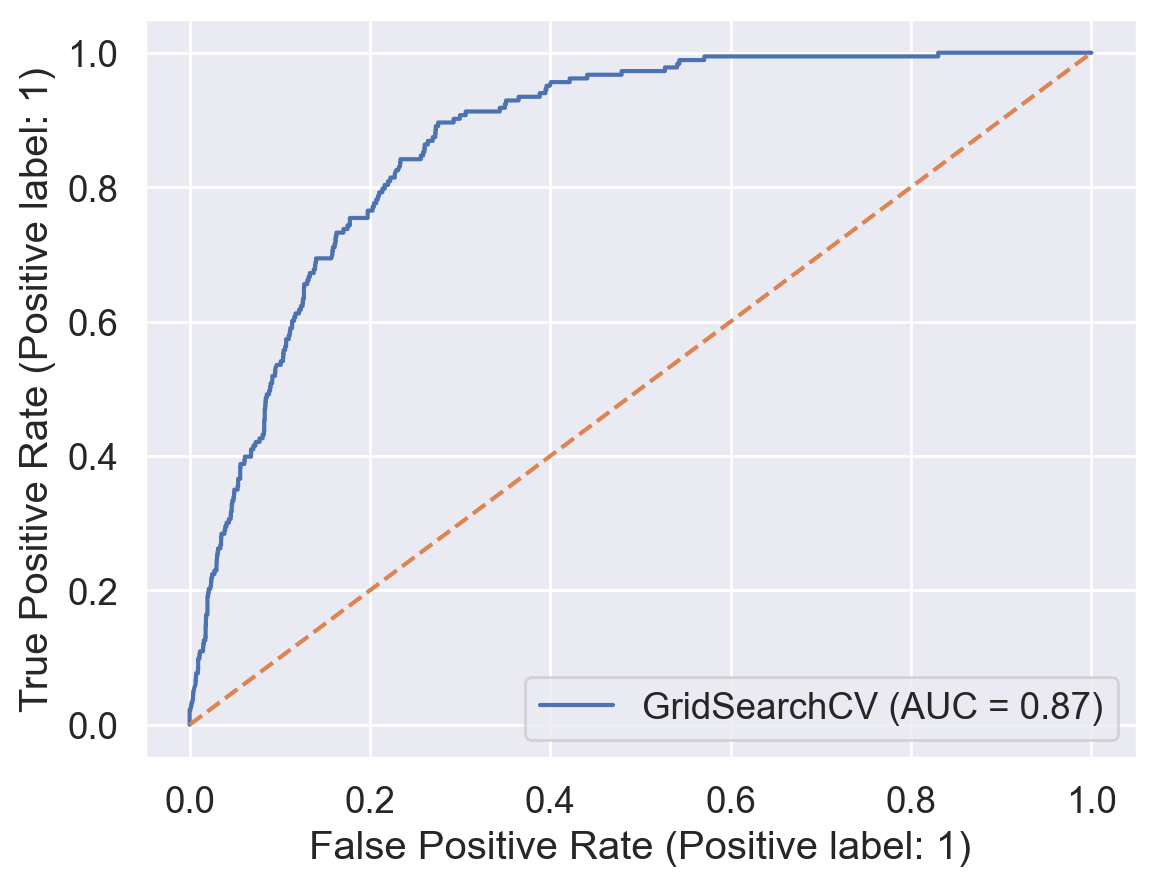

In [105]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(fitted_model,X_test,y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

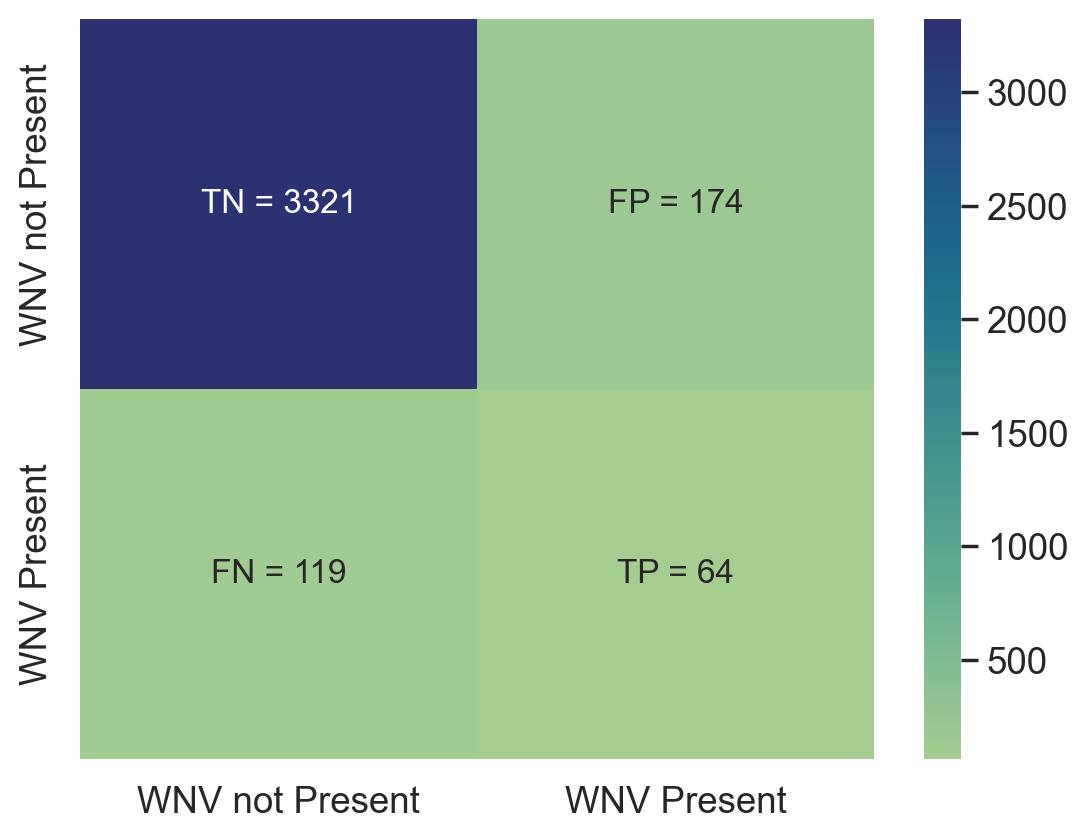

In [106]:
# plot confusion matrix
cm = confusion_matrix(y_test,fitted_model.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['WNV not Present', 'WNV Present'],
    yticklabels=['WNV not Present', 'WNV Present']
)

In [107]:
coef = fitted_model.best_estimator_['cb_clf'].feature_importances_
feature = fitted_model.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

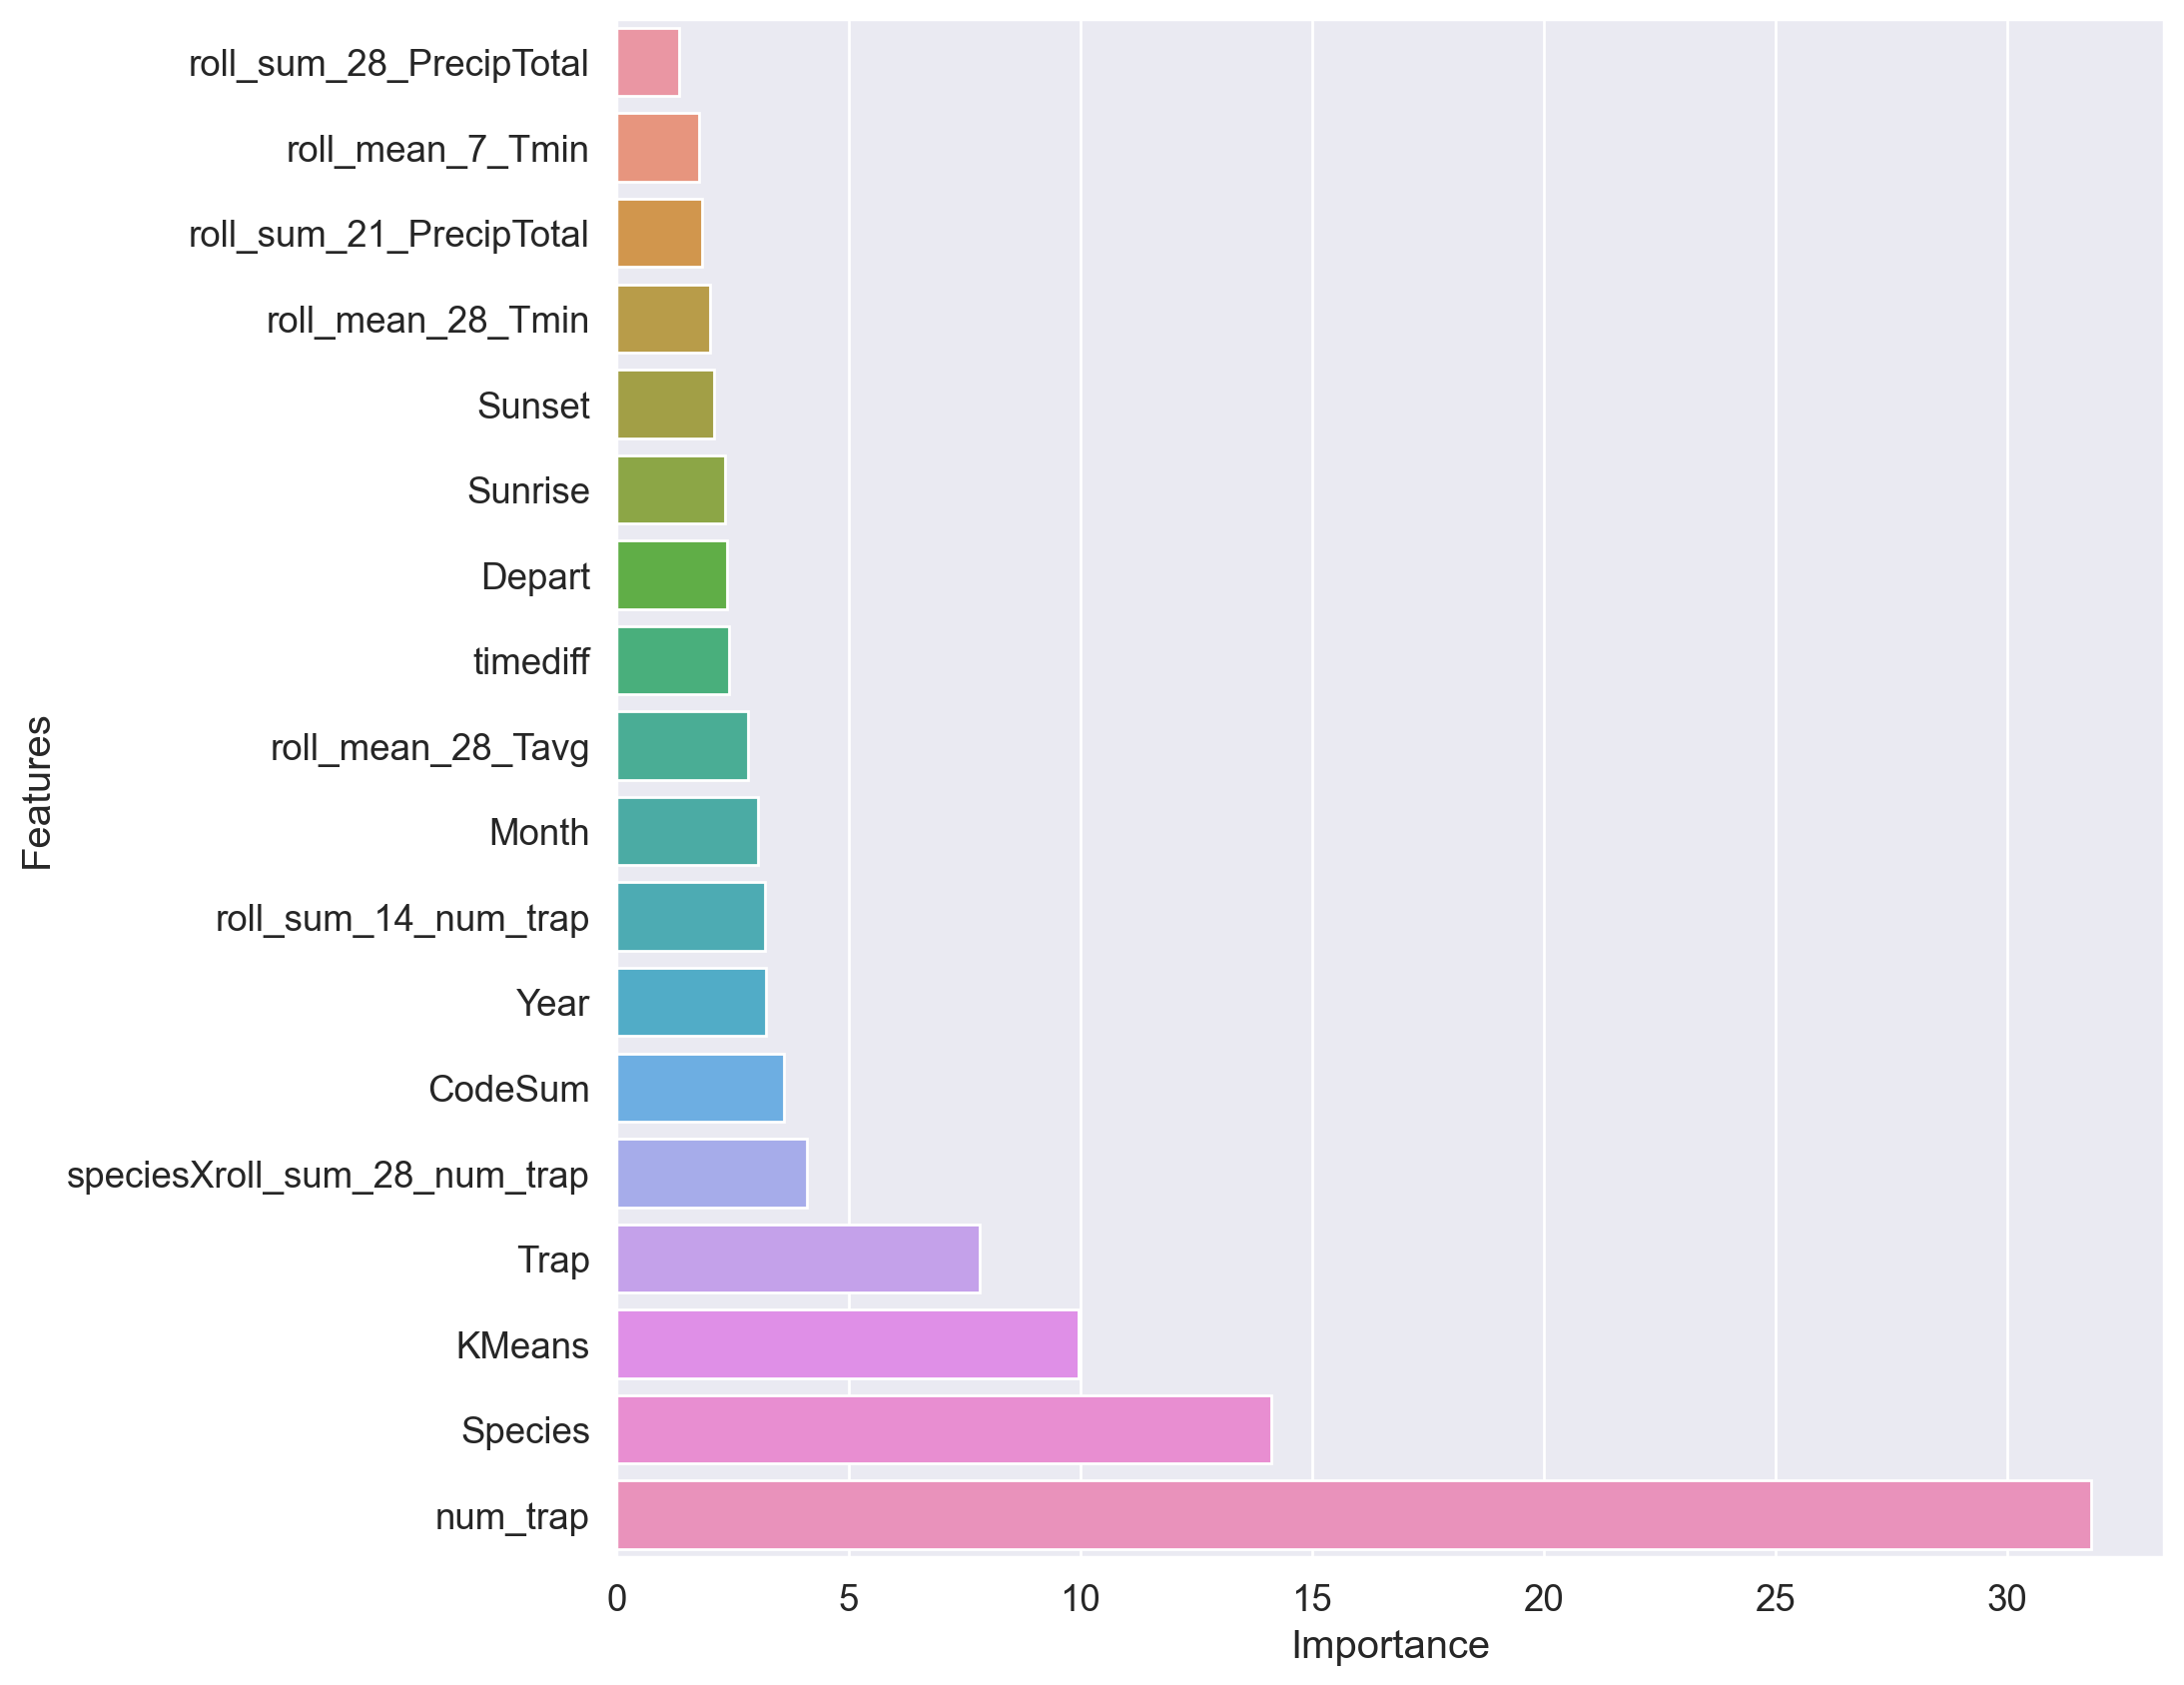

In [108]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(50, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

<a id='gb'></a>

### GradientBoosting Classifier

In [109]:
pipe_gb = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
    ('gb_clf', GradientBoostingClassifier())
])

In [110]:
pipe_gb.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('gb_clf', GradientBoostingClassifier())])

In [111]:
pipe_gb.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()),
  ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
  ('gb_clf', GradientBoostingClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'sampling': SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
 'gb_clf': GradientBoostingClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'sampling__smote': None,
 'sampling__tomek__n_jobs': None,
 'sampling__tomek__sampling_strategy': 'majority',
 'sampling__tomek': TomekLinks(sampling_strategy='majority'),
 'gb_clf__ccp_alpha': 0.0,
 'gb_clf__criterion': 'friedman_mse',
 'gb_clf__init': None,
 'gb_clf__learning_rate': 0.1,
 'gb_clf__loss': 'log_loss',
 'gb_clf__max_depth': 3,
 'gb_clf__max_features': None,
 'gb_clf__max_leaf_nodes': None,
 'gb_clf__min_impurity_decrease': 0.0,
 'gb_clf__min_samples_leaf': 1,
 'gb_clf__min_sample

In [112]:
pipe_gb_params = {
    'sampling__sampling_strategy': [1.0], # ['all', auto', 'minority', 'not minority', 0.5]     
    'sampling__random_state': [42],
    'gb_clf__loss': ['log_loss', 'exponential'], # ['log_loss', 'exponential']
    'gb_clf__learning_rate': [0.5, 1, 2, 5, 10], # [1.0,2.0,5.0,10.0], default=1.0, [0.0,inf]
    'gb_clf__n_estimators': [50,100], # [50,100,200], default=100, [1, inf]
    'gb_clf__subsample': [0.8,1.0], # [0.5, 0.8, 1.0], default=1.0, [0.0, 1.0]
    'gb_clf__random_state': [42]
}

In [113]:
pipe_gb_gridsearch = GridSearchCV(pipe_gb, pipe_gb_params, scoring='roc_auc', cv=5,verbose=3)

In [114]:
pipe_gb_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END gb_clf__learning_rate=0.5, gb_clf__loss=log_loss, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.810 total time=   1.1s
[CV 2/5] END gb_clf__learning_rate=0.5, gb_clf__loss=log_loss, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.829 total time=   1.1s
[CV 3/5] END gb_clf__learning_rate=0.5, gb_clf__loss=log_loss, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.843 total time=   1.1s
[CV 4/5] END gb_clf__learning_rate=0.5, gb_clf__loss=log_loss, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.800 total time=   1.1s
[CV 5/5] END gb_clf__learn

[CV 2/5] END gb_clf__learning_rate=0.5, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.837 total time=   2.5s
[CV 3/5] END gb_clf__learning_rate=0.5, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.850 total time=   2.5s
[CV 4/5] END gb_clf__learning_rate=0.5, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.814 total time=   2.5s
[CV 5/5] END gb_clf__learning_rate=0.5, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.831 total time=   2.5s
[CV 1/5] END gb_clf__learning_rate=1, gb_clf__loss=log_loss, gb_clf__n_e

[CV 3/5] END gb_clf__learning_rate=1, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.841 total time=   2.1s
[CV 4/5] END gb_clf__learning_rate=1, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.802 total time=   2.1s
[CV 5/5] END gb_clf__learning_rate=1, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.827 total time=   2.1s
[CV 1/5] END gb_clf__learning_rate=1, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.790 total time=   2.5s
[CV 2/5] END gb_clf__learning_rate=1, gb_clf__loss=exponential, gb_clf__n_estima

[CV 4/5] END gb_clf__learning_rate=2, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.773 total time=   1.3s
[CV 5/5] END gb_clf__learning_rate=2, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.817 total time=   1.3s
[CV 1/5] END gb_clf__learning_rate=2, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.787 total time=   2.1s
[CV 2/5] END gb_clf__learning_rate=2, gb_clf__loss=exponential, gb_clf__n_estimators=100, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.790 total time=   2.1s
[CV 3/5] END gb_clf__learning_rate=2, gb_clf__loss=exponential, gb_clf__n_estimato

[CV 5/5] END gb_clf__learning_rate=5, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.751 total time=   1.1s
[CV 1/5] END gb_clf__learning_rate=5, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.770 total time=   1.3s
[CV 2/5] END gb_clf__learning_rate=5, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.780 total time=   1.3s
[CV 3/5] END gb_clf__learning_rate=5, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=1.0, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.740 total time=   1.3s
[CV 4/5] END gb_clf__learning_rate=5, gb_clf__loss=exponential, gb_clf__n_estimators

[CV 1/5] END gb_clf__learning_rate=10, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.660 total time=   1.1s
[CV 2/5] END gb_clf__learning_rate=10, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.613 total time=   1.1s
[CV 3/5] END gb_clf__learning_rate=10, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.643 total time=   1.1s
[CV 4/5] END gb_clf__learning_rate=10, gb_clf__loss=exponential, gb_clf__n_estimators=50, gb_clf__random_state=42, gb_clf__subsample=0.8, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.735 total time=   1.1s
[CV 5/5] END gb_clf__learning_rate=10, gb_clf__loss=exponential, gb_clf__n_estim

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling',
                                        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                                       ('gb_clf',
                                        GradientBoostingClassifier())]),
             param_grid={'gb_clf__learning_rate': [0.5, 1, 2, 5, 10],
                         'gb_clf__loss': ['log_loss', 'exponential'],
                         'gb_clf__n_estimators': [50, 100],
                         'gb_clf__random_state': [42],
                         'gb_clf__subsample': [0.8, 1.0],
                         'sampling__random_state': [42],
                         'sampling__sampling_strategy': [1.0]},
             scoring='roc_auc', verbose=3)

In [115]:
# Print out best estimator.
pipe_gb_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(random_state=42, sampling_strategy=1.0,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('gb_clf',
                 GradientBoostingClassifier(learning_rate=0.5,
                                            loss='exponential', n_estimators=50,
                                            random_state=42))])

In [116]:
# Print out best score.
# Mean cross-validated score of the best_estimator
pipe_gb_gridsearch.best_score_

0.8394175761070031

In [117]:
# Evaluate the best model on the test data (accuracy score)
pipe_gb_gridsearch.score(X_test, y_test)

0.8711328439535011

In [118]:
fitted_model = pipe_gb_gridsearch

# ROC-AUC
pred_prob_train = fitted_model.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train[:,1])
pred_prob_test = fitted_model.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, fitted_model.predict(X_test)))

ROC-AUC on training set: 0.9104892986943061
ROC-AUC on testing set: 0.8711328439535011

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3495
           1       0.23      0.52      0.31       183

    accuracy                           0.89      3678
   macro avg       0.60      0.71      0.63      3678
weighted avg       0.94      0.89      0.91      3678



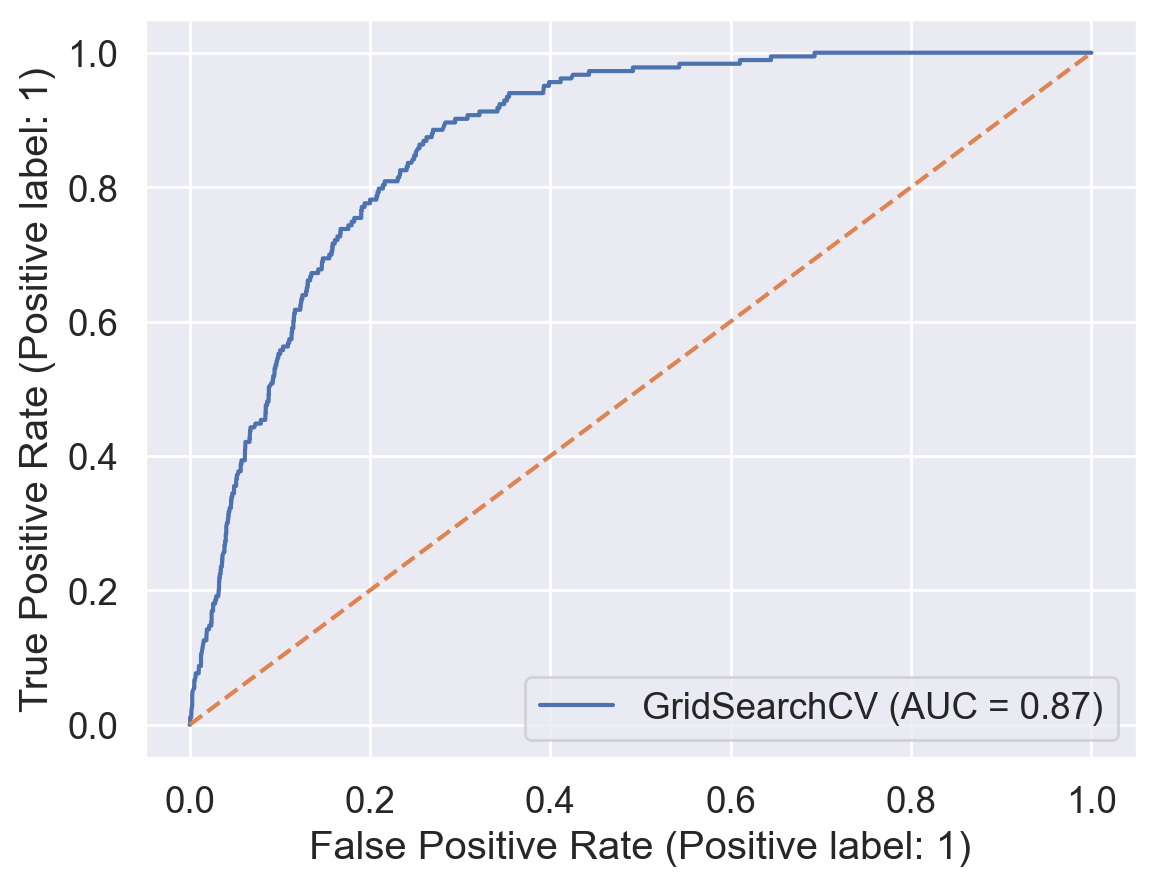

In [119]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(fitted_model, X_test, y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

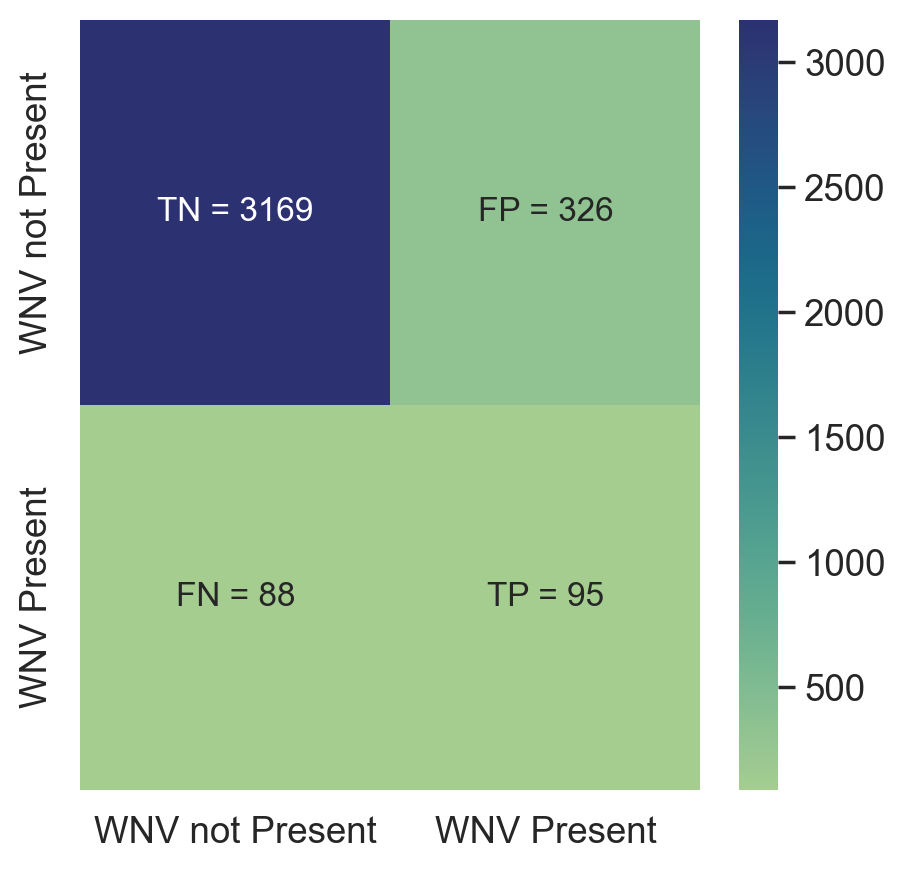

In [120]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test,fitted_model.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(5,5))
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['WNV not Present', 'WNV Present'],
    yticklabels=['WNV not Present', 'WNV Present']
)

In [121]:
coef = fitted_model.best_estimator_['gb_clf'].feature_importances_
feature = fitted_model.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

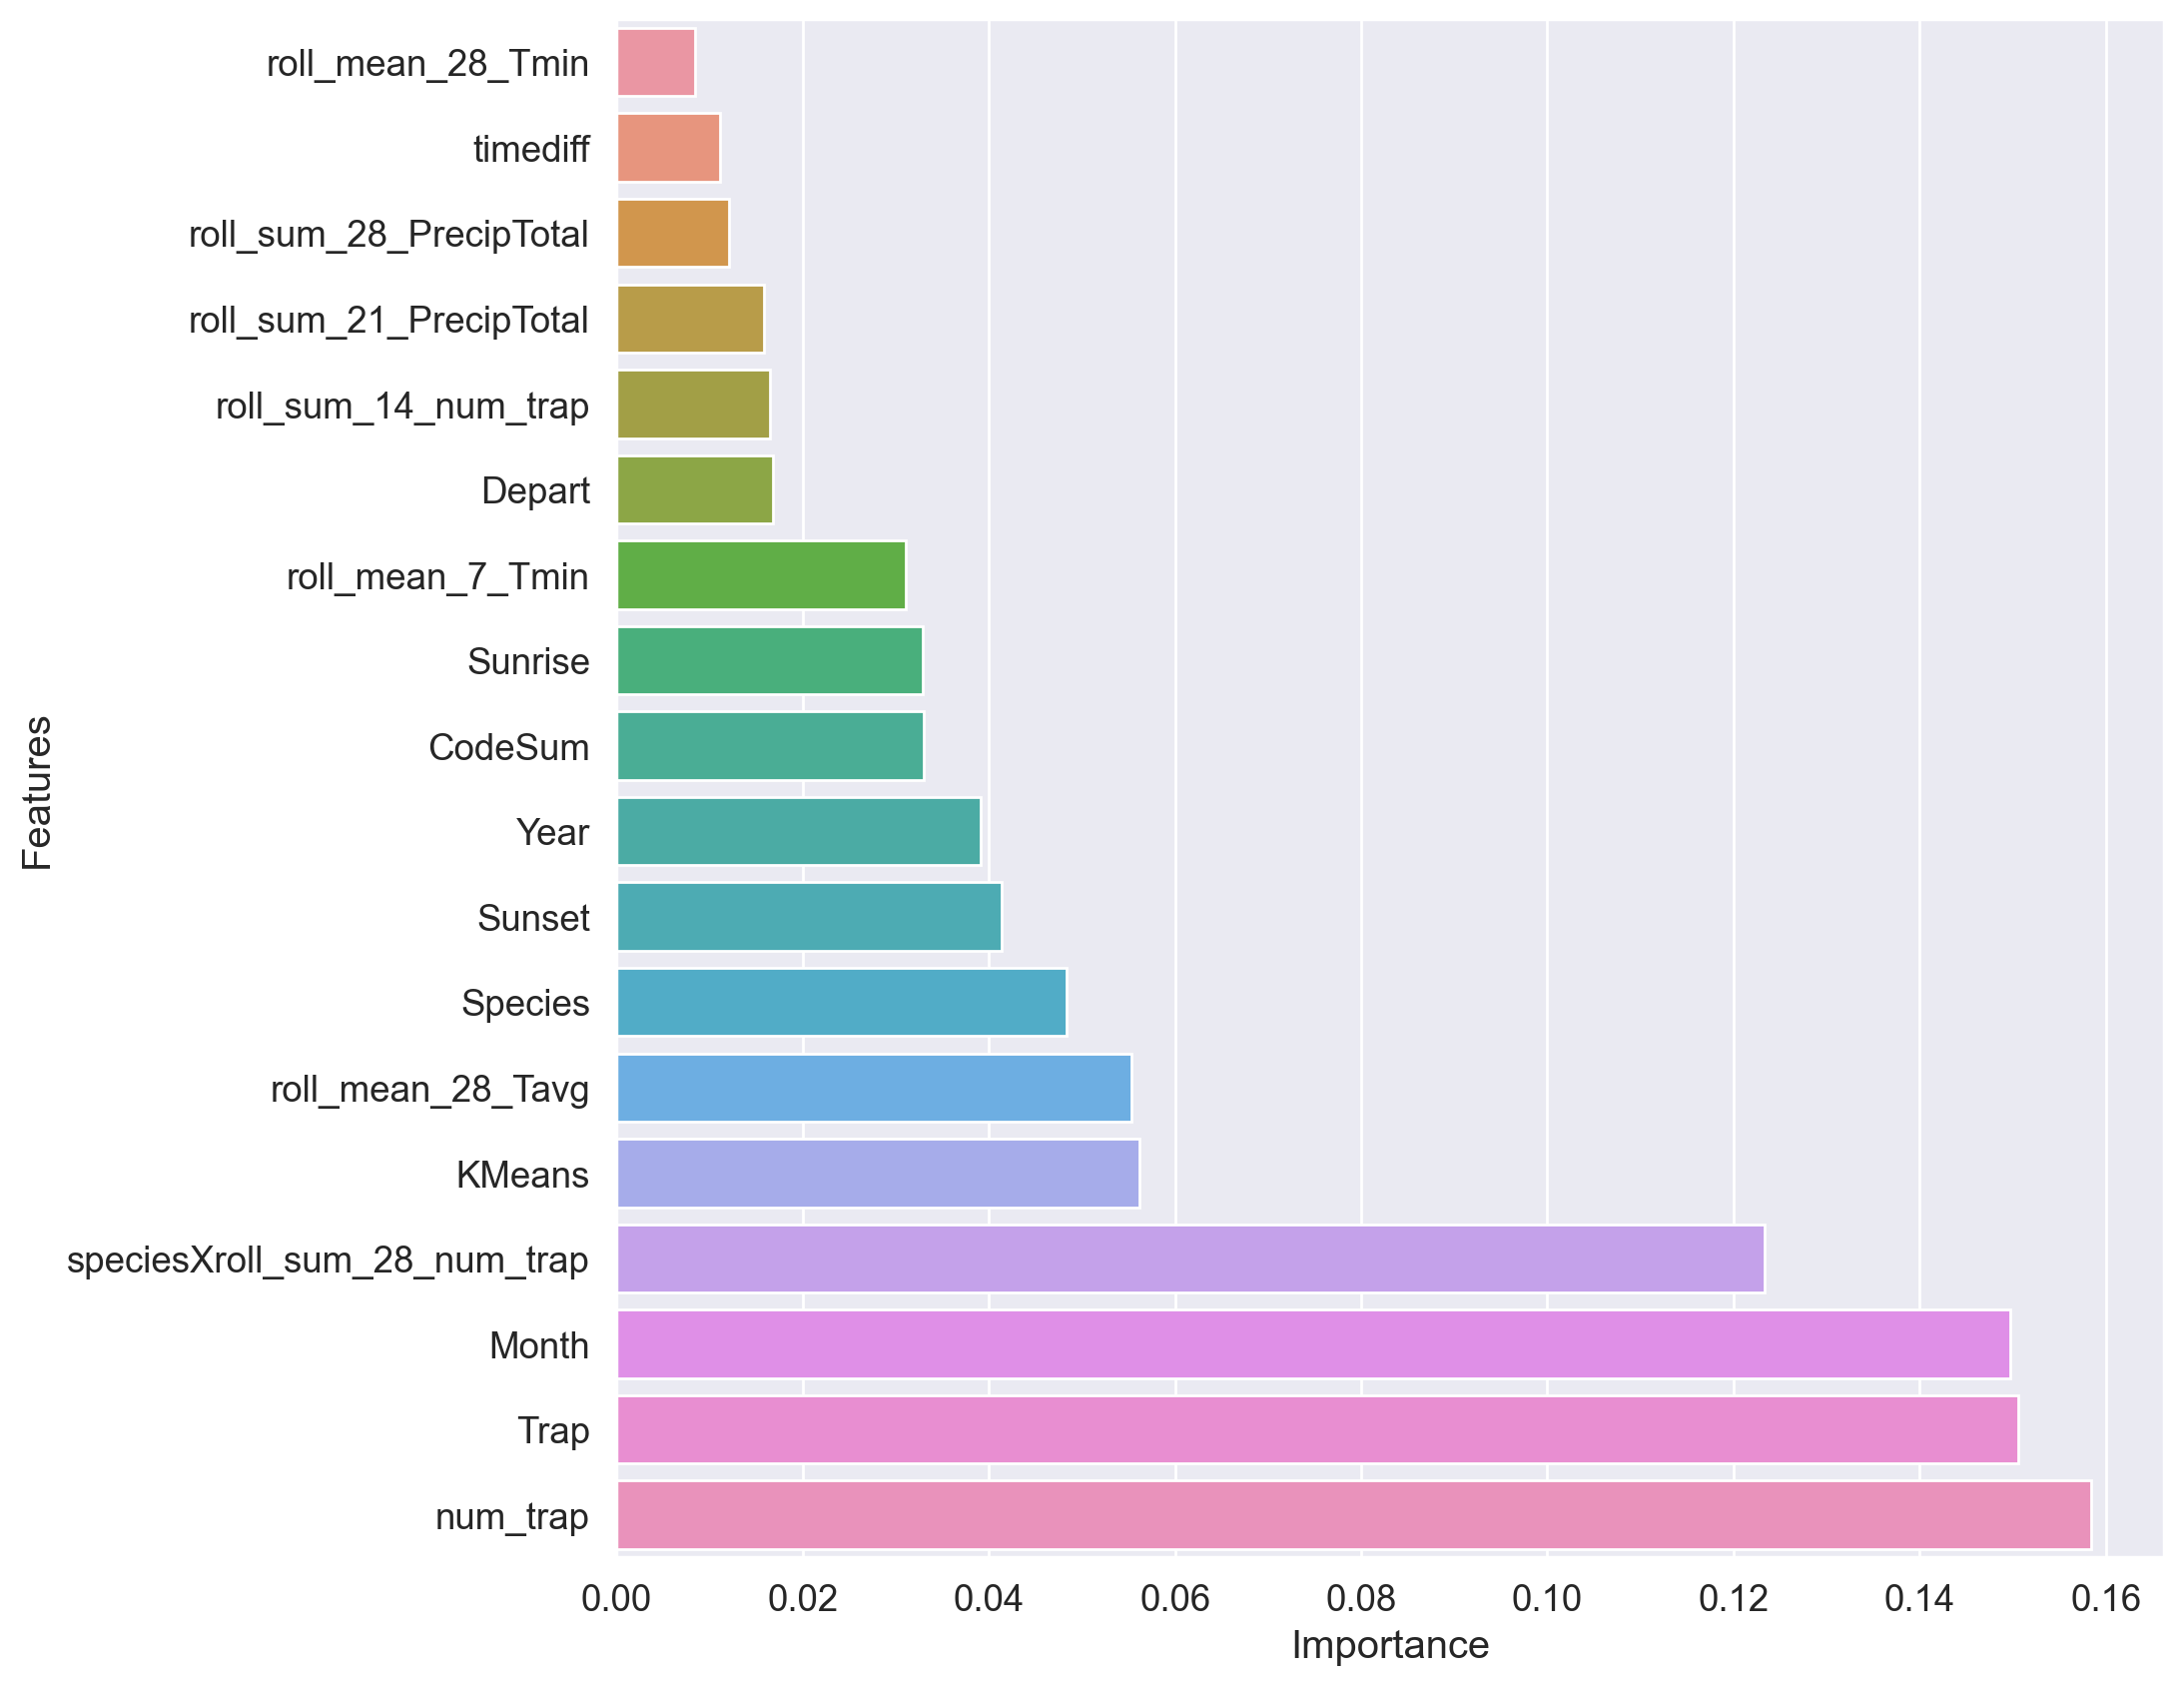

In [122]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(50, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

<a id='lr'></a>

### Logistic Regression

In [151]:
pipe_lr = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
    ('lr', LogisticRegression())
])

In [152]:
pipe_lr.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('lr', LogisticRegression())])

In [153]:
pipe_lr.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()),
  ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
  ('lr', LogisticRegression())],
 'verbose': False,
 'ss': StandardScaler(),
 'sampling': SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
 'lr': LogisticRegression(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'sampling__smote': None,
 'sampling__tomek__n_jobs': None,
 'sampling__tomek__sampling_strategy': 'majority',
 'sampling__tomek': TomekLinks(sampling_strategy='majority'),
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [154]:
pipe_lr_params = {
    'sampling__sampling_strategy': [1.0], # ['all', auto', 'minority', 'not minority', 0.5]     
    'sampling__random_state': [42],
    'lr__C': [0.5,1,5],
     'lr__max_iter': [100],
     'lr__penalty': ['l1', 'l2', 'elasticnet', None],
     'lr__random_state': [42],
     'lr__solver': ['saga'],
}

In [155]:
pipe_lr_gridsearch = GridSearchCV(pipe_lr, pipe_lr_params, scoring='roc_auc',cv=5,verbose=3)

In [156]:
pipe_lr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END lr__C=0.5, lr__max_iter=100, lr__penalty=l1, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.838 total time=   0.2s
[CV 2/5] END lr__C=0.5, lr__max_iter=100, lr__penalty=l1, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.859 total time=   0.3s
[CV 3/5] END lr__C=0.5, lr__max_iter=100, lr__penalty=l1, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.852 total time=   0.3s
[CV 4/5] END lr__C=0.5, lr__max_iter=100, lr__penalty=l1, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.826 total time=   0.3s
[CV 5/5] END lr__C=0.5, lr__max_iter=100, lr__penalty=l1, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.843 total time=   0.3s

/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END lr__C=0.5, lr__max_iter=100, lr__penalty=None, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.859 total time=   0.3s


/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END lr__C=0.5, lr__max_iter=100, lr__penalty=None, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.853 total time=   0.3s


/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END lr__C=0.5, lr__max_iter=100, lr__penalty=None, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.825 total time=   0.3s


/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END lr__C=0.5, lr__max_iter=100, lr__penalty=None, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.843 total time=   0.3s
[CV 1/5] END lr__C=1, lr__max_iter=100, lr__penalty=l1, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.838 total time=   0.3s
[CV 2/5] END lr__C=1, lr__max_iter=100, lr__penalty=l1, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.859 total time=   0.3s
[CV 3/5] END lr__C=1, lr__max_iter=100, lr__penalty=l1, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.853 total time=   0.3s
[CV 4/5] END lr__C=1, lr__max_iter=100, lr__penalty=l1, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.826 total time=   0.3s
[CV 5/5] END lr__C=1, lr__max_iter=100, lr__penalty=l1, lr__random

/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END lr__C=5, lr__max_iter=100, lr__penalty=None, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.859 total time=   0.3s


/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END lr__C=5, lr__max_iter=100, lr__penalty=None, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.853 total time=   0.3s


/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END lr__C=5, lr__max_iter=100, lr__penalty=None, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.825 total time=   0.3s


/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/edenng/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/edenng/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py", line 297, in fit
   

[CV 5/5] END lr__C=5, lr__max_iter=100, lr__penalty=None, lr__random_state=42, lr__solver=saga, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.843 total time=   0.3s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling',
                                        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.5, 1, 5], 'lr__max_iter': [100],
                         'lr__penalty': ['l1', 'l2', 'elasticnet', None],
                         'lr__random_state': [42], 'lr__solver': ['saga'],
                         'sampling__random_state': [42],
                         'sampling__sampling_strategy': [1.0]},
             scoring='roc_auc', verbose=3)

In [157]:
# Print out best estimator.
pipe_lr_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(random_state=42, sampling_strategy=1.0,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('lr',
                 LogisticRegression(C=1, random_state=42, solver='saga'))])

In [158]:
# Print out best score.
# Mean cross-validated score of the best_estimator
pipe_lr_gridsearch.best_score_

0.8437344613793997

In [159]:
# Evaluate the best model on the test data (accuracy score)
pipe_lr_gridsearch.score(X_test, y_test)

0.8607362586677297

In [160]:
fitted_model = pipe_lr_gridsearch

# ROC-AUC
pred_prob_train = fitted_model.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train[:,1])
pred_prob_test = fitted_model.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, fitted_model.predict(X_test)))

ROC-AUC on training set: 0.8521785401803742
ROC-AUC on testing set: 0.8607362586677297

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      3495
           1       0.14      0.81      0.25       183

    accuracy                           0.75      3678
   macro avg       0.57      0.78      0.55      3678
weighted avg       0.95      0.75      0.82      3678



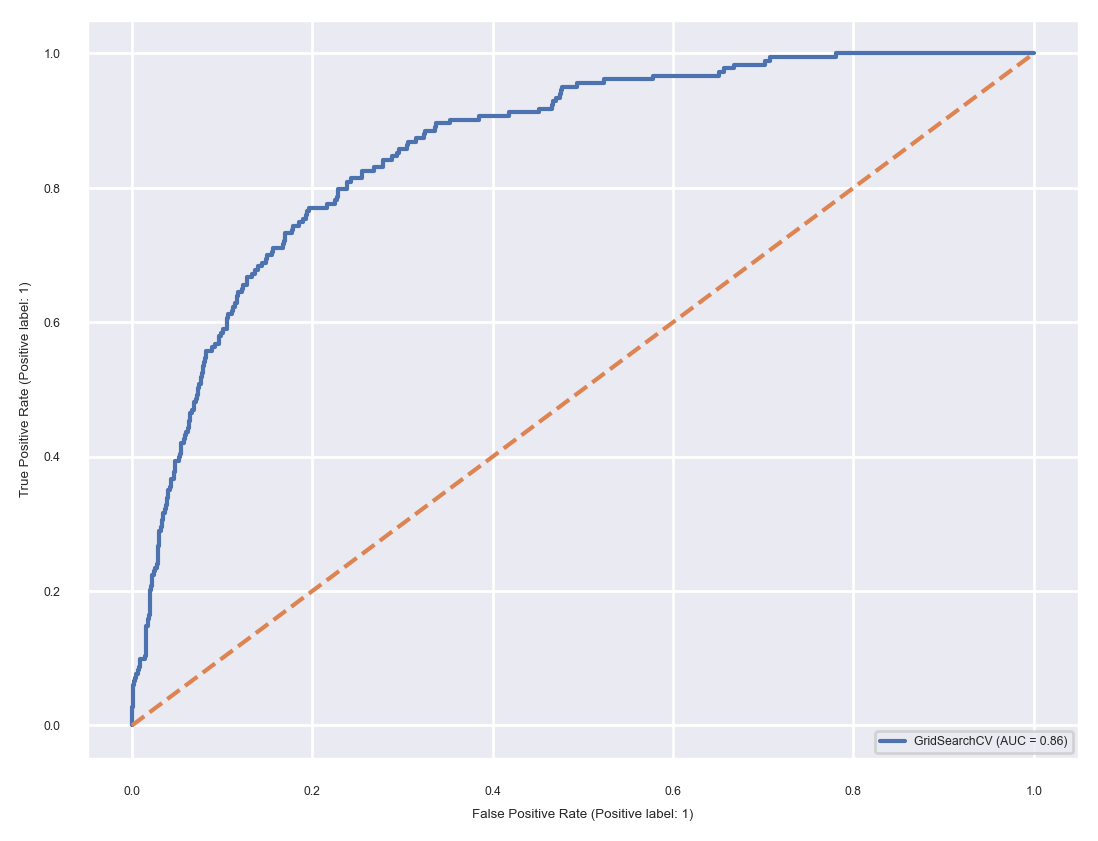

In [161]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(fitted_model,X_test,y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

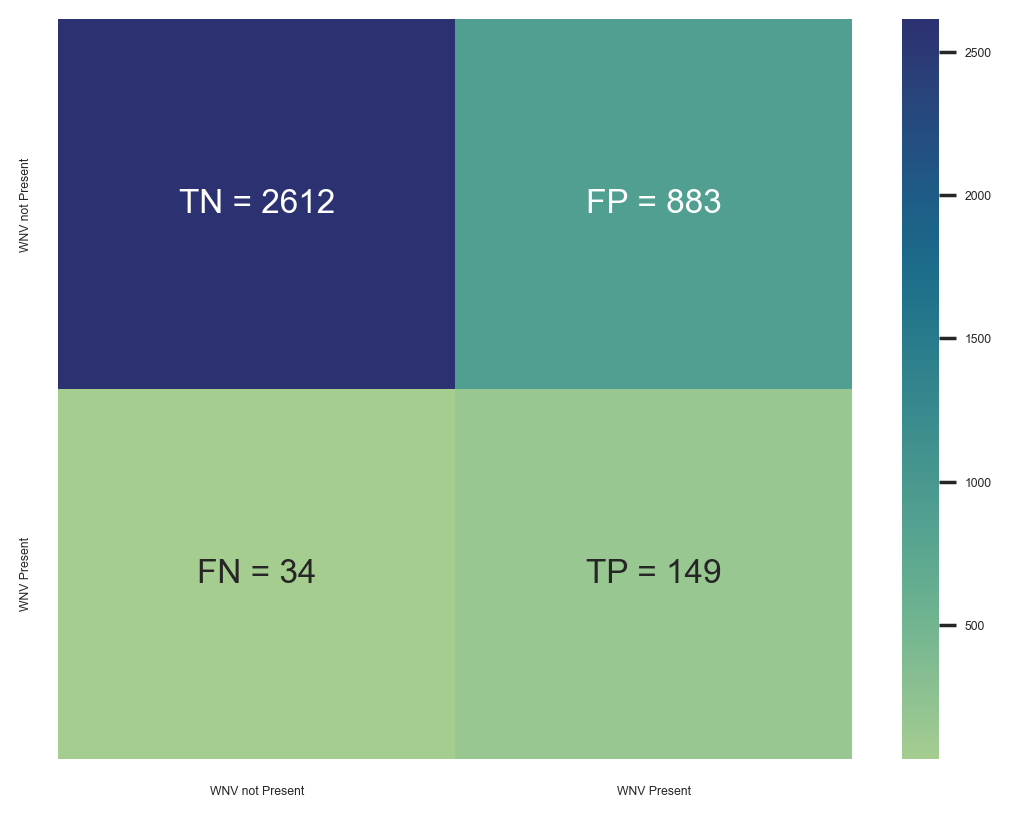

In [162]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test,fitted_model.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['WNV not Present','WNV Present'],
    yticklabels=['WNV not Present','WNV Present']
)

In [163]:
coef = fitted_model.best_estimator_['lr'].coef_[0]
feature = fitted_model.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

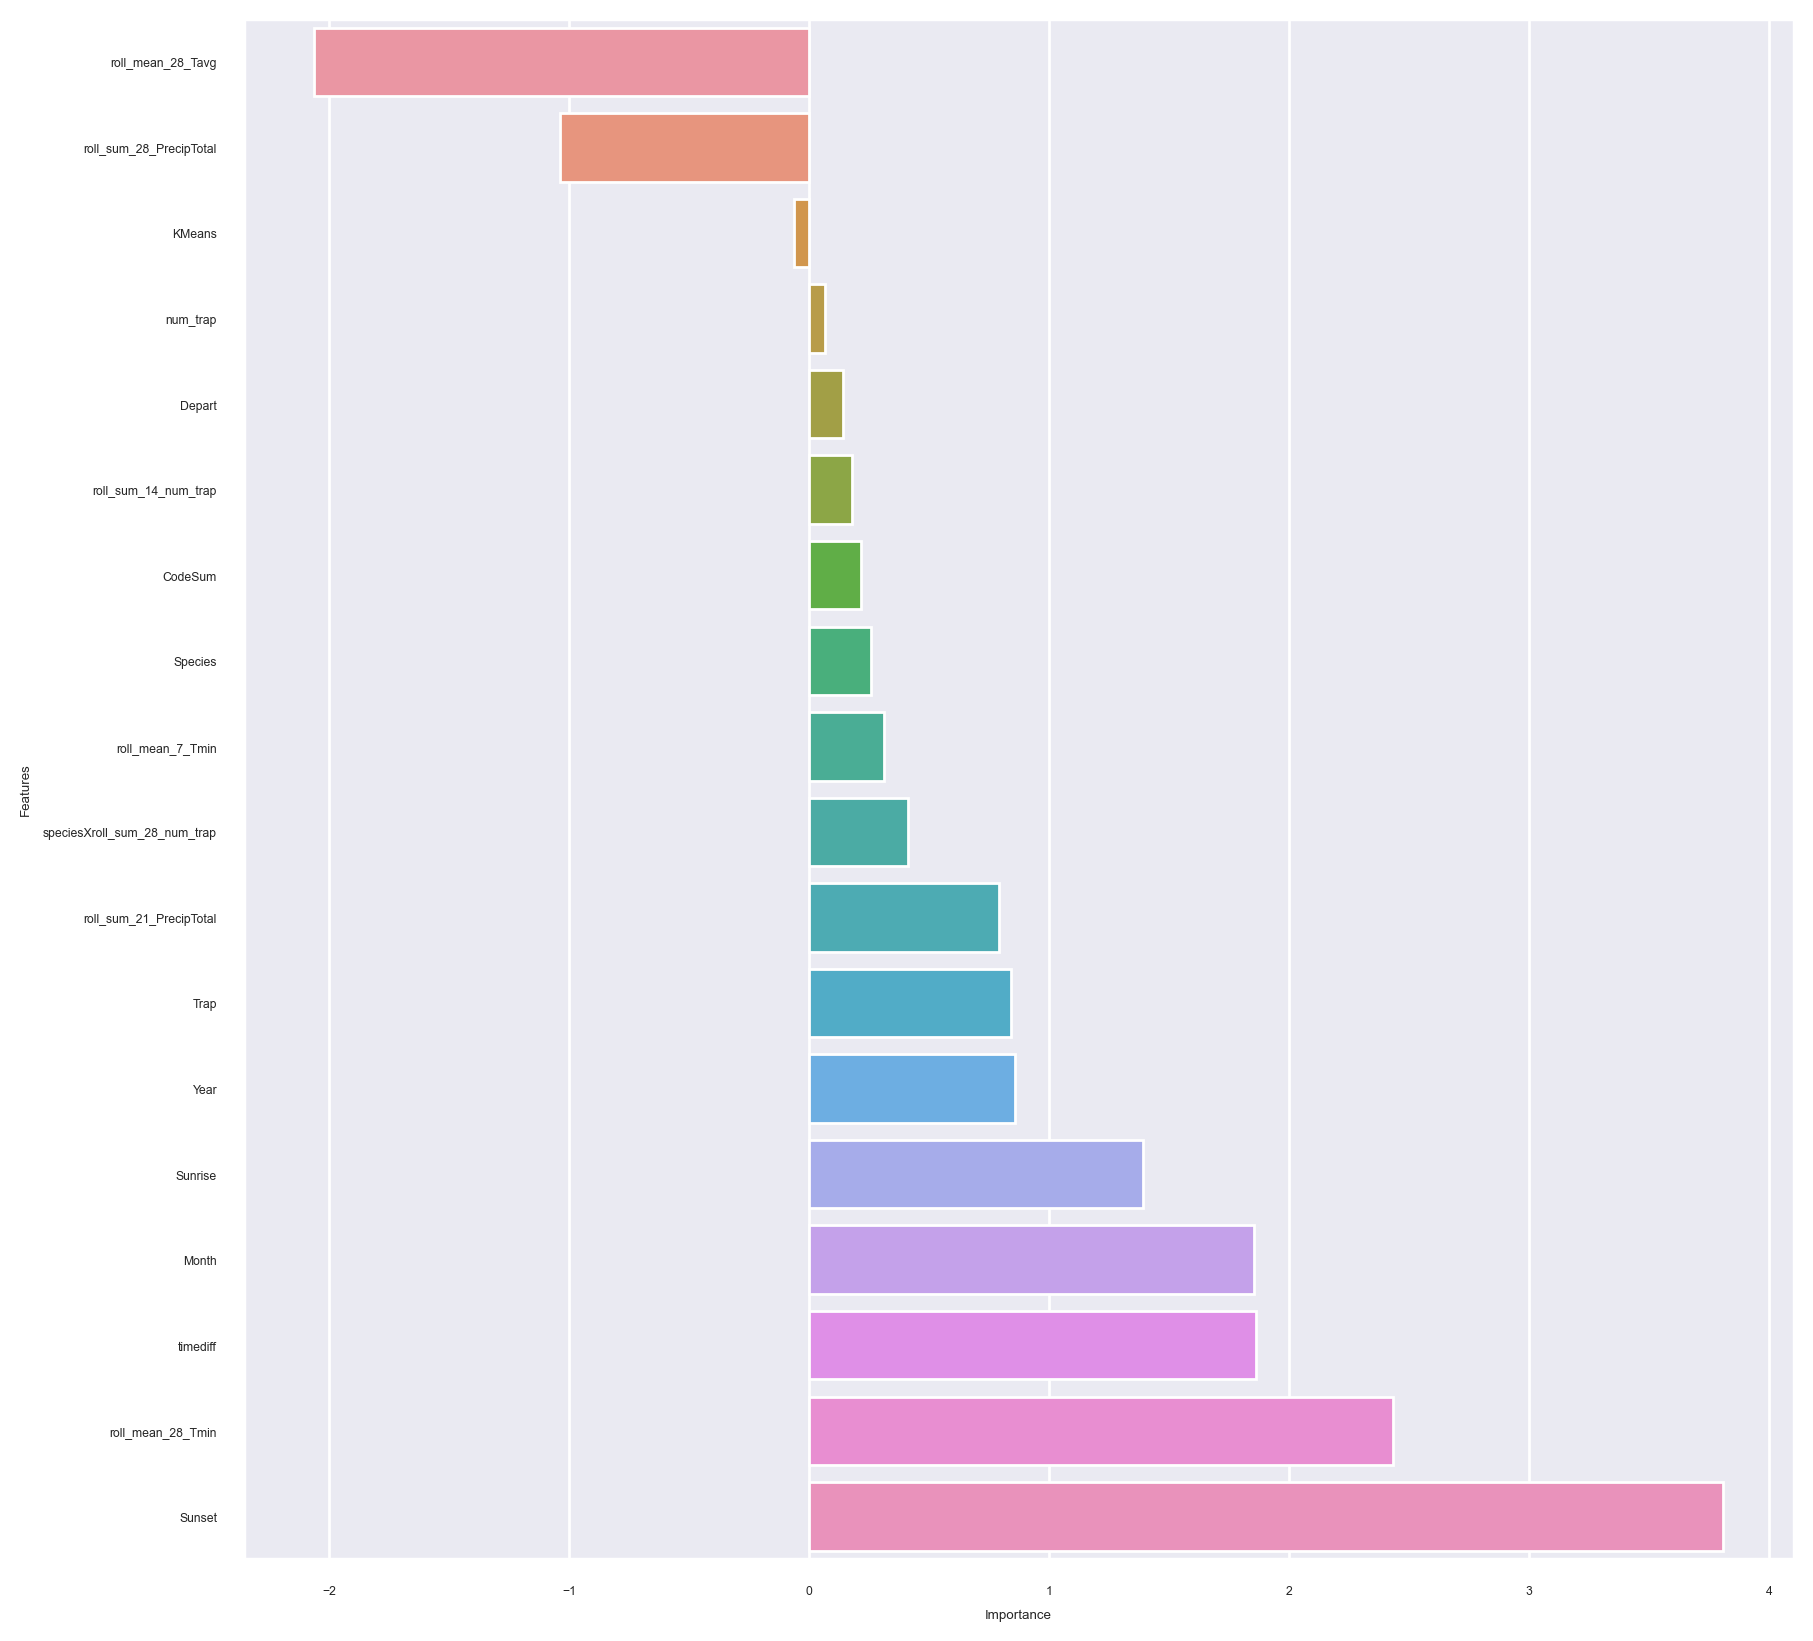

In [164]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(50, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

<a id='rf'></a>

### RandomForest Classifier

In [277]:
pipe_rf = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
    ('rf_clf', RandomForestClassifier())
])

In [278]:
pipe_rf.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('rf_clf', RandomForestClassifier())])

In [279]:
pipe_rf.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()),
  ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
  ('rf_clf', RandomForestClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'sampling': SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
 'rf_clf': RandomForestClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'sampling__smote': None,
 'sampling__tomek__n_jobs': None,
 'sampling__tomek__sampling_strategy': 'majority',
 'sampling__tomek': TomekLinks(sampling_strategy='majority'),
 'rf_clf__bootstrap': True,
 'rf_clf__ccp_alpha': 0.0,
 'rf_clf__class_weight': None,
 'rf_clf__criterion': 'gini',
 'rf_clf__max_depth': None,
 'rf_clf__max_features': 'sqrt',
 'rf_clf__max_leaf_nodes': None,
 'rf_clf__max_samples': None,
 'rf_clf__min_impurity_decrease': 0.0,
 'rf_clf__min_samples_leaf': 1,
 'rf_clf__min_samples_spl

In [285]:
pipe_rf_params = {
    'sampling__sampling_strategy': [1.0], # ['all', auto', 'minority', 'not minority', 0.5]     
    'sampling__random_state': [42],
    'rf_clf__n_estimators': [200], # [50,100,200, 300]
    'rf_clf__criterion': ['entropy'], # ['gini','entropy', 'log_loss']
    'rf_clf__max_features': ['log2'], # ['sqrt','log2']
    'rf_clf__random_state': [42],
}

In [286]:
pipe_rf_gridsearch = GridSearchCV(pipe_rf, pipe_rf_params, scoring='roc_auc',cv=5,verbose=3)

In [287]:
pipe_rf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END rf_clf__criterion=entropy, rf_clf__max_features=log2, rf_clf__n_estimators=200, rf_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.831 total time=   3.3s
[CV 2/5] END rf_clf__criterion=entropy, rf_clf__max_features=log2, rf_clf__n_estimators=200, rf_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.805 total time=   3.3s
[CV 3/5] END rf_clf__criterion=entropy, rf_clf__max_features=log2, rf_clf__n_estimators=200, rf_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.839 total time=   3.4s
[CV 4/5] END rf_clf__criterion=entropy, rf_clf__max_features=log2, rf_clf__n_estimators=200, rf_clf__random_state=42, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.798 total time=   3.4s
[CV 5/5] END rf_clf__criterion=entropy, rf_clf__max_features=log2, rf_clf__n_estimators=200, rf_clf__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling',
                                        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                                       ('rf_clf', RandomForestClassifier())]),
             param_grid={'rf_clf__criterion': ['entropy'],
                         'rf_clf__max_features': ['log2'],
                         'rf_clf__n_estimators': [200],
                         'rf_clf__random_state': [42],
                         'sampling__random_state': [42],
                         'sampling__sampling_strategy': [1.0]},
             scoring='roc_auc', verbose=3)

In [288]:
# Print out best estimator.
pipe_rf_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(random_state=42, sampling_strategy=1.0,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('rf_clf',
                 RandomForestClassifier(criterion='entropy',
                                        max_features='log2', n_estimators=200,
                                        random_state=42))])

In [289]:
# Print out best score.
# Mean cross-validated score of the best_estimator
pipe_rf_gridsearch.best_score_

0.8164499044614825

In [290]:
# Evaluate the best model on the test data (accuracy score)
pipe_rf_gridsearch.score(X_test, y_test)

0.835867007512684

In [291]:
fitted_model = pipe_rf_gridsearch

# ROC-AUC
pred_prob_train = fitted_model.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train[:,1])
pred_prob_test = fitted_model.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, fitted_model.predict(X_test)))

ROC-AUC on training set: 0.9921574236101763
ROC-AUC on testing set: 0.835867007512684

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      3495
           1       0.25      0.35      0.29       183

    accuracy                           0.91      3678
   macro avg       0.61      0.65      0.62      3678
weighted avg       0.93      0.91      0.92      3678



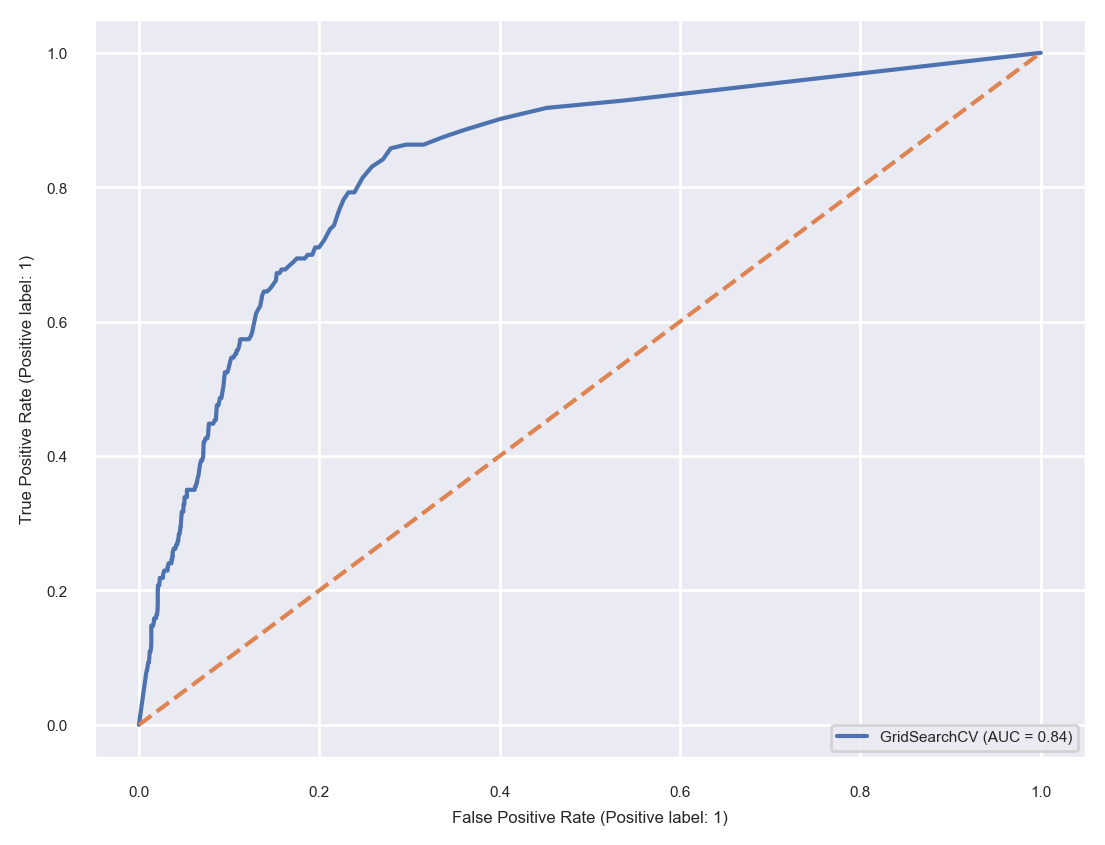

In [292]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(fitted_model,X_test,y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

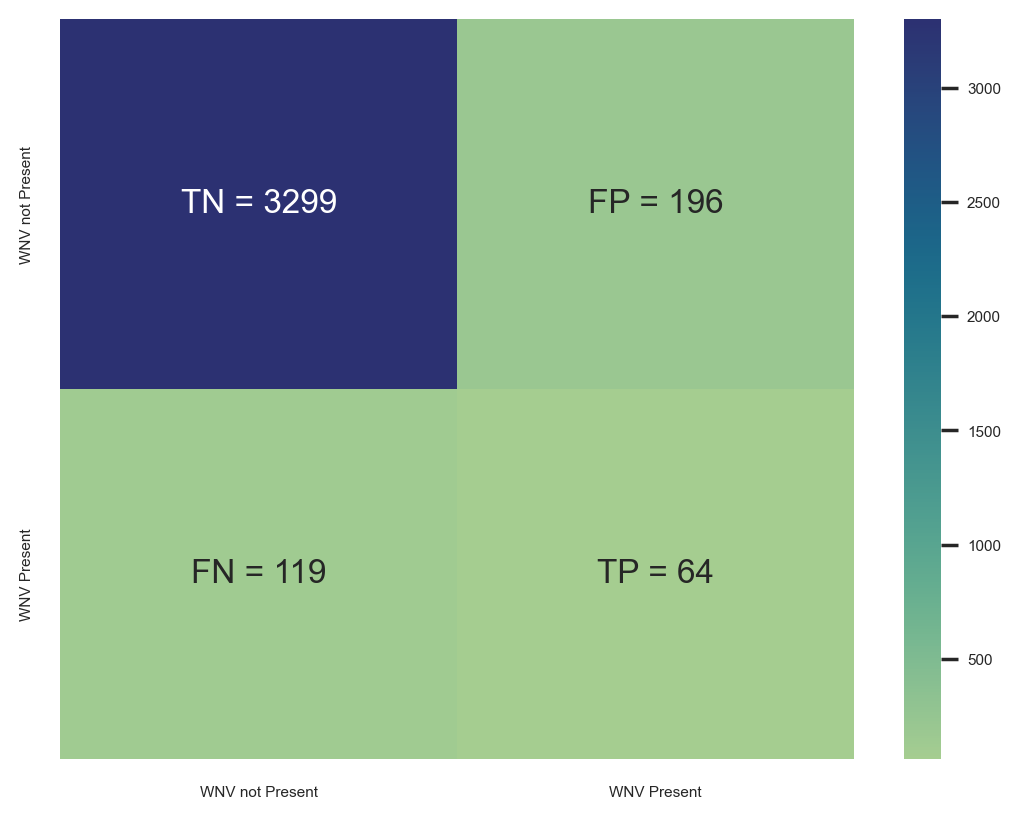

In [293]:
# plot confusion matrix
cm = confusion_matrix(y_test,fitted_model.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['WNV not Present', 'WNV Present'],
    yticklabels=['WNV not Present', 'WNV Present']
)

In [294]:
coef = fitted_model.best_estimator_['rf_clf'].feature_importances_
feature = fitted_model.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

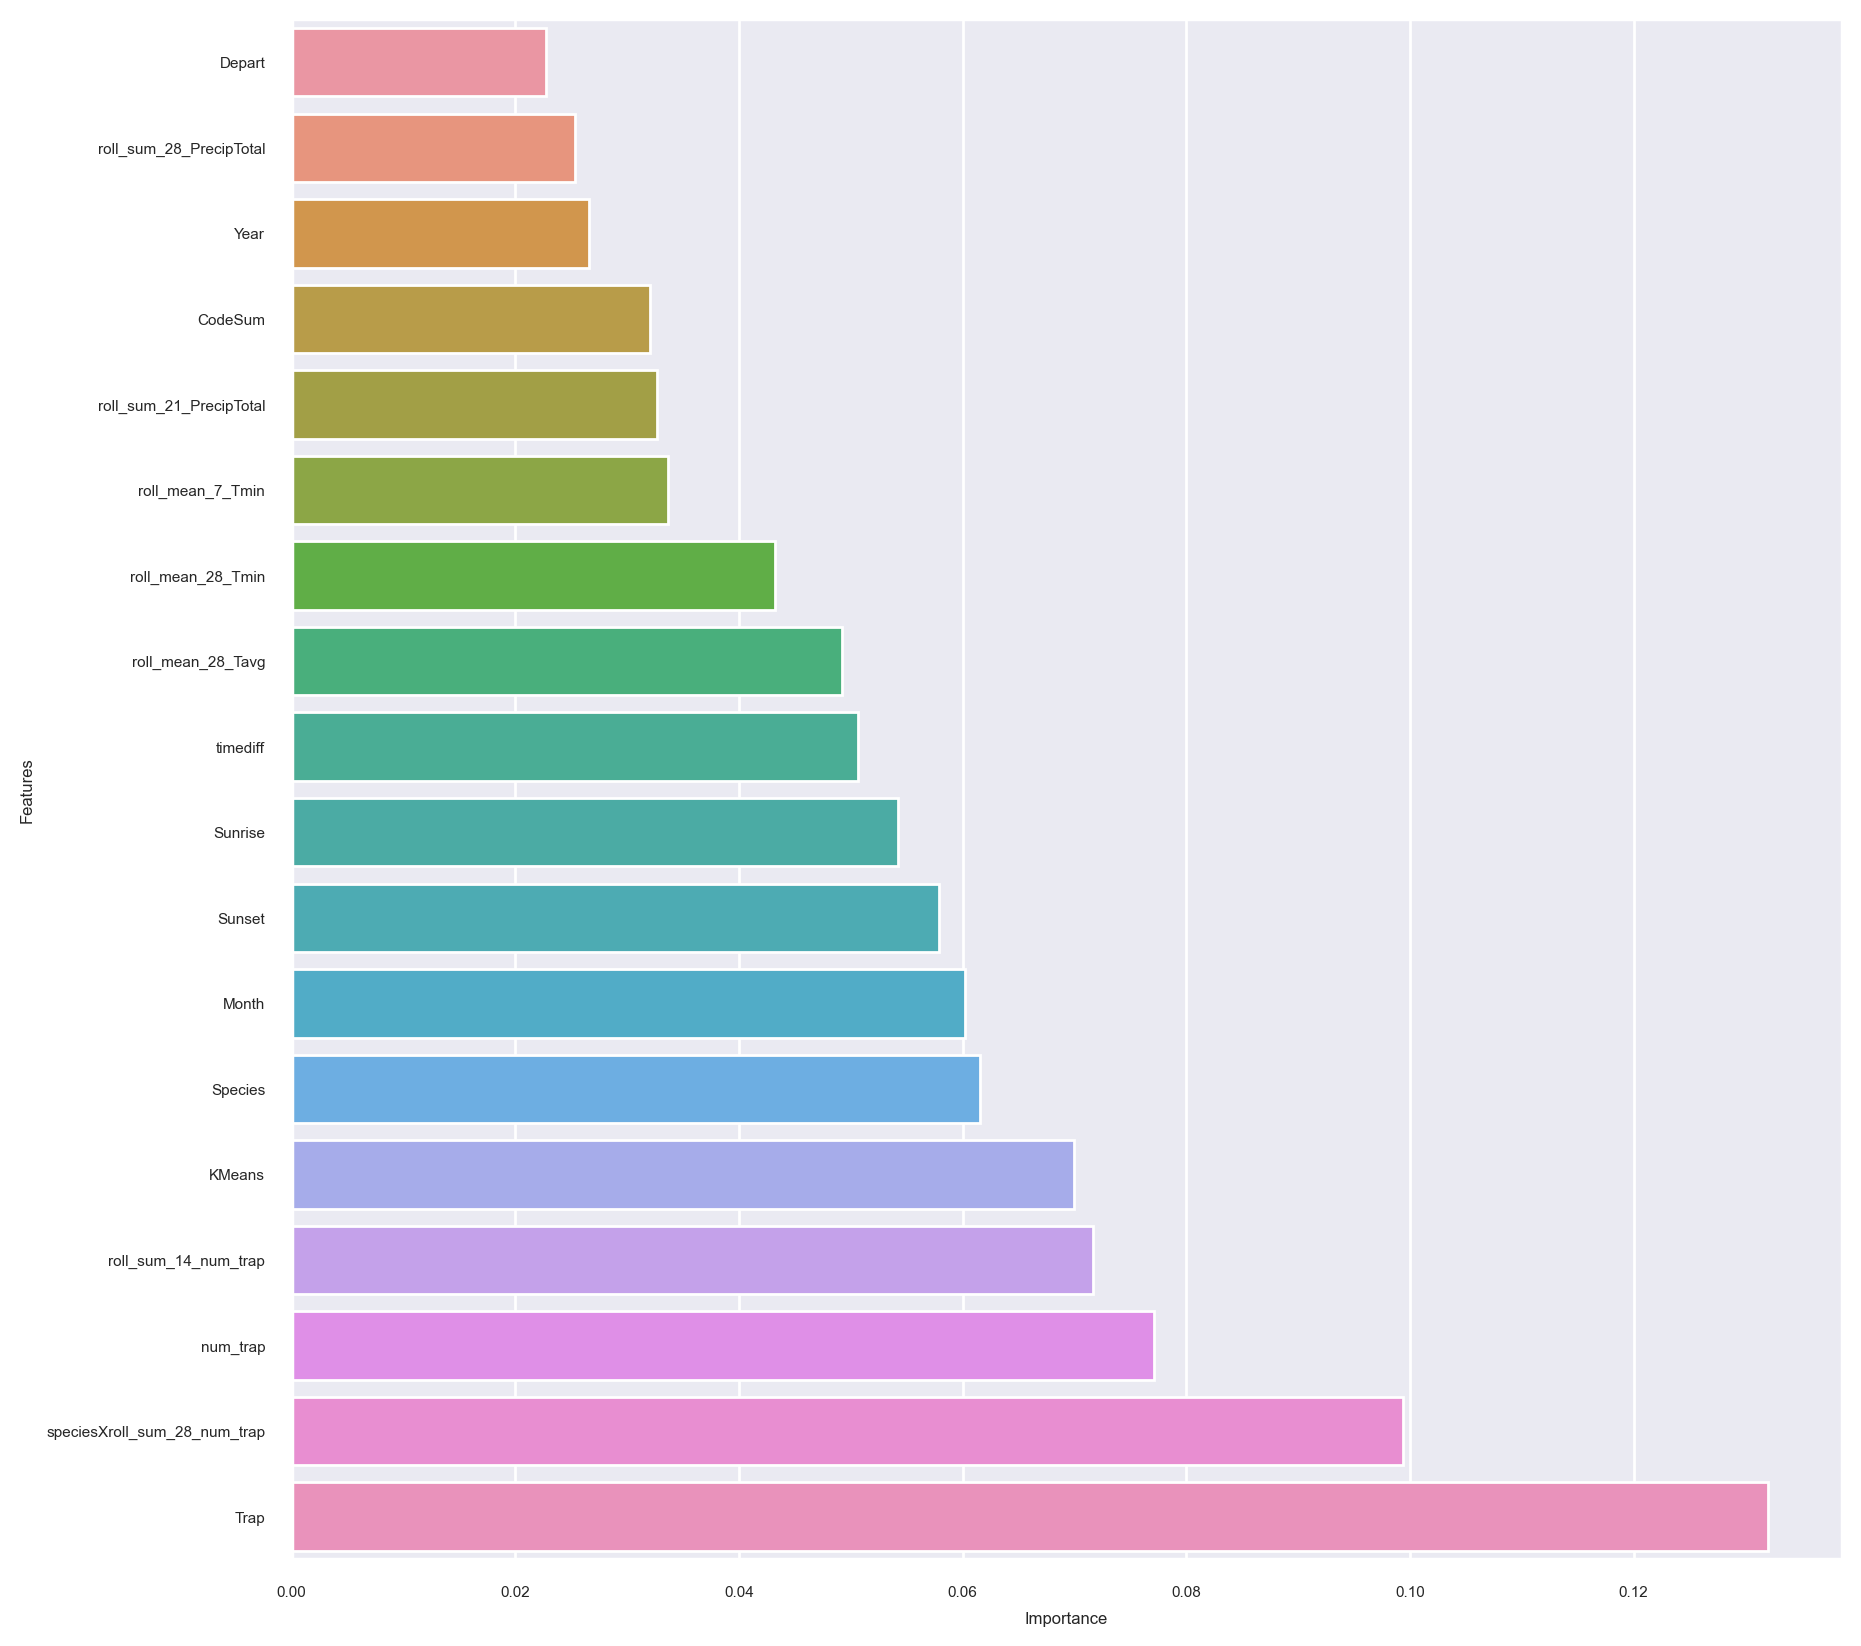

In [295]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(50, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

<a id='rgf'></a>

### RegularizedGreedyForest Classifier

In [167]:
pipe_rgf = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
    ('rgf_clf', RGFClassifier())
])

/Users/edenng/anaconda3/lib/python3.10/site-packages/rgf/utils.py:224: UserWarning: Cannot find FastRGF executable files. FastRGF estimators will be unavailable for usage.
  warnings.warn("Cannot find FastRGF executable files. "


In [168]:
pipe_rgf.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('rgf_clf', RGFClassifier())])

In [169]:
pipe_rgf.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()),
  ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
  ('rgf_clf', RGFClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'sampling': SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
 'rgf_clf': RGFClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'sampling__smote': None,
 'sampling__tomek__n_jobs': None,
 'sampling__tomek__sampling_strategy': 'majority',
 'sampling__tomek': TomekLinks(sampling_strategy='majority'),
 'rgf_clf__algorithm': 'RGF',
 'rgf_clf__calc_prob': 'sigmoid',
 'rgf_clf__init_model': None,
 'rgf_clf__l2': 0.1,
 'rgf_clf__learning_rate': 0.5,
 'rgf_clf__loss': 'Log',
 'rgf_clf__max_leaf': 1000,
 'rgf_clf__memory_policy': 'generous',
 'rgf_clf__min_samples_leaf': 10,
 'rgf_clf__n_iter': None,
 'rgf_clf__n_jobs': -1,
 'rgf_clf__n_tree_search': 1,

In [170]:
pipe_rgf_params = {
    'sampling__sampling_strategy': [1.0], # ['all', auto', 'minority', 'not minority', 0.5]     
    'sampling__random_state': [42],
    'rgf_clf__n_iter': [None],
    'rgf_clf__l2': [0.1],
    'rgf_clf__sl2': [0.07],
    'rgf_clf__learning_rate': [0.8,1.0,1.2],
    'rgf_clf__max_leaf': [800,1000],
}

In [171]:
pipe_rgf_gridsearch = GridSearchCV(pipe_rgf, pipe_rgf_params, scoring='recall',cv=5,verbose=3)

In [172]:
pipe_rgf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END rgf_clf__l2=0.1, rgf_clf__learning_rate=0.8, rgf_clf__max_leaf=800, rgf_clf__n_iter=None, rgf_clf__sl2=0.07, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.568 total time=   2.1s
[CV 2/5] END rgf_clf__l2=0.1, rgf_clf__learning_rate=0.8, rgf_clf__max_leaf=800, rgf_clf__n_iter=None, rgf_clf__sl2=0.07, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.568 total time=   2.4s
[CV 3/5] END rgf_clf__l2=0.1, rgf_clf__learning_rate=0.8, rgf_clf__max_leaf=800, rgf_clf__n_iter=None, rgf_clf__sl2=0.07, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.622 total time=   2.1s
[CV 4/5] END rgf_clf__l2=0.1, rgf_clf__learning_rate=0.8, rgf_clf__max_leaf=800, rgf_clf__n_iter=None, rgf_clf__sl2=0.07, sampling__random_state=42, sampling__sampling_strategy=1.0;, score=0.562 total time=   2.1s
[CV 5/5] END rgf_clf__l2=0.1, rgf_clf__learning_rate=0.8, rgf_clf__max_leaf=800, rgf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling',
                                        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                                       ('rgf_clf', RGFClassifier())]),
             param_grid={'rgf_clf__l2': [0.1],
                         'rgf_clf__learning_rate': [0.8, 1.0, 1.2],
                         'rgf_clf__max_leaf': [800, 1000],
                         'rgf_clf__n_iter': [None], 'rgf_clf__sl2': [0.07],
                         'sampling__random_state': [42],
                         'sampling__sampling_strategy': [1.0]},
             scoring='recall', verbose=3)

In [173]:
# Print out best estimator.
pipe_rgf_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(random_state=42, sampling_strategy=1.0,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('rgf_clf',
                 RGFClassifier(learning_rate=0.8, max_leaf=800, sl2=0.07))])

In [174]:
# Print out best score.
# Mean cross-validated score of the best_estimator
pipe_rgf_gridsearch.best_score_

0.5705294335431321

In [175]:
# Evaluate the best model on the test data (accuracy score)
pipe_rgf_gridsearch.score(X_test, y_test)

0.6338797814207651

In [176]:
fitted_model = pipe_rgf_gridsearch

# ROC-AUC
pred_prob_train = fitted_model.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train[:,1])
pred_prob_test = fitted_model.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, fitted_model.predict(X_test)))

ROC-AUC on training set: 0.8891119262350249
ROC-AUC on testing set: 0.8801191397546846

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      3495
           1       0.21      0.63      0.32       183

    accuracy                           0.87      3678
   macro avg       0.60      0.76      0.62      3678
weighted avg       0.94      0.87      0.89      3678



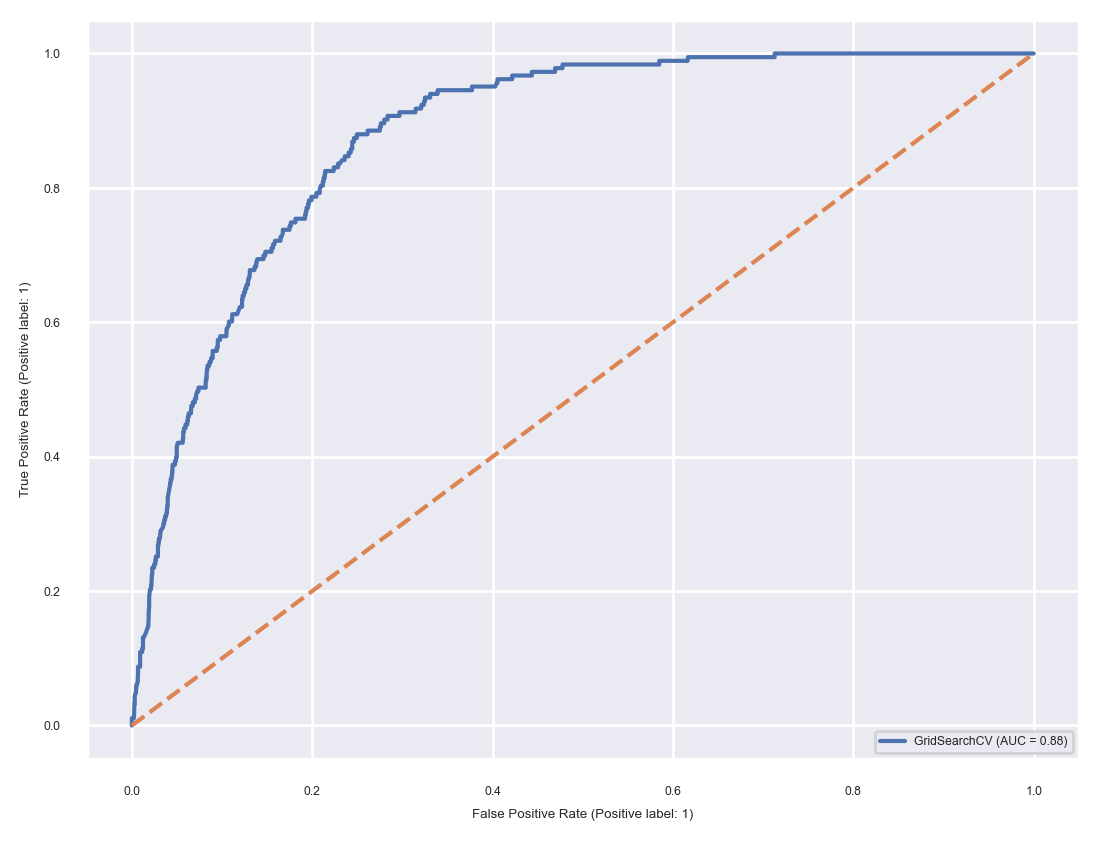

In [177]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(fitted_model,X_test,y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

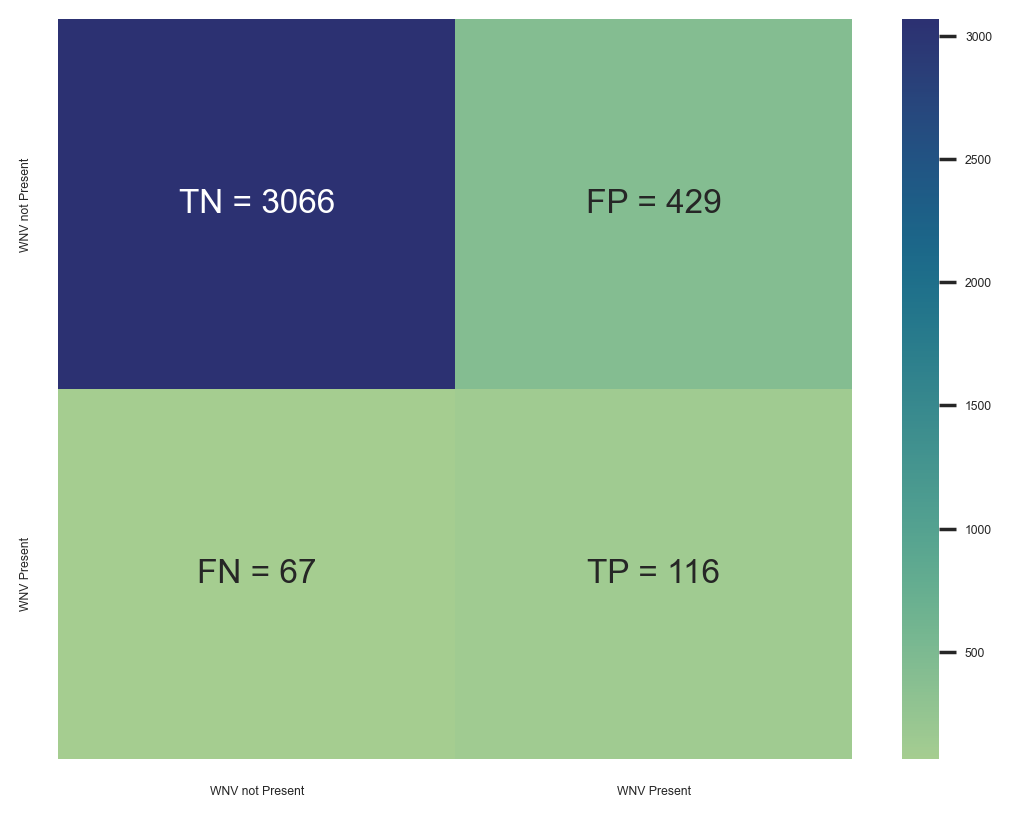

In [178]:
# plot confusion matrix
cm = confusion_matrix(y_test,fitted_model.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['WNV not Present', 'WNV Present'],
    yticklabels=['WNV not Present', 'WNV Present']
)

In [179]:
coef = fitted_model.best_estimator_['rgf_clf'].feature_importances_
feature = fitted_model.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

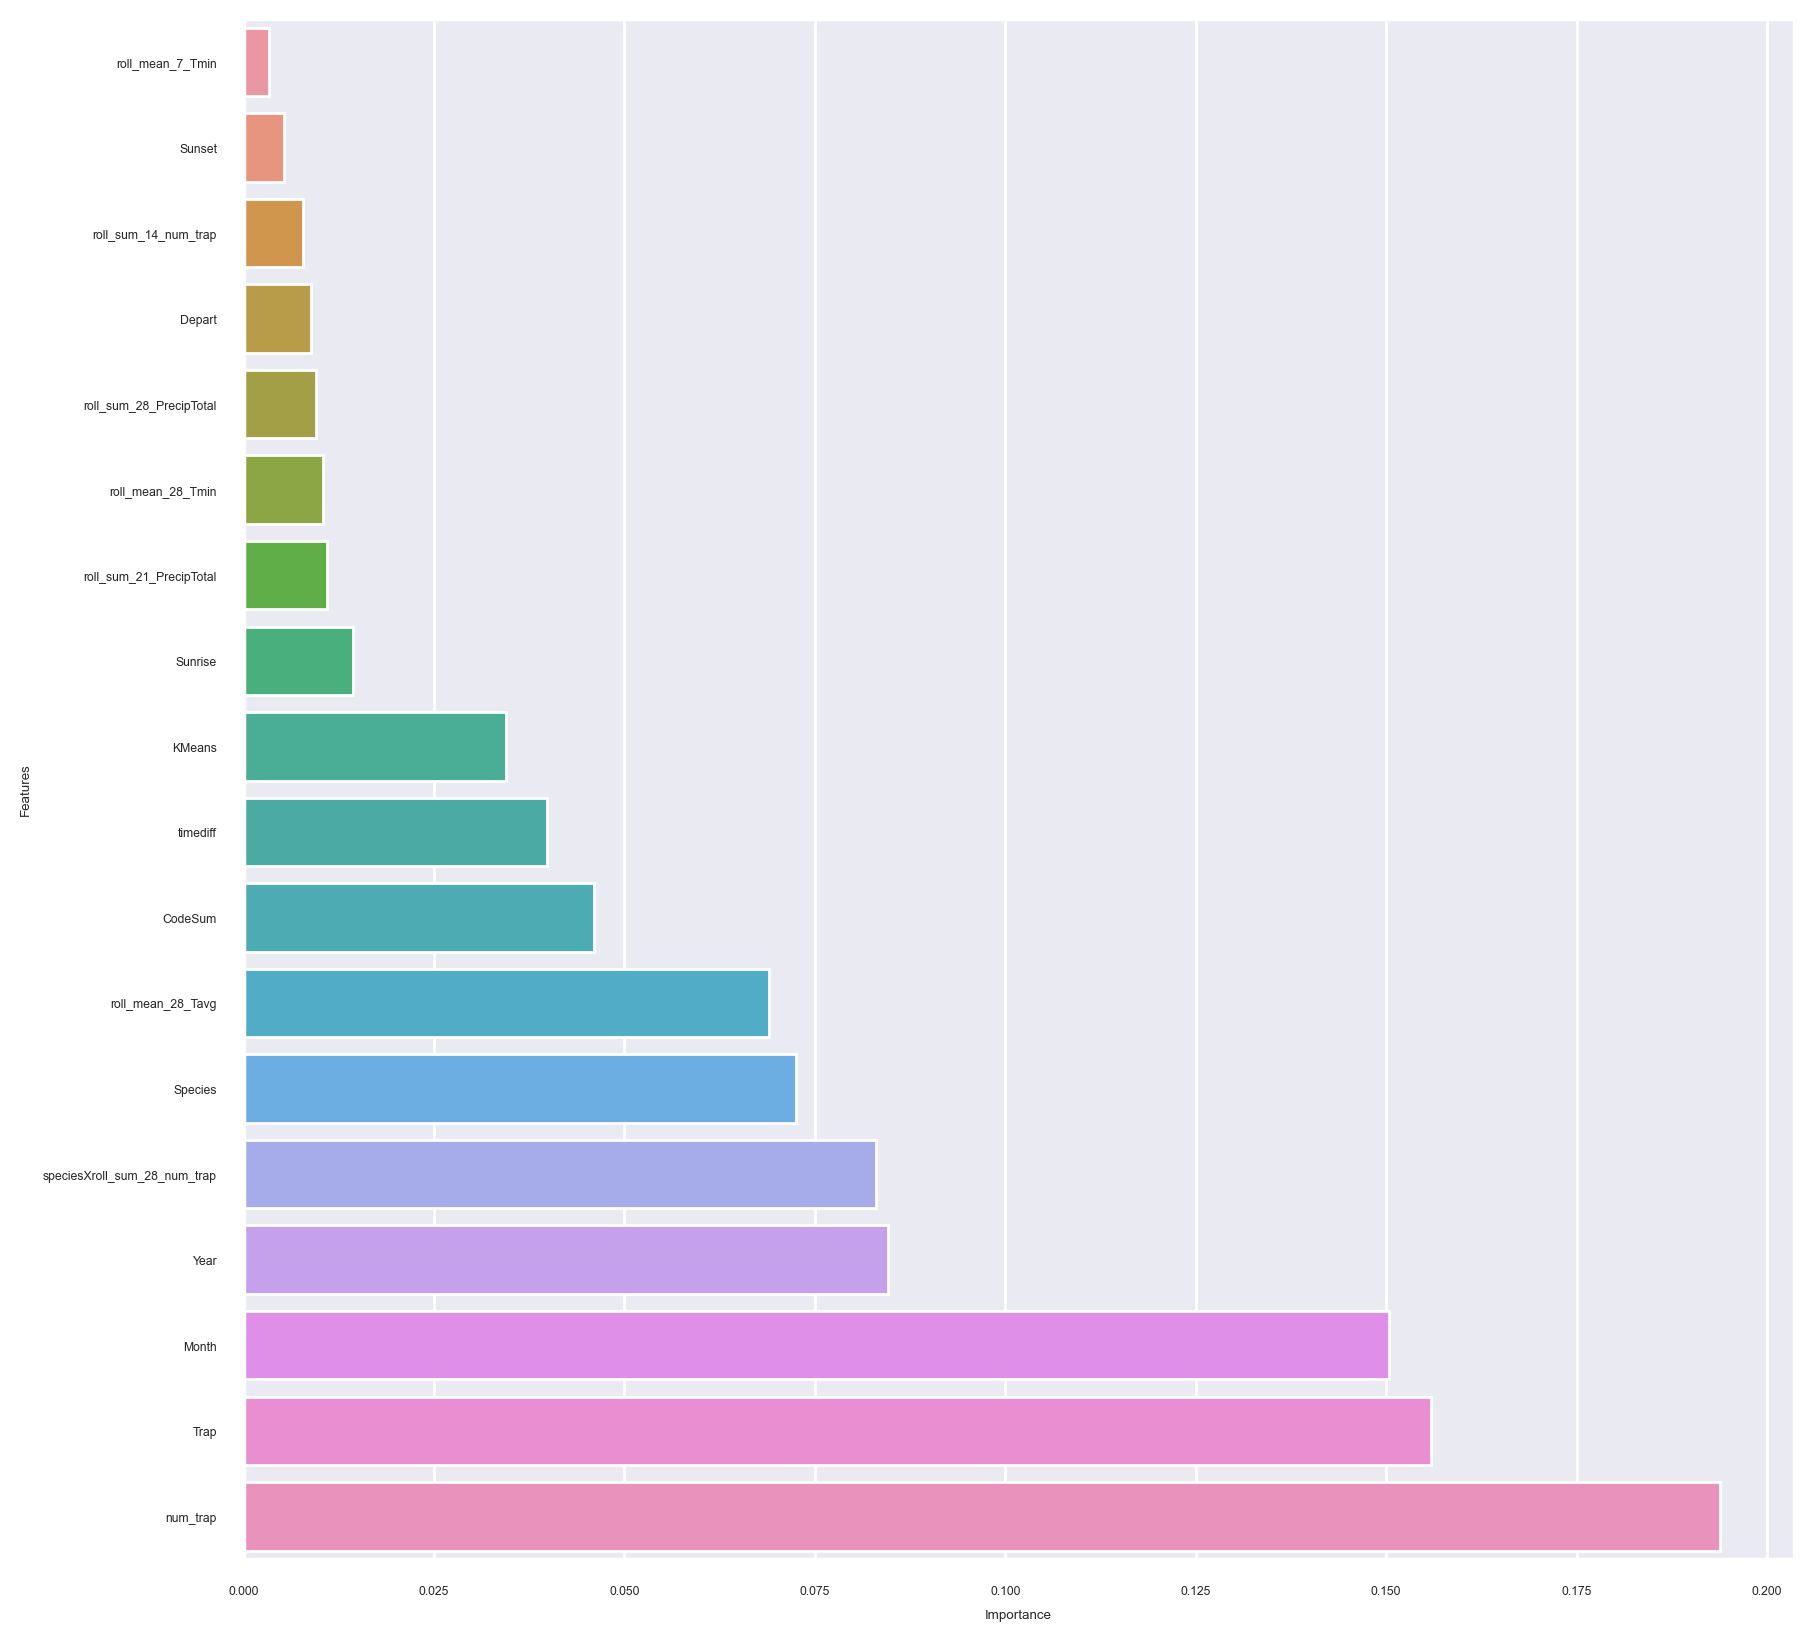

In [180]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(50, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

<a id='xgb'></a>

### XGBoost Classifier

In [263]:
pipe_xgb = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('sampling', SMOTETomek()),
    ('xgb_clf', xgb.XGBClassifier())
])

In [264]:
pipe_xgb.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sampling', SMOTETomek()),
                ('xgb_clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [265]:
pipe_xgb.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()),
  ('sampling', SMOTETomek()),
  ('xgb_clf',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=None, ...))],
 'verbose': False,
 'ss': StandardScaler(),
 'sampling': SMOTETomek(),
 'xgb_clf': XGBClassifier(base_score=None, 

In [266]:
pipe_xgb_params = {
    'sampling__sampling_strategy': [1.0], # ['all', auto', 'minority', 'not minority', 0.5]     
    'sampling__random_state': [42],
    'xgb_clf__n_estimators': [50,55],
    'xgb_clf__max_depth': [1,2,3],
    'xgb_clf__learning_rate': [1,None],
    'xgb_clf__random_state': [42],
}

In [267]:
pipe_xgb_gridsearch = GridSearchCV(pipe_xgb, pipe_xgb_params, scoring='recall',cv=5,verbose=3)

In [268]:
pipe_xgb_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=1, xgb_clf__max_depth=1, xgb_clf__n_estimators=50, xgb_clf__random_state=42;, score=0.635 total time=   0.2s
[CV 2/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=1, xgb_clf__max_depth=1, xgb_clf__n_estimators=50, xgb_clf__random_state=42;, score=0.703 total time=   0.2s
[CV 3/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=1, xgb_clf__max_depth=1, xgb_clf__n_estimators=50, xgb_clf__random_state=42;, score=0.689 total time=   0.2s
[CV 4/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=1, xgb_clf__max_depth=1, xgb_clf__n_estimators=50, xgb_clf__random_state=42;, score=0.671 total time=   0.2s
[CV 5/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=1, xgb_clf__max_depth=1

[CV 1/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=None, xgb_clf__max_depth=2, xgb_clf__n_estimators=50, xgb_clf__random_state=42;, score=0.649 total time=   0.2s
[CV 2/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=None, xgb_clf__max_depth=2, xgb_clf__n_estimators=50, xgb_clf__random_state=42;, score=0.622 total time=   0.3s
[CV 3/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=None, xgb_clf__max_depth=2, xgb_clf__n_estimators=50, xgb_clf__random_state=42;, score=0.662 total time=   0.2s
[CV 4/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=None, xgb_clf__max_depth=2, xgb_clf__n_estimators=50, xgb_clf__random_state=42;, score=0.644 total time=   0.2s
[CV 5/5] END sampling__random_state=42, sampling__sampling_strategy=1.0, xgb_clf__learning_rate=None, xgb_clf__max_depth=2, xgb_clf__n_estimators=50, xgb_clf__random_st

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling', SMOTETomek()),
                                       ('xgb_clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_poli...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'sampling__random_state': [42],
                         'sampling__sampling_strategy': [1.0],
                         'xgb_clf__learning_rate': [1, None],
                         'xgb_clf__max_depth': [1, 2, 3],
                         'xgb_clf__n_estimators': [50, 55],
                         'xgb_clf__random_state': [42]},
             scoring='recall', verbose=3)

In [269]:
# Print out best estimator.
pipe_xgb_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(random_state=42, sampling_strategy=1.0)),
                ('xgb_clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=1, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=55,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [270]:
# Print out best score.
# Mean cross-validated score of the best_estimator
pipe_xgb_gridsearch.best_score_

0.7525360977415773

In [271]:
# Evaluate the best model on the test data (accuracy score)
pipe_xgb_gridsearch.score(X_test, y_test)

0.8579234972677595

In [272]:
fitted_model = pipe_xgb_gridsearch

# ROC-AUC
pred_prob_train = fitted_model.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train[:,1])
pred_prob_test = fitted_model.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, fitted_model.predict(X_test)))

ROC-AUC on training set: 0.8630272832817337
ROC-AUC on testing set: 0.8777652696670497

              precision    recall  f1-score   support

           0       0.99      0.77      0.86      3495
           1       0.16      0.86      0.27       183

    accuracy                           0.77      3678
   macro avg       0.58      0.81      0.57      3678
weighted avg       0.95      0.77      0.83      3678



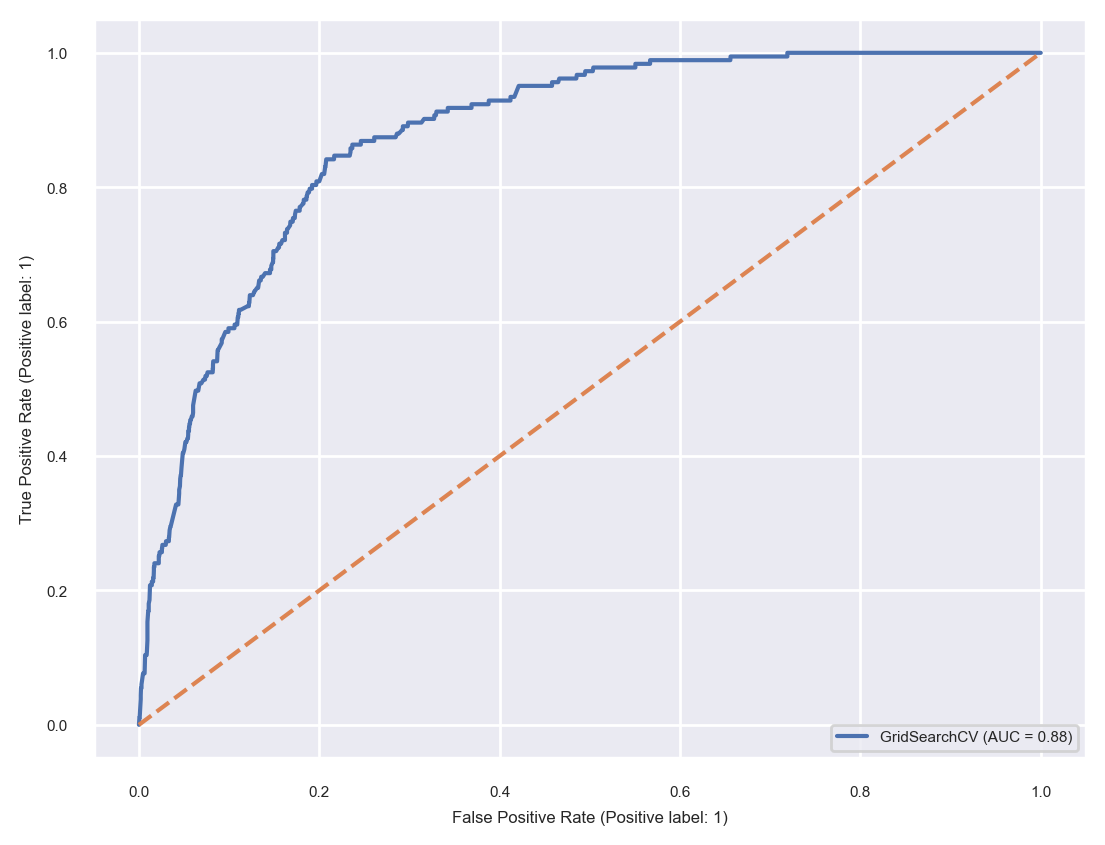

In [273]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(fitted_model,X_test,y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

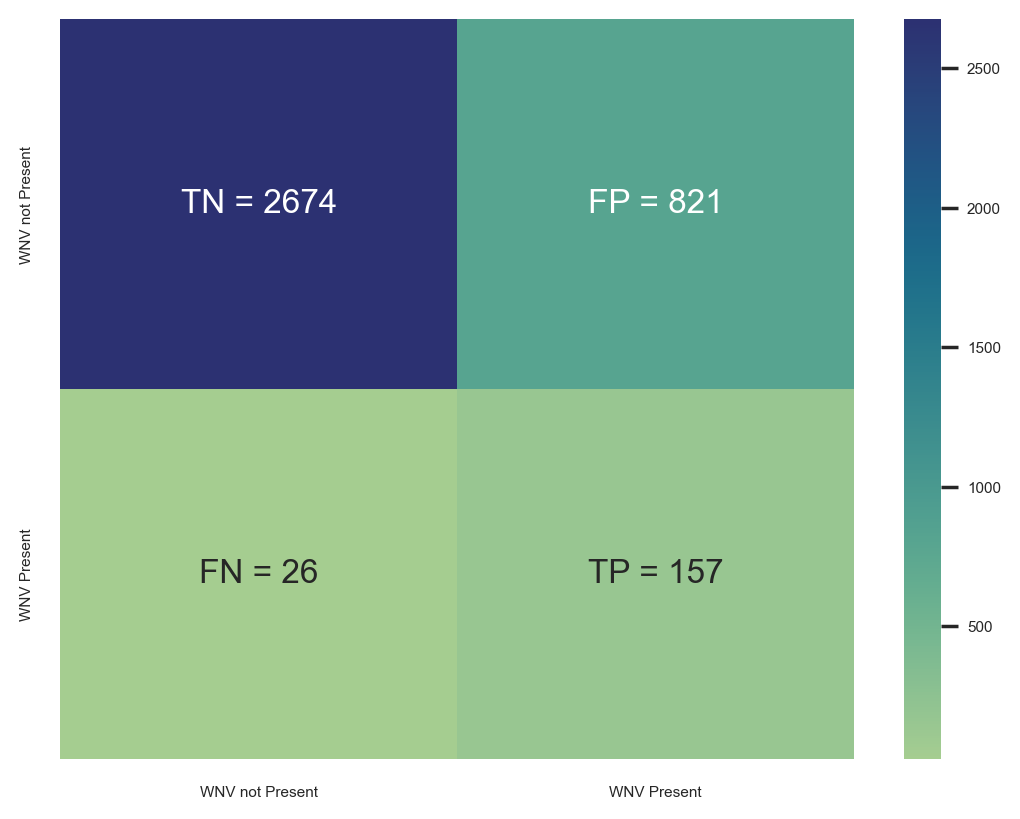

In [274]:
# plot confusion matrix
cm = confusion_matrix(y_test,fitted_model.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['WNV not Present', 'WNV Present'],
    yticklabels=['WNV not Present', 'WNV Present']
)

In [275]:
coef = fitted_model.best_estimator_['xgb_clf'].feature_importances_
feature = fitted_model.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

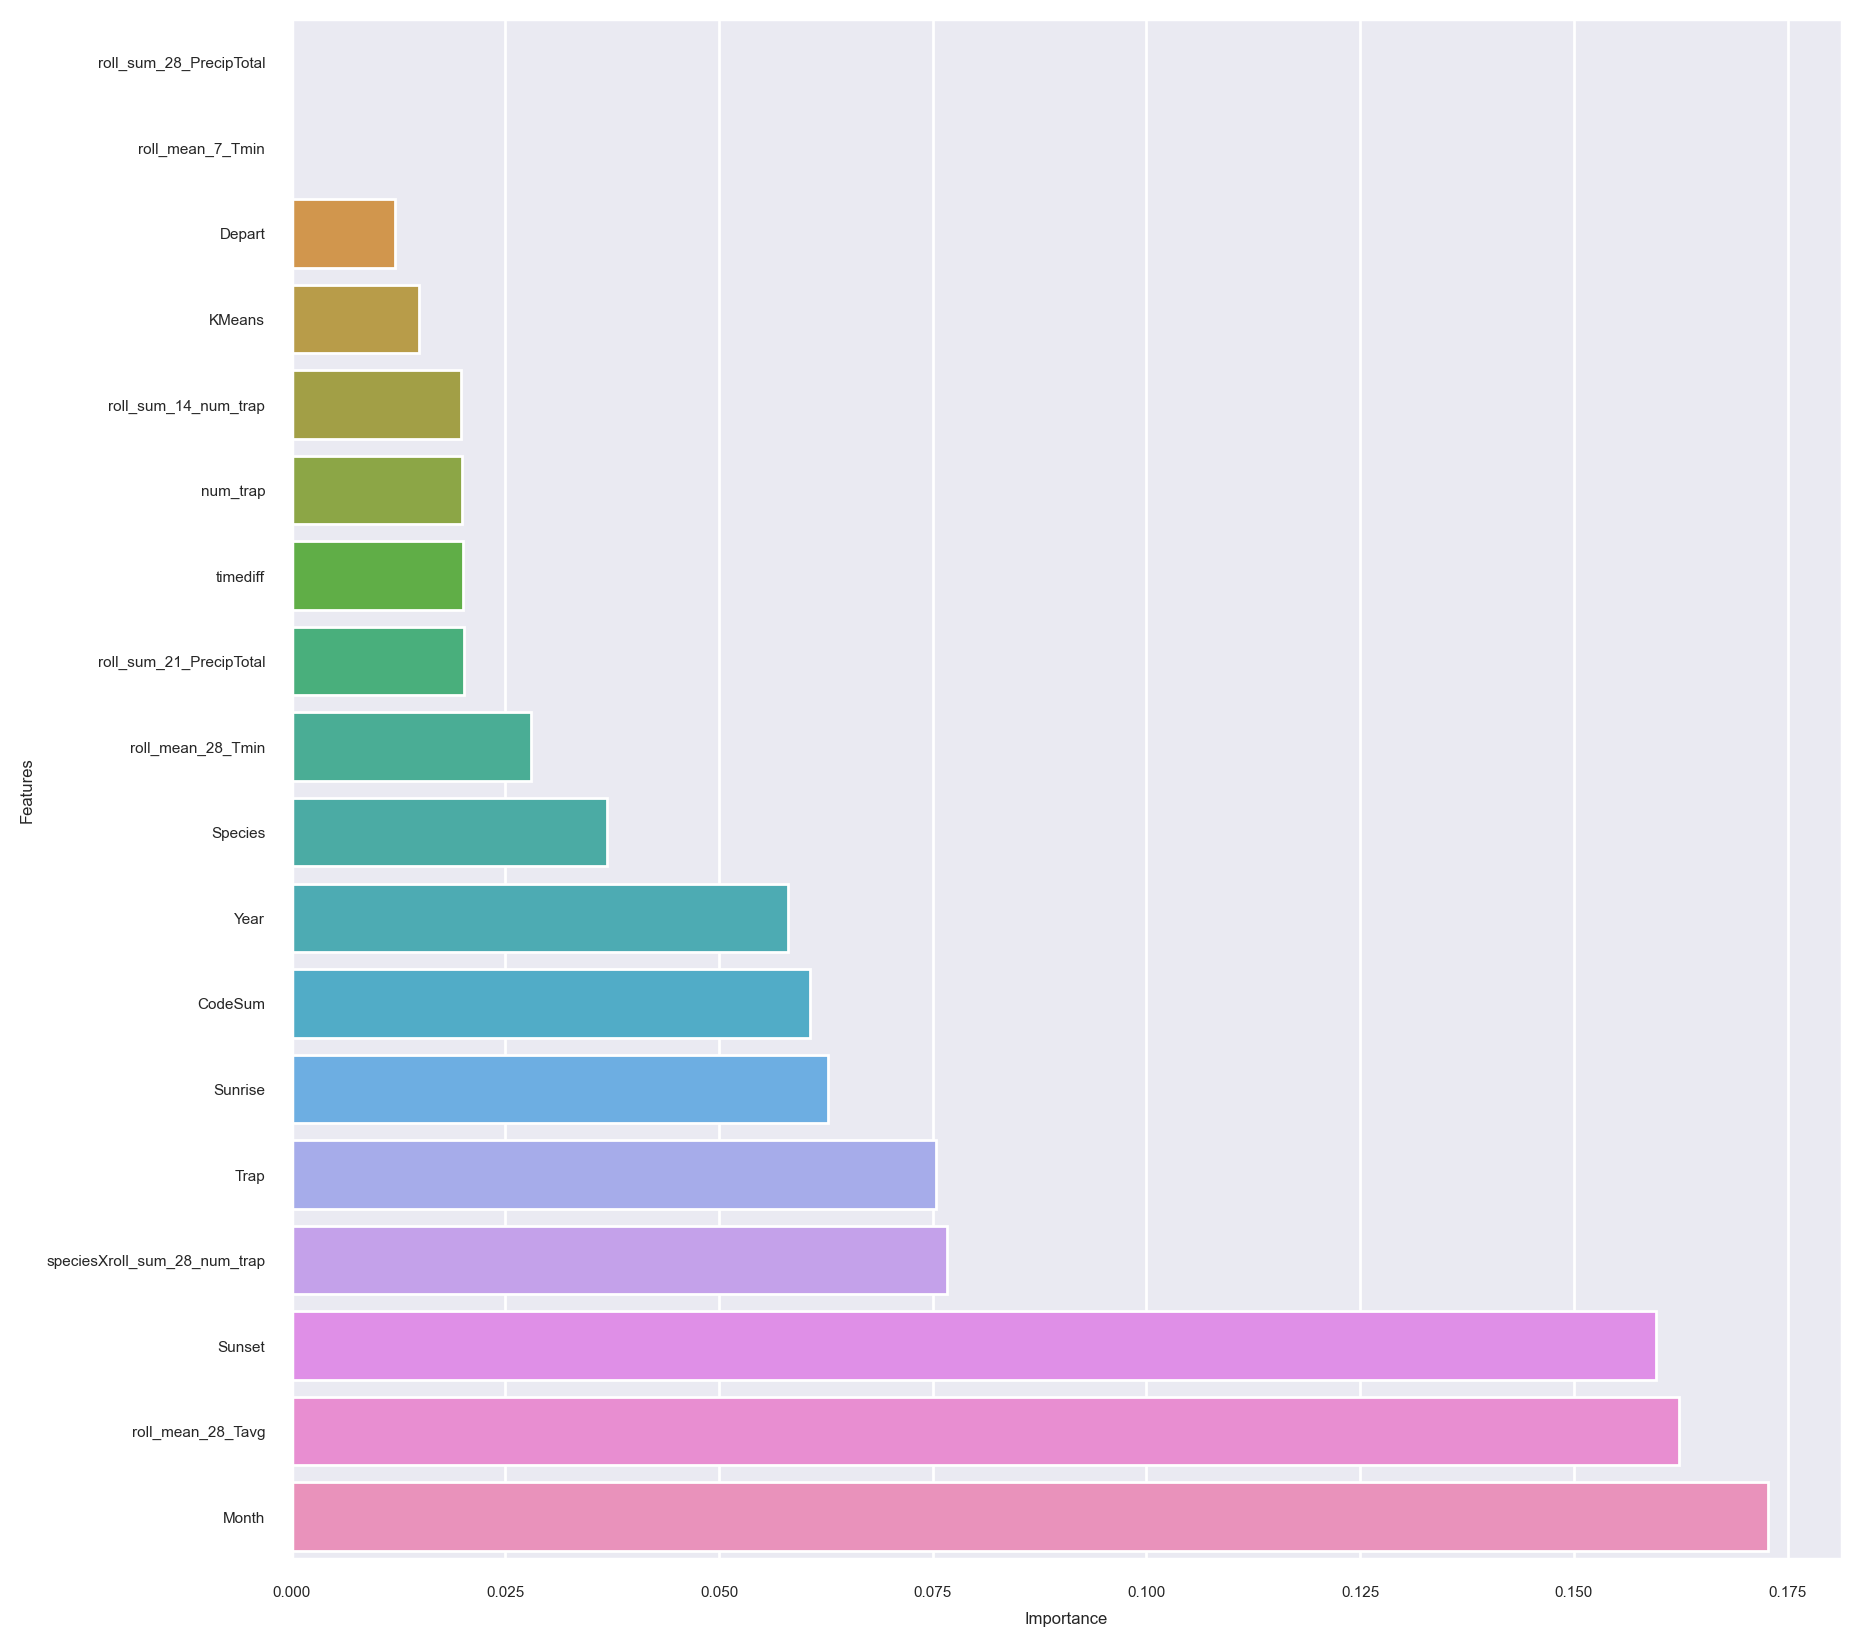

In [276]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(50, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.set(font_scale=0.5)
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

### Summary

<a id='summary'></a>

|Model (alphabetical order)|Train roc_auc Score|Test roc_auc Score|
|:-|:-:|:-:|
|AdaBoost Classifier|0.85|0.86|
|CatBoost Classifier|0.96|0.87|
|GradientBoosting Classifier|0.91|0.87|
|Logistic Regression|0.85|0.86|
|<b>RandomForest Classifier (Baseline)</b>|<b>0.99</b>|<b>0.84</b>|
|RegularizedGreedyForest Classifier|0.89|0.88|
|<b>XGBoost Classifier</b>|<b>0.86</b>|<b>0.88</b>|


The final model exhibited an improvement of 4.76% over the baseline model. It is worth mentioning that while the RegularizedGreedyForest Classifier displayed a marginally higher roc-auc score, its recall score was limited to 0.63. In contrast, the XGBoost Classifier demonstrated a significantly superior recall score of 0.86, signifying a remarkable 36.5% increase in performance. As previously emphasized, the accurate identification of actual positive cases held substantial importance, thus necessitating a thorough consideration of the recall score. Consequently, the XGBoost Classifier was selected as the ultimate model choice.

[Back to top of modelling section](#modelling)

<a id='kaggle'></a>

## 5. Kaggle Submission

In [300]:
# find cols that were not present in train fit
lst_to_drop_fit = [i for i in grp_test_df.columns if i not in grp_df.columns]
lst_to_drop_fit

['Id']

In [301]:
# predict 'WnvPresent' based on xgb model
best_model = pipe_xgb_gridsearch
xgb_grp_test_df = grp_test_df.copy(deep=True)
xgb_grp_test_df['WnvPresent'] = best_model.predict_proba(xgb_grp_test_df.drop(lst_to_drop_fit, 
                                                                        axis=1))[:,1]

In [303]:
# save in a separate df according Kaggle requirements
export_df = xgb_grp_test_df[['Id','WnvPresent']]

In [304]:
export_df = export_df.drop_duplicates()

In [305]:
# export and save in a csv file for kaggle submission
export_df.to_csv("../data/input/predicted_wnv.csv",index=False)

<b>Our final Kaggle score:- </b><br>
Private Score: 0.74098 <br>
Public Score: 0.76177

<a id='insights'></a>

## 6. Insights

- Based on our model’s feature importance, we can predict areas of importance to prioritise efforts on spray deployment. 
- The agency should consider the following collectively to determine priority areas within Chicago: 
    - `Month`, specifically in the months of Aug as we have seen in our EDA. 
    - a higher `roll_mean_28_Tavg`, as a higher 28day mean temperature in the summer months are optimal for mosquito gestation and activity, which would increase likelihood of WNV+ trap locations in those with `species` of `Culex Pipiens`.  
    - the `sunset`, `sunrise` and `timediff` (i.e. length of night) also prove to be important in predicting WNV+ as it is likely that `Culex Pipiens` favour around 11-12 hours of night time for their 'munching' activities. That said, the optimal length of night from a relatively late sunrise and sunset also tends to occur in Aug.  
    - as `trap` is feature engineered indirectly with `WnvPresent` and the same trap is usually deployed at the same locations, it is no surprise that this is an important feature. This also means that the model is dependent on how `trap` ID is assigned currently.

- Next, we also saw from our EDA of spray dataset that spray effectiveness is somewhat weak. Through use of our model's predictions, we would be able to augment spray deployments and optimise its use effectively. 

<a id='biz_rec'></a>

## 7. Recommendations

Instead of the current approach (i.e. as of 2015 when the Kaggle competition was launched by CDPH) where the agency seems to deploy adulticide spraying based on positive WNV traps<sup>1</sup>, we urge the agency to consider a data driven approach using our model to predict priority areas ahead of traps turning WNV positive. This also means that instead of spraying after the event where traps turn WNV positive, this model allows the agency to take pre-emptive action before the area is filled with WNV positive mosquitoes, which could have already led to incidence of human WNV cases. From a public health point of view, this would allow us to hammer down on the growth in WNV presence in the area, before the actual spike in human cases. 

Since the model is able to predict probabilities of WNV presence, the agency is able to accord different risk levels to these 77 community areas in Chicago, e.g. RED for highest risk, AMBER for medium risk, GREEN for low risk. Courses of action to take for each risk level can be drawn up, with RED being assigned the highest response measures (e.g. adulticiding + larvaciding + public education/comms campaign). Such information can also be made online for businesses and public to plan ahead. 


<sup>1. https://www.chicago.gov/city/en/depts/cdph/supp_info/infectious/west_nile_virus_surveillancereports.html</sup>

<a id='conclusion'></a>

## 8. Conclusion

Upon revisiting the problem statement, we are reminded of our two primary objectives:

1) <b>Objective 1</b>
- Our first objective was to construct a robust predictive model to facilitate informed decision-making by the city of Chicago regarding the strategic allocation of pesticide spraying for mosquito control.
- With a test ROC AUC of 0.88 and kaggle ROC AUC of 0.76, our model can efficiently predict and classify 76-88% of WNV+ traps correctly. The model can be deployed for early operations planning and decision making on which areas to be sprayed during the summer months. This will help to focus vector control efforts on potential hotspots, and prevent rise in unnecessary cases and deaths, and unnecessary use of financial and manpower resources to deploy the sprays. Nevertheless, the model would still need to be updated with up-to-date data so that it can continue to generate accurate predictions for continued future use.

2) <b>Objective 2</b>
- Our second objective was to conduct a comprehensive cost-benefit analysis. 
- Based on a 2013-year scenario cost benefit analysis, we estimate that our model approach outperforms the current approach with a benefit-cost ratio of 353. (if required, please refer to the pdf deck for details) 




<b> End of Part III</b> 